In [1]:
import afqinsight.nn.tf_models as nn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from afqinsight.datasets import AFQDataset
from afqinsight.nn.tf_models import cnn_lenet, mlp4, cnn_vgg, lstm1v0, lstm1, lstm2, blstm1, blstm2, lstm_fcn, cnn_resnet
from sklearn.impute import SimpleImputer
import os.path
# Harmonization
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

In [2]:
afq_dataset = AFQDataset.from_files(
    fn_nodes="../data/raw/combined_tract_profiles.csv",
    fn_subjects="../data/raw/participants_updated_id.csv",
    dwi_metrics=["dki_fa", "dki_md", "dki_mk"],
    index_col="subject_id",
    target_cols=["age", "dl_qc_score", "scan_site_id"],
    label_encode_cols=["scan_site_id"]
)

In [3]:
afq_dataset.drop_target_na()

In [4]:
print(len(afq_dataset.subjects))
print(afq_dataset.X.shape)
print(afq_dataset.y.shape)

1865
(1865, 7200)
(1865, 3)


In [5]:
full_dataset = list(afq_dataset.as_tensorflow_dataset().as_numpy_iterator())

2022-05-06 20:36:07.767462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.concatenate([xx[0][None] for xx in full_dataset], 0)
y = np.array([yy[1][0] for yy in full_dataset])
qc = np.array([yy[1][1] for yy in full_dataset])
site = np.array([yy[1][2] for yy in full_dataset])

In [7]:
X = X[qc>0]
y = y[qc>0]
site = site[qc>0]

In [8]:
# Split the data into train and test sets:
X_train, X_test, y_train, y_test, site_train, site_test = train_test_split(X, y, site, test_size=0.2, random_state=42)

In [9]:
imputer = SimpleImputer(strategy="median")

In [10]:
# Impute train and test separately:
X_train = np.concatenate([imputer.fit_transform(X_train[..., ii])[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([imputer.fit_transform(X_test[..., ii])[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [11]:
# Combat
X_train = np.concatenate([CombatModel().fit_transform(X_train[..., ii], site_train[:, None], None, None)[:, :, None] for ii in range(X_train.shape[-1])], -1)
X_test = np.concatenate([CombatModel().fit_transform(X_test[..., ii], site_test[:, None], None, None)[:, :, None] for ii in range(X_test.shape[-1])], -1)

In [12]:
n_epochs = 1000

# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    mode="min",
    patience=100
)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=20,
    verbose=1,
)

In [13]:
from afqinsight.augmentation import jitter, time_warp, scaling

In [14]:
def augment_this(X, y, rounds=2): 
    new_X = X[:]
    new_y = y[:]
    for f in range(rounds): 
        aug_X = np.zeros_like(X)
        # Do each channel separately:
        for channel in range(aug_X.shape[-1]):
            this_X = X[..., channel][..., np.newaxis]
            this_X = jitter(this_X, sigma=np.mean(this_X)/25)
            this_X = scaling(this_X, sigma=np.mean(this_X)/25)
            this_X = time_warp(this_X, sigma=np.mean(this_X)/25)
            aug_X[..., channel] = this_X[...,0]
        new_X = np.concatenate([new_X, aug_X])
        new_y = np.concatenate([new_y, y])
    return new_X, new_y 

In [15]:
# Generate evaluation results, training history, number of epochs
def model_history(model_name, ckpt_filepath, lr):
    model = model_name(input_shape=(100, 72), n_classes=1, output_activation=None, verbose=True)
    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  metrics=['mean_squared_error', tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mean_absolute_error'])
    # ModelCheckpoint
    ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_filepath,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
    )
    # CSVLogger
    log = tf.keras.callbacks.CSVLogger(filename= str(model_name) + '.csv', append=True)
    callbacks = [early_stopping, ckpt, reduce_lr, log]
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=128, validation_split=0.2,
                        callbacks=callbacks)
    model.load_weights(ckpt_filepath)
    eval_model = model.evaluate(X_test, y_test)
    count_epochs = history.epoch[-1]+1
    return eval_model, history, count_epochs

In [16]:
# Visualization of mean_squared_error, root_mean_squared_error, and mean_absolute_error
def vis_results(model_name, history, epoch):
    fig, ax = plt.subplots(1, 3, figsize=[20,5])
    fig.suptitle(model_name + ' epoch = ' + str(epoch), fontsize=15)
    ax[0].plot(history.history['loss'][10:])
    ax[0].plot(history.history['val_loss'][10:])
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].set_title('Mean Squared Error')
    ax[0].legend(['train', 'val'], loc='upper right')
    ax[1].plot(history.history['rmse'][10:])
    ax[1].plot(history.history['val_rmse'][10:])
    ax[1].set_ylabel('roor_mean_squared_error')
    ax[1].set_xlabel('epoch')
    ax[1].set_title('Root Mean Squared Error')
    ax[1].legend(['train', 'val'], loc='upper right')
    ax[2].plot(history.history['mean_absolute_error'][10:])
    ax[2].plot(history.history['val_mean_absolute_error'][10:])
    ax[2].set_ylabel('mean_absolute_error')
    ax[2].set_xlabel('epoch')
    ax[2].set_title('Mean Absolute Error')
    ax[2].legend(['train', 'val'], loc='upper right')
    plt.show()

### cnn_lenet

In [17]:
eval_lenet, history_lenet, epochs_lenet = model_history(cnn_lenet, '/tmp/lenet.h5', 0.001)

pooling layers: 4
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d (Conv1D)             (None, 100, 6)            1302      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 6)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 16)            304       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 16)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 26)

Epoch 13/1000
 9/10 [==========================>...] - ETA: 0s - loss: 15.5153 - mean_squared_error: 15.5153 - rmse: 3.9390 - mean_absolute_error: 3.1048
Epoch 00013: val_loss did not improve from 8.80558
10/10 [==============================] - 0s 17ms/step - loss: 15.6108 - mean_squared_error: 15.6108 - rmse: 3.9511 - mean_absolute_error: 3.1103 - val_loss: 9.2383 - val_mean_squared_error: 9.2383 - val_rmse: 3.0395 - val_mean_absolute_error: 2.3172 - lr: 0.0010
Epoch 14/1000
 9/10 [==========================>...] - ETA: 0s - loss: 16.2685 - mean_squared_error: 16.2685 - rmse: 4.0334 - mean_absolute_error: 3.1353
Epoch 00014: val_loss did not improve from 8.80558
10/10 [==============================] - 0s 17ms/step - loss: 16.1930 - mean_squared_error: 16.1930 - rmse: 4.0240 - mean_absolute_error: 3.1273 - val_loss: 13.6453 - val_mean_squared_error: 13.6453 - val_rmse: 3.6940 - val_mean_absolute_error: 2.7224 - lr: 0.0010
Epoch 15/1000
 8/10 [=======================>......] - ETA: 0s

 6/10 [=================>............] - ETA: 0s - loss: 16.5280 - mean_squared_error: 16.5280 - rmse: 4.0655 - mean_absolute_error: 3.2036
Epoch 00030: val_loss did not improve from 8.59546
10/10 [==============================] - 0s 15ms/step - loss: 16.1977 - mean_squared_error: 16.1977 - rmse: 4.0246 - mean_absolute_error: 3.1696 - val_loss: 9.9023 - val_mean_squared_error: 9.9023 - val_rmse: 3.1468 - val_mean_absolute_error: 2.3256 - lr: 0.0010
Epoch 31/1000
10/10 [==============================] - ETA: 0s - loss: 15.5335 - mean_squared_error: 15.5335 - rmse: 3.9413 - mean_absolute_error: 3.1079
Epoch 00031: val_loss did not improve from 8.59546
10/10 [==============================] - 0s 15ms/step - loss: 15.5335 - mean_squared_error: 15.5335 - rmse: 3.9413 - mean_absolute_error: 3.1079 - val_loss: 8.7726 - val_mean_squared_error: 8.7726 - val_rmse: 2.9619 - val_mean_absolute_error: 2.2884 - lr: 0.0010
Epoch 32/1000
10/10 [==============================] - ETA: 0s - loss: 15.3308

 6/10 [=================>............] - ETA: 0s - loss: 15.1651 - mean_squared_error: 15.1651 - rmse: 3.8942 - mean_absolute_error: 3.0645
Epoch 00047: val_loss did not improve from 8.32235
10/10 [==============================] - 0s 14ms/step - loss: 14.8029 - mean_squared_error: 14.8029 - rmse: 3.8475 - mean_absolute_error: 3.0353 - val_loss: 10.4694 - val_mean_squared_error: 10.4694 - val_rmse: 3.2356 - val_mean_absolute_error: 2.3641 - lr: 0.0010
Epoch 48/1000
 6/10 [=================>............] - ETA: 0s - loss: 15.0550 - mean_squared_error: 15.0550 - rmse: 3.8801 - mean_absolute_error: 3.0703
Epoch 00048: val_loss did not improve from 8.32235
10/10 [==============================] - 0s 14ms/step - loss: 14.6883 - mean_squared_error: 14.6883 - rmse: 3.8325 - mean_absolute_error: 3.0490 - val_loss: 9.3233 - val_mean_squared_error: 9.3233 - val_rmse: 3.0534 - val_mean_absolute_error: 2.2800 - lr: 0.0010
Epoch 49/1000
 6/10 [=================>............] - ETA: 0s - loss: 15.59

 7/10 [====================>.........] - ETA: 0s - loss: 14.2140 - mean_squared_error: 14.2140 - rmse: 3.7701 - mean_absolute_error: 2.9493
Epoch 00064: val_loss did not improve from 7.94385
10/10 [==============================] - 0s 21ms/step - loss: 14.0904 - mean_squared_error: 14.0904 - rmse: 3.7537 - mean_absolute_error: 2.9340 - val_loss: 8.5795 - val_mean_squared_error: 8.5795 - val_rmse: 2.9291 - val_mean_absolute_error: 2.2089 - lr: 0.0010
Epoch 65/1000
 6/10 [=================>............] - ETA: 0s - loss: 12.9980 - mean_squared_error: 12.9980 - rmse: 3.6053 - mean_absolute_error: 2.8268
Epoch 00065: val_loss did not improve from 7.94385
10/10 [==============================] - 0s 14ms/step - loss: 12.8836 - mean_squared_error: 12.8836 - rmse: 3.5894 - mean_absolute_error: 2.8434 - val_loss: 8.6834 - val_mean_squared_error: 8.6834 - val_rmse: 2.9468 - val_mean_absolute_error: 2.4904 - lr: 0.0010
Epoch 66/1000
 6/10 [=================>............] - ETA: 0s - loss: 13.9693

 9/10 [==========================>...] - ETA: 0s - loss: 13.6051 - mean_squared_error: 13.6051 - rmse: 3.6885 - mean_absolute_error: 2.8637
Epoch 00081: val_loss did not improve from 7.54087
10/10 [==============================] - 0s 27ms/step - loss: 13.5952 - mean_squared_error: 13.5952 - rmse: 3.6872 - mean_absolute_error: 2.8651 - val_loss: 8.0273 - val_mean_squared_error: 8.0273 - val_rmse: 2.8332 - val_mean_absolute_error: 2.1541 - lr: 0.0010
Epoch 82/1000
10/10 [==============================] - ETA: 0s - loss: 12.7447 - mean_squared_error: 12.7447 - rmse: 3.5700 - mean_absolute_error: 2.7676
Epoch 00082: val_loss did not improve from 7.54087
10/10 [==============================] - 0s 27ms/step - loss: 12.7447 - mean_squared_error: 12.7447 - rmse: 3.5700 - mean_absolute_error: 2.7676 - val_loss: 7.6367 - val_mean_squared_error: 7.6367 - val_rmse: 2.7635 - val_mean_absolute_error: 2.2214 - lr: 0.0010
Epoch 83/1000
10/10 [==============================] - ETA: 0s - loss: 12.4814

 8/10 [=======================>......] - ETA: 0s - loss: 12.9456 - mean_squared_error: 12.9456 - rmse: 3.5980 - mean_absolute_error: 2.8205
Epoch 00098: val_loss did not improve from 7.44794
10/10 [==============================] - 0s 29ms/step - loss: 12.7323 - mean_squared_error: 12.7323 - rmse: 3.5682 - mean_absolute_error: 2.8060 - val_loss: 9.7211 - val_mean_squared_error: 9.7211 - val_rmse: 3.1179 - val_mean_absolute_error: 2.2823 - lr: 0.0010
Epoch 99/1000
 7/10 [====================>.........] - ETA: 0s - loss: 12.0466 - mean_squared_error: 12.0466 - rmse: 3.4708 - mean_absolute_error: 2.7022
Epoch 00099: val_loss did not improve from 7.44794
10/10 [==============================] - 0s 26ms/step - loss: 11.9990 - mean_squared_error: 11.9990 - rmse: 3.4640 - mean_absolute_error: 2.7072 - val_loss: 7.5917 - val_mean_squared_error: 7.5917 - val_rmse: 2.7553 - val_mean_absolute_error: 2.2171 - lr: 0.0010
Epoch 100/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.587

Epoch 116/1000
 8/10 [=======================>......] - ETA: 0s - loss: 11.2246 - mean_squared_error: 11.2246 - rmse: 3.3503 - mean_absolute_error: 2.6002
Epoch 00116: val_loss did not improve from 7.12039
10/10 [==============================] - 0s 30ms/step - loss: 11.0708 - mean_squared_error: 11.0708 - rmse: 3.3273 - mean_absolute_error: 2.5792 - val_loss: 7.7779 - val_mean_squared_error: 7.7779 - val_rmse: 2.7889 - val_mean_absolute_error: 2.3124 - lr: 0.0010
Epoch 117/1000
 8/10 [=======================>......] - ETA: 0s - loss: 10.4137 - mean_squared_error: 10.4137 - rmse: 3.2270 - mean_absolute_error: 2.5048
Epoch 00117: val_loss did not improve from 7.12039
10/10 [==============================] - 0s 29ms/step - loss: 10.2634 - mean_squared_error: 10.2634 - rmse: 3.2037 - mean_absolute_error: 2.4912 - val_loss: 7.7839 - val_mean_squared_error: 7.7839 - val_rmse: 2.7900 - val_mean_absolute_error: 2.3180 - lr: 0.0010
Epoch 118/1000
 9/10 [==========================>...] - ETA: 0

10/10 [==============================] - ETA: 0s - loss: 9.9762 - mean_squared_error: 9.9762 - rmse: 3.1585 - mean_absolute_error: 2.4563  - ETA: 0s - loss: 10.1180 - mean_squared_error: 10.1180 - rmse: 3.1809 - mean_absolute_error: 2.47
Epoch 00133: val_loss did not improve from 6.47247
10/10 [==============================] - 0s 43ms/step - loss: 9.9762 - mean_squared_error: 9.9762 - rmse: 3.1585 - mean_absolute_error: 2.4563 - val_loss: 9.6296 - val_mean_squared_error: 9.6296 - val_rmse: 3.1032 - val_mean_absolute_error: 2.5990 - lr: 0.0010
Epoch 134/1000
10/10 [==============================] - ETA: 0s - loss: 11.5642 - mean_squared_error: 11.5642 - rmse: 3.4006 - mean_absolute_error: 2.6778
Epoch 00134: val_loss improved from 6.47247 to 6.30748, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 33ms/step - loss: 11.5642 - mean_squared_error: 11.5642 - rmse: 3.4006 - mean_absolute_error: 2.6778 - val_loss: 6.3075 - val_mean_squared_error: 6.3075 - val_rmse: 

 9/10 [==========================>...] - ETA: 0s - loss: 9.2467 - mean_squared_error: 9.2467 - rmse: 3.0408 - mean_absolute_error: 2.4086
Epoch 00150: val_loss did not improve from 6.22923
10/10 [==============================] - 0s 24ms/step - loss: 9.2931 - mean_squared_error: 9.2931 - rmse: 3.0485 - mean_absolute_error: 2.4123 - val_loss: 7.2844 - val_mean_squared_error: 7.2844 - val_rmse: 2.6990 - val_mean_absolute_error: 2.2280 - lr: 0.0010
Epoch 151/1000
10/10 [==============================] - ETA: 0s - loss: 9.9859 - mean_squared_error: 9.9859 - rmse: 3.1600 - mean_absolute_error: 2.4418
Epoch 00151: val_loss did not improve from 6.22923
10/10 [==============================] - 0s 26ms/step - loss: 9.9859 - mean_squared_error: 9.9859 - rmse: 3.1600 - mean_absolute_error: 2.4418 - val_loss: 7.7194 - val_mean_squared_error: 7.7194 - val_rmse: 2.7784 - val_mean_absolute_error: 2.3063 - lr: 0.0010
Epoch 152/1000
 7/10 [====================>.........] - ETA: 0s - loss: 10.9265 - mea

10/10 [==============================] - 0s 32ms/step - loss: 8.7897 - mean_squared_error: 8.7897 - rmse: 2.9647 - mean_absolute_error: 2.2881 - val_loss: 6.2081 - val_mean_squared_error: 6.2081 - val_rmse: 2.4916 - val_mean_absolute_error: 1.9982 - lr: 5.0000e-04
Epoch 168/1000
 8/10 [=======================>......] - ETA: 0s - loss: 8.6757 - mean_squared_error: 8.6757 - rmse: 2.9455 - mean_absolute_error: 2.2990
Epoch 00168: val_loss improved from 6.20812 to 6.13058, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 24ms/step - loss: 8.9038 - mean_squared_error: 8.9038 - rmse: 2.9839 - mean_absolute_error: 2.3330 - val_loss: 6.1306 - val_mean_squared_error: 6.1306 - val_rmse: 2.4760 - val_mean_absolute_error: 1.9399 - lr: 5.0000e-04
Epoch 169/1000
 8/10 [=======================>......] - ETA: 0s - loss: 9.1805 - mean_squared_error: 9.1805 - rmse: 3.0299 - mean_absolute_error: 2.3652
Epoch 00169: val_loss did not improve from 6.13058
10/10 [====================

Epoch 185/1000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6318 - mean_squared_error: 8.6318 - rmse: 2.9380 - mean_absolute_error: 2.2622
Epoch 00185: val_loss did not improve from 6.06378
10/10 [==============================] - 0s 23ms/step - loss: 8.5811 - mean_squared_error: 8.5811 - rmse: 2.9294 - mean_absolute_error: 2.2664 - val_loss: 6.2684 - val_mean_squared_error: 6.2684 - val_rmse: 2.5037 - val_mean_absolute_error: 2.0235 - lr: 5.0000e-04
Epoch 186/1000
10/10 [==============================] - ETA: 0s - loss: 8.5195 - mean_squared_error: 8.5195 - rmse: 2.9188 - mean_absolute_error: 2.2734
Epoch 00186: val_loss improved from 6.06378 to 6.00996, saving model to /tmp/lenet.h5
10/10 [==============================] - 0s 30ms/step - loss: 8.5195 - mean_squared_error: 8.5195 - rmse: 2.9188 - mean_absolute_error: 2.2734 - val_loss: 6.0100 - val_mean_squared_error: 6.0100 - val_rmse: 2.4515 - val_mean_absolute_error: 1.9184 - lr: 5.0000e-04
Epoch 187/1000
 7/10 [=====

Epoch 203/1000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5464 - mean_squared_error: 8.5464 - rmse: 2.9234 - mean_absolute_error: 2.2845
Epoch 00203: val_loss did not improve from 6.00996
10/10 [==============================] - 0s 24ms/step - loss: 8.3857 - mean_squared_error: 8.3857 - rmse: 2.8958 - mean_absolute_error: 2.2547 - val_loss: 6.2784 - val_mean_squared_error: 6.2784 - val_rmse: 2.5057 - val_mean_absolute_error: 2.0169 - lr: 5.0000e-04
Epoch 204/1000
10/10 [==============================] - ETA: 0s - loss: 7.6622 - mean_squared_error: 7.6622 - rmse: 2.7681 - mean_absolute_error: 2.1376
Epoch 00204: val_loss did not improve from 6.00996
10/10 [==============================] - 0s 31ms/step - loss: 7.6622 - mean_squared_error: 7.6622 - rmse: 2.7681 - mean_absolute_error: 2.1376 - val_loss: 6.0131 - val_mean_squared_error: 6.0131 - val_rmse: 2.4522 - val_mean_absolute_error: 1.9589 - lr: 5.0000e-04
Epoch 205/1000
 9/10 [==========================>...] - ETA: 0

 8/10 [=======================>......] - ETA: 0s - loss: 8.9997 - mean_squared_error: 8.9997 - rmse: 2.9999 - mean_absolute_error: 2.3322 
Epoch 00220: val_loss did not improve from 5.83087
10/10 [==============================] - 0s 29ms/step - loss: 8.7515 - mean_squared_error: 8.7515 - rmse: 2.9583 - mean_absolute_error: 2.2948 - val_loss: 6.8238 - val_mean_squared_error: 6.8238 - val_rmse: 2.6122 - val_mean_absolute_error: 2.1521 - lr: 5.0000e-04
Epoch 221/1000
10/10 [==============================] - ETA: 0s - loss: 8.3887 - mean_squared_error: 8.3887 - rmse: 2.8963 - mean_absolute_error: 2.2595
Epoch 00221: val_loss did not improve from 5.83087
10/10 [==============================] - 0s 26ms/step - loss: 8.3887 - mean_squared_error: 8.3887 - rmse: 2.8963 - mean_absolute_error: 2.2595 - val_loss: 6.0266 - val_mean_squared_error: 6.0266 - val_rmse: 2.4549 - val_mean_absolute_error: 1.8928 - lr: 5.0000e-04
Epoch 222/1000
10/10 [==============================] - ETA: 0s - loss: 8.62

Epoch 238/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1405 - mean_squared_error: 8.1405 - rmse: 2.8532 - mean_absolute_error: 2.1948
Epoch 00238: val_loss did not improve from 5.65928
10/10 [==============================] - 0s 30ms/step - loss: 8.1618 - mean_squared_error: 8.1618 - rmse: 2.8569 - mean_absolute_error: 2.1989 - val_loss: 5.9527 - val_mean_squared_error: 5.9527 - val_rmse: 2.4398 - val_mean_absolute_error: 1.8885 - lr: 5.0000e-04
Epoch 239/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.1672 - mean_squared_error: 8.1672 - rmse: 2.8578 - mean_absolute_error: 2.2199
Epoch 00239: val_loss did not improve from 5.65928
10/10 [==============================] - 0s 28ms/step - loss: 8.1725 - mean_squared_error: 8.1725 - rmse: 2.8588 - mean_absolute_error: 2.2187 - val_loss: 5.7851 - val_mean_squared_error: 5.7851 - val_rmse: 2.4052 - val_mean_absolute_error: 1.8822 - lr: 5.0000e-04
Epoch 240/1000
 8/10 [=======================>......] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 7.8665 - mean_squared_error: 7.8665 - rmse: 2.8047 - mean_absolute_error: 2.1286
Epoch 00255: val_loss did not improve from 5.58992
10/10 [==============================] - 0s 32ms/step - loss: 7.8319 - mean_squared_error: 7.8319 - rmse: 2.7986 - mean_absolute_error: 2.1244 - val_loss: 5.7545 - val_mean_squared_error: 5.7545 - val_rmse: 2.3988 - val_mean_absolute_error: 1.9144 - lr: 2.5000e-04
Epoch 256/1000
10/10 [==============================] - ETA: 0s - loss: 7.3399 - mean_squared_error: 7.3399 - rmse: 2.7092 - mean_absolute_error: 2.0909
Epoch 00256: val_loss did not improve from 5.58992
10/10 [==============================] - 0s 29ms/step - loss: 7.3399 - mean_squared_error: 7.3399 - rmse: 2.7092 - mean_absolute_error: 2.0909 - val_loss: 5.7318 - val_mean_squared_error: 5.7318 - val_rmse: 2.3941 - val_mean_absolute_error: 1.8992 - lr: 2.5000e-04
Epoch 257/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.776

Epoch 273/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7115 - mean_squared_error: 7.7115 - rmse: 2.7770 - mean_absolute_error: 2.1232
Epoch 00273: val_loss did not improve from 5.58992
10/10 [==============================] - 0s 29ms/step - loss: 7.7104 - mean_squared_error: 7.7104 - rmse: 2.7768 - mean_absolute_error: 2.1264 - val_loss: 5.7921 - val_mean_squared_error: 5.7921 - val_rmse: 2.4067 - val_mean_absolute_error: 1.9451 - lr: 1.2500e-04
Epoch 274/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.1724 - mean_squared_error: 7.1724 - rmse: 2.6781 - mean_absolute_error: 2.0790
Epoch 00274: val_loss did not improve from 5.58992
10/10 [==============================] - 0s 26ms/step - loss: 7.4661 - mean_squared_error: 7.4661 - rmse: 2.7324 - mean_absolute_error: 2.1163 - val_loss: 5.6513 - val_mean_squared_error: 5.6513 - val_rmse: 2.3772 - val_mean_absolute_error: 1.8907 - lr: 1.2500e-04
Epoch 275/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 7.3370 - mean_squared_error: 7.3370 - rmse: 2.7087 - mean_absolute_error: 2.0964
Epoch 00290: val_loss did not improve from 5.54613
10/10 [==============================] - 0s 36ms/step - loss: 7.3122 - mean_squared_error: 7.3122 - rmse: 2.7041 - mean_absolute_error: 2.0922 - val_loss: 5.6200 - val_mean_squared_error: 5.6200 - val_rmse: 2.3707 - val_mean_absolute_error: 1.8968 - lr: 1.2500e-04
Epoch 291/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.3005 - mean_squared_error: 7.3005 - rmse: 2.7019 - mean_absolute_error: 2.0841
Epoch 00291: val_loss did not improve from 5.54613
10/10 [==============================] - 0s 38ms/step - loss: 7.5478 - mean_squared_error: 7.5478 - rmse: 2.7473 - mean_absolute_error: 2.1166 - val_loss: 5.6309 - val_mean_squared_error: 5.6309 - val_rmse: 2.3729 - val_mean_absolute_error: 1.8923 - lr: 1.2500e-04
Epoch 292/1000
10/10 [==============================] - ETA: 0s - loss: 7.500

 9/10 [==========================>...] - ETA: 0s - loss: 7.6508 - mean_squared_error: 7.6508 - rmse: 2.7660 - mean_absolute_error: 2.1426
Epoch 00307: val_loss did not improve from 5.52070
10/10 [==============================] - 0s 28ms/step - loss: 7.6204 - mean_squared_error: 7.6204 - rmse: 2.7605 - mean_absolute_error: 2.1403 - val_loss: 5.5582 - val_mean_squared_error: 5.5582 - val_rmse: 2.3576 - val_mean_absolute_error: 1.8864 - lr: 1.2500e-04
Epoch 308/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.5114 - mean_squared_error: 7.5114 - rmse: 2.7407 - mean_absolute_error: 2.1181
Epoch 00308: val_loss did not improve from 5.52070
10/10 [==============================] - 0s 28ms/step - loss: 7.5287 - mean_squared_error: 7.5287 - rmse: 2.7439 - mean_absolute_error: 2.1227 - val_loss: 5.6164 - val_mean_squared_error: 5.6164 - val_rmse: 2.3699 - val_mean_absolute_error: 1.8943 - lr: 1.2500e-04
Epoch 309/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.547

Epoch 325/1000
10/10 [==============================] - ETA: 0s - loss: 7.2001 - mean_squared_error: 7.2001 - rmse: 2.6833 - mean_absolute_error: 2.1172
Epoch 00325: val_loss did not improve from 5.50599
10/10 [==============================] - 0s 31ms/step - loss: 7.2001 - mean_squared_error: 7.2001 - rmse: 2.6833 - mean_absolute_error: 2.1172 - val_loss: 5.5504 - val_mean_squared_error: 5.5504 - val_rmse: 2.3559 - val_mean_absolute_error: 1.8738 - lr: 1.2500e-04
Epoch 326/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2872 - mean_squared_error: 7.2872 - rmse: 2.6995 - mean_absolute_error: 2.0707
Epoch 00326: val_loss did not improve from 5.50599
10/10 [==============================] - 0s 27ms/step - loss: 7.2987 - mean_squared_error: 7.2987 - rmse: 2.7016 - mean_absolute_error: 2.0759 - val_loss: 5.8872 - val_mean_squared_error: 5.8872 - val_rmse: 2.4263 - val_mean_absolute_error: 1.9724 - lr: 1.2500e-04
Epoch 327/1000
 9/10 [==========================>...] - ETA: 0

 8/10 [=======================>......] - ETA: 0s - loss: 7.4165 - mean_squared_error: 7.4165 - rmse: 2.7233 - mean_absolute_error: 2.0706
Epoch 00342: val_loss did not improve from 5.50599
10/10 [==============================] - 0s 30ms/step - loss: 7.2432 - mean_squared_error: 7.2432 - rmse: 2.6913 - mean_absolute_error: 2.0574 - val_loss: 5.5375 - val_mean_squared_error: 5.5375 - val_rmse: 2.3532 - val_mean_absolute_error: 1.8840 - lr: 6.2500e-05
Epoch 343/1000
10/10 [==============================] - ETA: 0s - loss: 7.3039 - mean_squared_error: 7.3039 - rmse: 2.7026 - mean_absolute_error: 2.0556
Epoch 00343: val_loss did not improve from 5.50599
10/10 [==============================] - 0s 29ms/step - loss: 7.3039 - mean_squared_error: 7.3039 - rmse: 2.7026 - mean_absolute_error: 2.0556 - val_loss: 5.6092 - val_mean_squared_error: 5.6092 - val_rmse: 2.3684 - val_mean_absolute_error: 1.9081 - lr: 6.2500e-05
Epoch 344/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.711

 8/10 [=======================>......] - ETA: 0s - loss: 7.4973 - mean_squared_error: 7.4973 - rmse: 2.7381 - mean_absolute_error: 2.0756
Epoch 00359: val_loss did not improve from 5.49246
10/10 [==============================] - 0s 38ms/step - loss: 7.5050 - mean_squared_error: 7.5050 - rmse: 2.7395 - mean_absolute_error: 2.0851 - val_loss: 5.6144 - val_mean_squared_error: 5.6144 - val_rmse: 2.3695 - val_mean_absolute_error: 1.9112 - lr: 6.2500e-05
Epoch 360/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.1803 - mean_squared_error: 7.1803 - rmse: 2.6796 - mean_absolute_error: 2.0692
Epoch 00360: val_loss did not improve from 5.49246
10/10 [==============================] - 0s 36ms/step - loss: 7.1545 - mean_squared_error: 7.1545 - rmse: 2.6748 - mean_absolute_error: 2.0660 - val_loss: 5.6195 - val_mean_squared_error: 5.6195 - val_rmse: 2.3705 - val_mean_absolute_error: 1.9142 - lr: 6.2500e-05
Epoch 361/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.893

Epoch 377/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.1208 - mean_squared_error: 7.1208 - rmse: 2.6685 - mean_absolute_error: 2.0595
Epoch 00377: val_loss did not improve from 5.49246
10/10 [==============================] - 0s 43ms/step - loss: 7.0249 - mean_squared_error: 7.0249 - rmse: 2.6505 - mean_absolute_error: 2.0527 - val_loss: 5.5465 - val_mean_squared_error: 5.5465 - val_rmse: 2.3551 - val_mean_absolute_error: 1.8869 - lr: 3.1250e-05
Epoch 378/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0577 - mean_squared_error: 7.0577 - rmse: 2.6566 - mean_absolute_error: 2.0296
Epoch 00378: val_loss did not improve from 5.49246
10/10 [==============================] - 0s 35ms/step - loss: 7.0575 - mean_squared_error: 7.0575 - rmse: 2.6566 - mean_absolute_error: 2.0334 - val_loss: 5.5191 - val_mean_squared_error: 5.5191 - val_rmse: 2.3493 - val_mean_absolute_error: 1.8753 - lr: 3.1250e-05
Epoch 379/1000
 8/10 [=======================>......] - ETA: 0

10/10 [==============================] - ETA: 0s - loss: 7.3029 - mean_squared_error: 7.3029 - rmse: 2.7024 - mean_absolute_error: 2.0582
Epoch 00394: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 28ms/step - loss: 7.3029 - mean_squared_error: 7.3029 - rmse: 2.7024 - mean_absolute_error: 2.0582 - val_loss: 5.5021 - val_mean_squared_error: 5.5021 - val_rmse: 2.3457 - val_mean_absolute_error: 1.8702 - lr: 3.1250e-05
Epoch 395/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.0375 - mean_squared_error: 7.0375 - rmse: 2.6528 - mean_absolute_error: 2.0544
Epoch 00395: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 24ms/step - loss: 7.2015 - mean_squared_error: 7.2015 - rmse: 2.6836 - mean_absolute_error: 2.0786 - val_loss: 5.5045 - val_mean_squared_error: 5.5045 - val_rmse: 2.3462 - val_mean_absolute_error: 1.8527 - lr: 3.1250e-05
Epoch 396/1000
10/10 [==============================] - ETA: 0s - loss: 7.192

10/10 [==============================] - 0s 29ms/step - loss: 7.0494 - mean_squared_error: 7.0494 - rmse: 2.6551 - mean_absolute_error: 2.0669 - val_loss: 5.5102 - val_mean_squared_error: 5.5102 - val_rmse: 2.3474 - val_mean_absolute_error: 1.8745 - lr: 1.5625e-05
Epoch 412/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.0296 - mean_squared_error: 7.0296 - rmse: 2.6513 - mean_absolute_error: 2.0431
Epoch 00412: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 33ms/step - loss: 7.1724 - mean_squared_error: 7.1724 - rmse: 2.6781 - mean_absolute_error: 2.0624 - val_loss: 5.5197 - val_mean_squared_error: 5.5197 - val_rmse: 2.3494 - val_mean_absolute_error: 1.8785 - lr: 1.5625e-05
Epoch 413/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.0776 - mean_squared_error: 7.0776 - rmse: 2.6604 - mean_absolute_error: 2.0585
Epoch 00413: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 29ms/step - loss: 

Epoch 429/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.2148 - mean_squared_error: 7.2148 - rmse: 2.6860 - mean_absolute_error: 2.0878
Epoch 00429: val_loss did not improve from 5.47390

Epoch 00429: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
10/10 [==============================] - 0s 45ms/step - loss: 7.2421 - mean_squared_error: 7.2421 - rmse: 2.6911 - mean_absolute_error: 2.0874 - val_loss: 5.5982 - val_mean_squared_error: 5.5982 - val_rmse: 2.3661 - val_mean_absolute_error: 1.9056 - lr: 1.5625e-05
Epoch 430/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.9655 - mean_squared_error: 6.9655 - rmse: 2.6392 - mean_absolute_error: 2.0325
Epoch 00430: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 32ms/step - loss: 7.0254 - mean_squared_error: 7.0254 - rmse: 2.6506 - mean_absolute_error: 2.0296 - val_loss: 5.6083 - val_mean_squared_error: 5.6083 - val_rmse: 2.3682 - val_mean_absolute_error: 1.908

10/10 [==============================] - ETA: 0s - loss: 6.7739 - mean_squared_error: 6.7739 - rmse: 2.6027 - mean_absolute_error: 2.0148
Epoch 00446: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 28ms/step - loss: 6.7739 - mean_squared_error: 6.7739 - rmse: 2.6027 - mean_absolute_error: 2.0148 - val_loss: 5.5142 - val_mean_squared_error: 5.5142 - val_rmse: 2.3482 - val_mean_absolute_error: 1.8810 - lr: 7.8125e-06
Epoch 447/1000
10/10 [==============================] - ETA: 0s - loss: 7.3376 - mean_squared_error: 7.3376 - rmse: 2.7088 - mean_absolute_error: 2.0737
Epoch 00447: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 28ms/step - loss: 7.3376 - mean_squared_error: 7.3376 - rmse: 2.7088 - mean_absolute_error: 2.0737 - val_loss: 5.5279 - val_mean_squared_error: 5.5279 - val_rmse: 2.3511 - val_mean_absolute_error: 1.8855 - lr: 7.8125e-06
Epoch 448/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.644

Epoch 464/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.7506 - mean_squared_error: 7.7506 - rmse: 2.7840 - mean_absolute_error: 2.1113
Epoch 00464: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 24ms/step - loss: 7.4269 - mean_squared_error: 7.4269 - rmse: 2.7252 - mean_absolute_error: 2.0752 - val_loss: 5.5004 - val_mean_squared_error: 5.5004 - val_rmse: 2.3453 - val_mean_absolute_error: 1.8778 - lr: 3.9063e-06
Epoch 465/1000
 8/10 [=======================>......] - ETA: 0s - loss: 7.7335 - mean_squared_error: 7.7335 - rmse: 2.7809 - mean_absolute_error: 2.1604
Epoch 00465: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 31ms/step - loss: 7.7085 - mean_squared_error: 7.7085 - rmse: 2.7764 - mean_absolute_error: 2.1543 - val_loss: 5.5113 - val_mean_squared_error: 5.5113 - val_rmse: 2.3476 - val_mean_absolute_error: 1.8815 - lr: 3.9063e-06
Epoch 466/1000
10/10 [==============================] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 7.0785 - mean_squared_error: 7.0785 - rmse: 2.6605 - mean_absolute_error: 2.0508
Epoch 00481: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 25ms/step - loss: 7.1106 - mean_squared_error: 7.1106 - rmse: 2.6666 - mean_absolute_error: 2.0523 - val_loss: 5.5407 - val_mean_squared_error: 5.5407 - val_rmse: 2.3539 - val_mean_absolute_error: 1.8905 - lr: 1.9531e-06
Epoch 482/1000
 7/10 [====================>.........] - ETA: 0s - loss: 7.1857 - mean_squared_error: 7.1857 - rmse: 2.6806 - mean_absolute_error: 2.0679
Epoch 00482: val_loss did not improve from 5.47390
10/10 [==============================] - 0s 27ms/step - loss: 7.1321 - mean_squared_error: 7.1321 - rmse: 2.6706 - mean_absolute_error: 2.0675 - val_loss: 5.5283 - val_mean_squared_error: 5.5283 - val_rmse: 2.3512 - val_mean_absolute_error: 1.8864 - lr: 1.9531e-06
Epoch 483/1000
10/10 [==============================] - ETA: 0s - loss: 6.791

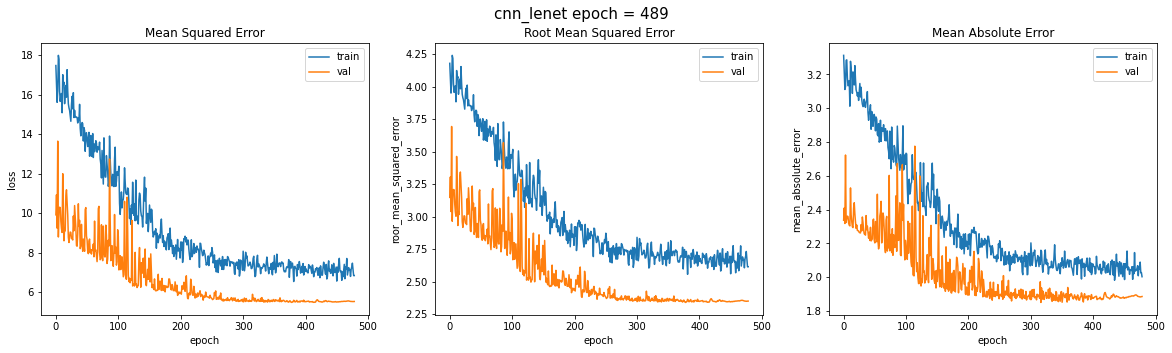

In [18]:
vis_results('cnn_lenet', history_lenet, epochs_lenet)

In [19]:
results = {'cnn_lenet' : eval_lenet[1:]}

### mlp4

In [20]:
eval_mlp4, history_mlp4, epochs_mlp4 = model_history(mlp4, '/tmp/mlp4.h5', 0.001)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 7200)              0         
                                                                 
 dropout_2 (Dropout)         (None, 7200)              0         
                                                                 
 dense_3 (Dense)             (None, 500)               3600500   
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 500)               250500    
                                                                 
 dropout_4 (Dropout)         (None, 500)               0   

Epoch 15/1000
10/10 [==============================] - ETA: 0s - loss: 12.3528 - mean_squared_error: 12.3528 - rmse: 3.5147 - mean_absolute_error: 2.7969
Epoch 00015: val_loss did not improve from 8.59163
10/10 [==============================] - 0s 45ms/step - loss: 12.3528 - mean_squared_error: 12.3528 - rmse: 3.5147 - mean_absolute_error: 2.7969 - val_loss: 12.2929 - val_mean_squared_error: 12.2929 - val_rmse: 3.5061 - val_mean_absolute_error: 2.5592 - lr: 0.0010
Epoch 16/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.7100 - mean_squared_error: 11.7100 - rmse: 3.4220 - mean_absolute_error: 2.7758
Epoch 00016: val_loss did not improve from 8.59163
10/10 [==============================] - 0s 45ms/step - loss: 11.6996 - mean_squared_error: 11.6996 - rmse: 3.4205 - mean_absolute_error: 2.7750 - val_loss: 14.0591 - val_mean_squared_error: 14.0591 - val_rmse: 3.7495 - val_mean_absolute_error: 2.7688 - lr: 0.0010
Epoch 17/1000
 9/10 [==========================>...] - ETA: 

10/10 [==============================] - ETA: 0s - loss: 11.2771 - mean_squared_error: 11.2771 - rmse: 3.3581 - mean_absolute_error: 2.7049
Epoch 00032: val_loss did not improve from 7.85976
10/10 [==============================] - 0s 41ms/step - loss: 11.2771 - mean_squared_error: 11.2771 - rmse: 3.3581 - mean_absolute_error: 2.7049 - val_loss: 7.8669 - val_mean_squared_error: 7.8669 - val_rmse: 2.8048 - val_mean_absolute_error: 2.2025 - lr: 0.0010
Epoch 33/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.0582 - mean_squared_error: 11.0582 - rmse: 3.3254 - mean_absolute_error: 2.6909
Epoch 00033: val_loss did not improve from 7.85976
10/10 [==============================] - 0s 48ms/step - loss: 11.0664 - mean_squared_error: 11.0664 - rmse: 3.3266 - mean_absolute_error: 2.6888 - val_loss: 15.8372 - val_mean_squared_error: 15.8372 - val_rmse: 3.9796 - val_mean_absolute_error: 3.0549 - lr: 0.0010
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 11.61

 9/10 [==========================>...] - ETA: 0s - loss: 9.2579 - mean_squared_error: 9.2579 - rmse: 3.0427 - mean_absolute_error: 2.4335
Epoch 00049: val_loss did not improve from 6.65258
10/10 [==============================] - 0s 41ms/step - loss: 9.2446 - mean_squared_error: 9.2446 - rmse: 3.0405 - mean_absolute_error: 2.4322 - val_loss: 20.2591 - val_mean_squared_error: 20.2591 - val_rmse: 4.5010 - val_mean_absolute_error: 3.7012 - lr: 0.0010
Epoch 50/1000
10/10 [==============================] - ETA: 0s - loss: 12.0117 - mean_squared_error: 12.0117 - rmse: 3.4658 - mean_absolute_error: 2.7381
Epoch 00050: val_loss did not improve from 6.65258
10/10 [==============================] - 1s 54ms/step - loss: 12.0117 - mean_squared_error: 12.0117 - rmse: 3.4658 - mean_absolute_error: 2.7381 - val_loss: 12.8745 - val_mean_squared_error: 12.8745 - val_rmse: 3.5881 - val_mean_absolute_error: 2.7161 - lr: 0.0010
Epoch 51/1000
 9/10 [==========================>...] - ETA: 0s - loss: 12.0013

Epoch 67/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.5100 - mean_squared_error: 9.5100 - rmse: 3.0838 - mean_absolute_error: 2.3969 
Epoch 00067: val_loss did not improve from 6.07701
10/10 [==============================] - 0s 45ms/step - loss: 9.5391 - mean_squared_error: 9.5391 - rmse: 3.0886 - mean_absolute_error: 2.4022 - val_loss: 9.0333 - val_mean_squared_error: 9.0333 - val_rmse: 3.0055 - val_mean_absolute_error: 2.2399 - lr: 0.0010
Epoch 68/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.0258 - mean_squared_error: 8.0258 - rmse: 2.8330 - mean_absolute_error: 2.2266
Epoch 00068: val_loss did not improve from 6.07701
10/10 [==============================] - 1s 57ms/step - loss: 8.0559 - mean_squared_error: 8.0559 - rmse: 2.8383 - mean_absolute_error: 2.2310 - val_loss: 8.6459 - val_mean_squared_error: 8.6459 - val_rmse: 2.9404 - val_mean_absolute_error: 2.2155 - lr: 0.0010
Epoch 69/1000
 9/10 [==========================>...] - ETA: 0s - loss: 

Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 8.3378 - mean_squared_error: 8.3378 - rmse: 2.8875 - mean_absolute_error: 2.2882
Epoch 00085: val_loss did not improve from 5.72285
10/10 [==============================] - 1s 74ms/step - loss: 8.3378 - mean_squared_error: 8.3378 - rmse: 2.8875 - mean_absolute_error: 2.2882 - val_loss: 8.6034 - val_mean_squared_error: 8.6034 - val_rmse: 2.9332 - val_mean_absolute_error: 2.1786 - lr: 0.0010
Epoch 86/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.3281 - mean_squared_error: 8.3281 - rmse: 2.8858 - mean_absolute_error: 2.3096
Epoch 00086: val_loss did not improve from 5.72285
10/10 [==============================] - 1s 61ms/step - loss: 8.5565 - mean_squared_error: 8.5565 - rmse: 2.9252 - mean_absolute_error: 2.3307 - val_loss: 6.5202 - val_mean_squared_error: 6.5202 - val_rmse: 2.5535 - val_mean_absolute_error: 2.1165 - lr: 0.0010
Epoch 87/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1

Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.3921 - mean_squared_error: 7.3921 - rmse: 2.7188 - mean_absolute_error: 2.1420
Epoch 00103: val_loss did not improve from 5.72285
10/10 [==============================] - 0s 50ms/step - loss: 7.3851 - mean_squared_error: 7.3851 - rmse: 2.7175 - mean_absolute_error: 2.1410 - val_loss: 10.1701 - val_mean_squared_error: 10.1701 - val_rmse: 3.1891 - val_mean_absolute_error: 2.4205 - lr: 5.0000e-04
Epoch 104/1000
10/10 [==============================] - ETA: 0s - loss: 7.2304 - mean_squared_error: 7.2304 - rmse: 2.6889 - mean_absolute_error: 2.1315
Epoch 00104: val_loss did not improve from 5.72285
10/10 [==============================] - 0s 49ms/step - loss: 7.2304 - mean_squared_error: 7.2304 - rmse: 2.6889 - mean_absolute_error: 2.1315 - val_loss: 12.0905 - val_mean_squared_error: 12.0905 - val_rmse: 3.4771 - val_mean_absolute_error: 2.7016 - lr: 5.0000e-04
Epoch 105/1000
 9/10 [==========================>...] - ET

Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8506 - mean_squared_error: 6.8506 - rmse: 2.6174 - mean_absolute_error: 2.0674
Epoch 00121: val_loss improved from 5.69830 to 5.21435, saving model to /tmp/mlp4.h5
10/10 [==============================] - 1s 54ms/step - loss: 6.9215 - mean_squared_error: 6.9215 - rmse: 2.6309 - mean_absolute_error: 2.0799 - val_loss: 5.2143 - val_mean_squared_error: 5.2143 - val_rmse: 2.2835 - val_mean_absolute_error: 1.8356 - lr: 5.0000e-04
Epoch 122/1000
 9/10 [==========================>...] - ETA: 0s - loss: 9.2672 - mean_squared_error: 9.2672 - rmse: 3.0442 - mean_absolute_error: 2.4071 
Epoch 00122: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 48ms/step - loss: 9.2907 - mean_squared_error: 9.2907 - rmse: 3.0481 - mean_absolute_error: 2.4099 - val_loss: 12.1318 - val_mean_squared_error: 12.1318 - val_rmse: 3.4831 - val_mean_absolute_error: 2.7360 - lr: 5.0000e-04
Epoch 123/1000
 9/10 [===

10/10 [==============================] - 0s 46ms/step - loss: 7.2678 - mean_squared_error: 7.2678 - rmse: 2.6959 - mean_absolute_error: 2.1379 - val_loss: 9.0113 - val_mean_squared_error: 9.0113 - val_rmse: 3.0019 - val_mean_absolute_error: 2.2985 - lr: 5.0000e-04
Epoch 139/1000
 8/10 [=======================>......] - ETA: 0s - loss: 6.5375 - mean_squared_error: 6.5375 - rmse: 2.5568 - mean_absolute_error: 2.0423
Epoch 00139: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 44ms/step - loss: 6.5940 - mean_squared_error: 6.5940 - rmse: 2.5679 - mean_absolute_error: 2.0487 - val_loss: 8.7671 - val_mean_squared_error: 8.7671 - val_rmse: 2.9609 - val_mean_absolute_error: 2.2583 - lr: 5.0000e-04
Epoch 140/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5691 - mean_squared_error: 6.5691 - rmse: 2.5630 - mean_absolute_error: 2.0150
Epoch 00140: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 45ms/step - loss: 

Epoch 156/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2350 - mean_squared_error: 6.2350 - rmse: 2.4970 - mean_absolute_error: 1.9574
Epoch 00156: val_loss did not improve from 5.21435
10/10 [==============================] - 1s 64ms/step - loss: 6.2040 - mean_squared_error: 6.2040 - rmse: 2.4908 - mean_absolute_error: 1.9530 - val_loss: 8.1125 - val_mean_squared_error: 8.1125 - val_rmse: 2.8483 - val_mean_absolute_error: 2.1613 - lr: 2.5000e-04
Epoch 157/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2221 - mean_squared_error: 6.2221 - rmse: 2.4944 - mean_absolute_error: 1.9673
Epoch 00157: val_loss did not improve from 5.21435
10/10 [==============================] - 1s 63ms/step - loss: 6.2491 - mean_squared_error: 6.2491 - rmse: 2.4998 - mean_absolute_error: 1.9736 - val_loss: 9.8202 - val_mean_squared_error: 9.8202 - val_rmse: 3.1337 - val_mean_absolute_error: 2.4460 - lr: 2.5000e-04
Epoch 158/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 6.0267 - mean_squared_error: 6.0267 - rmse: 2.4549 - mean_absolute_error: 1.9537
Epoch 00173: val_loss did not improve from 5.21435
10/10 [==============================] - 1s 53ms/step - loss: 6.0022 - mean_squared_error: 6.0022 - rmse: 2.4499 - mean_absolute_error: 1.9502 - val_loss: 9.0173 - val_mean_squared_error: 9.0173 - val_rmse: 3.0029 - val_mean_absolute_error: 2.3213 - lr: 1.2500e-04
Epoch 174/1000
10/10 [==============================] - ETA: 0s - loss: 5.8753 - mean_squared_error: 5.8753 - rmse: 2.4239 - mean_absolute_error: 1.8997
Epoch 00174: val_loss did not improve from 5.21435
10/10 [==============================] - 1s 55ms/step - loss: 5.8753 - mean_squared_error: 5.8753 - rmse: 2.4239 - mean_absolute_error: 1.8997 - val_loss: 9.0364 - val_mean_squared_error: 9.0364 - val_rmse: 3.0061 - val_mean_absolute_error: 2.3182 - lr: 1.2500e-04
Epoch 175/1000
10/10 [==============================] - ETA: 0s - loss: 6.264

Epoch 191/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.2901 - mean_squared_error: 6.2901 - rmse: 2.5080 - mean_absolute_error: 1.9139
Epoch 00191: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 45ms/step - loss: 6.2649 - mean_squared_error: 6.2649 - rmse: 2.5030 - mean_absolute_error: 1.9093 - val_loss: 7.7008 - val_mean_squared_error: 7.7008 - val_rmse: 2.7750 - val_mean_absolute_error: 2.1116 - lr: 6.2500e-05
Epoch 192/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1584 - mean_squared_error: 6.1584 - rmse: 2.4816 - mean_absolute_error: 1.9859
Epoch 00192: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 48ms/step - loss: 6.1461 - mean_squared_error: 6.1461 - rmse: 2.4791 - mean_absolute_error: 1.9862 - val_loss: 8.9370 - val_mean_squared_error: 8.9370 - val_rmse: 2.9895 - val_mean_absolute_error: 2.3145 - lr: 6.2500e-05
Epoch 193/1000
 9/10 [==========================>...] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 5.8004 - mean_squared_error: 5.8004 - rmse: 2.4084 - mean_absolute_error: 1.9158
Epoch 00208: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 40ms/step - loss: 5.8412 - mean_squared_error: 5.8412 - rmse: 2.4169 - mean_absolute_error: 1.9208 - val_loss: 8.4184 - val_mean_squared_error: 8.4184 - val_rmse: 2.9015 - val_mean_absolute_error: 2.2354 - lr: 3.1250e-05
Epoch 209/1000
 8/10 [=======================>......] - ETA: 0s - loss: 5.4445 - mean_squared_error: 5.4445 - rmse: 2.3333 - mean_absolute_error: 1.8549
Epoch 00209: val_loss did not improve from 5.21435
10/10 [==============================] - 0s 40ms/step - loss: 5.5589 - mean_squared_error: 5.5589 - rmse: 2.3577 - mean_absolute_error: 1.8642 - val_loss: 8.0450 - val_mean_squared_error: 8.0450 - val_rmse: 2.8364 - val_mean_absolute_error: 2.1732 - lr: 3.1250e-05
Epoch 210/1000
 8/10 [=======================>......] - ETA: 0s - loss: 5.754

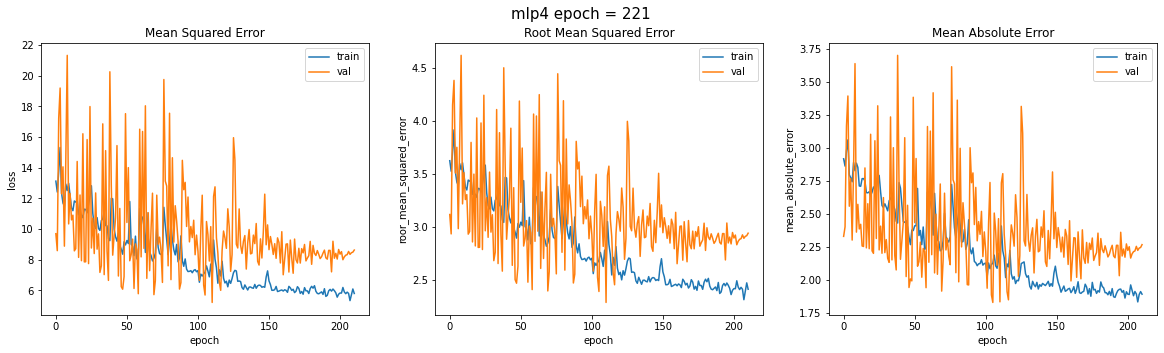

In [22]:
vis_results('mlp4', history_mlp4, epochs_mlp4)

In [23]:
results.update({'mlp4': eval_mlp4[1:]})

### cnn_vgg

In [24]:
eval_vgg, history_vgg, epochs_vgg = model_history(cnn_vgg, '/tmp/vgg.h5', 0.001)

pooling layers: 4
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           13888     
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 50, 64)           0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 50, 128)           24704     
                                                                 
 conv1d_7 (Conv1D)           (None, 50, 128)           49280     
                                         

Epoch 11/1000
10/10 [==============================] - ETA: 0s - loss: 10.6284 - mean_squared_error: 10.6284 - rmse: 3.2601 - mean_absolute_error: 2.6292
Epoch 00011: val_loss improved from 8.37039 to 7.87905, saving model to /tmp/vgg.h5
10/10 [==============================] - 4s 416ms/step - loss: 10.6284 - mean_squared_error: 10.6284 - rmse: 3.2601 - mean_absolute_error: 2.6292 - val_loss: 7.8790 - val_mean_squared_error: 7.8790 - val_rmse: 2.8070 - val_mean_absolute_error: 2.2587 - lr: 0.0010
Epoch 12/1000
10/10 [==============================] - ETA: 0s - loss: 10.5503 - mean_squared_error: 10.5503 - rmse: 3.2481 - mean_absolute_error: 2.6052
Epoch 00012: val_loss did not improve from 7.87905
10/10 [==============================] - 4s 384ms/step - loss: 10.5503 - mean_squared_error: 10.5503 - rmse: 3.2481 - mean_absolute_error: 2.6052 - val_loss: 15.7422 - val_mean_squared_error: 15.7422 - val_rmse: 3.9677 - val_mean_absolute_error: 3.0254 - lr: 0.0010
Epoch 13/1000
10/10 [======

10/10 [==============================] - ETA: 0s - loss: 7.0111 - mean_squared_error: 7.0111 - rmse: 2.6478 - mean_absolute_error: 2.0974
Epoch 00028: val_loss did not improve from 6.63702
10/10 [==============================] - 4s 436ms/step - loss: 7.0111 - mean_squared_error: 7.0111 - rmse: 2.6478 - mean_absolute_error: 2.0974 - val_loss: 6.9703 - val_mean_squared_error: 6.9703 - val_rmse: 2.6401 - val_mean_absolute_error: 2.1843 - lr: 0.0010
Epoch 29/1000
10/10 [==============================] - ETA: 0s - loss: 7.0028 - mean_squared_error: 7.0028 - rmse: 2.6463 - mean_absolute_error: 2.0869
Epoch 00029: val_loss improved from 6.63702 to 6.42985, saving model to /tmp/vgg.h5
10/10 [==============================] - 4s 437ms/step - loss: 7.0028 - mean_squared_error: 7.0028 - rmse: 2.6463 - mean_absolute_error: 2.0869 - val_loss: 6.4299 - val_mean_squared_error: 6.4299 - val_rmse: 2.5357 - val_mean_absolute_error: 1.9038 - lr: 0.0010
Epoch 30/1000
10/10 [==============================

10/10 [==============================] - ETA: 0s - loss: 3.8722 - mean_squared_error: 3.8722 - rmse: 1.9678 - mean_absolute_error: 1.5322
Epoch 00045: val_loss did not improve from 4.50692
10/10 [==============================] - 9s 870ms/step - loss: 3.8722 - mean_squared_error: 3.8722 - rmse: 1.9678 - mean_absolute_error: 1.5322 - val_loss: 4.8436 - val_mean_squared_error: 4.8436 - val_rmse: 2.2008 - val_mean_absolute_error: 1.6524 - lr: 0.0010
Epoch 46/1000
10/10 [==============================] - ETA: 0s - loss: 3.8419 - mean_squared_error: 3.8419 - rmse: 1.9601 - mean_absolute_error: 1.5182
Epoch 00046: val_loss improved from 4.50692 to 4.48005, saving model to /tmp/vgg.h5
10/10 [==============================] - 7s 701ms/step - loss: 3.8419 - mean_squared_error: 3.8419 - rmse: 1.9601 - mean_absolute_error: 1.5182 - val_loss: 4.4800 - val_mean_squared_error: 4.4800 - val_rmse: 2.1166 - val_mean_absolute_error: 1.6441 - lr: 0.0010
Epoch 47/1000
10/10 [==============================

Epoch 63/1000
10/10 [==============================] - ETA: 0s - loss: 3.1335 - mean_squared_error: 3.1335 - rmse: 1.7702 - mean_absolute_error: 1.3767
Epoch 00063: val_loss did not improve from 4.32127
10/10 [==============================] - 4s 399ms/step - loss: 3.1335 - mean_squared_error: 3.1335 - rmse: 1.7702 - mean_absolute_error: 1.3767 - val_loss: 4.4469 - val_mean_squared_error: 4.4469 - val_rmse: 2.1088 - val_mean_absolute_error: 1.6314 - lr: 0.0010
Epoch 64/1000
10/10 [==============================] - ETA: 0s - loss: 3.2192 - mean_squared_error: 3.2192 - rmse: 1.7942 - mean_absolute_error: 1.3692
Epoch 00064: val_loss improved from 4.32127 to 4.23409, saving model to /tmp/vgg.h5
10/10 [==============================] - 4s 411ms/step - loss: 3.2192 - mean_squared_error: 3.2192 - rmse: 1.7942 - mean_absolute_error: 1.3692 - val_loss: 4.2341 - val_mean_squared_error: 4.2341 - val_rmse: 2.0577 - val_mean_absolute_error: 1.5946 - lr: 0.0010
Epoch 65/1000
10/10 [================

Epoch 81/1000
10/10 [==============================] - ETA: 0s - loss: 2.2372 - mean_squared_error: 2.2372 - rmse: 1.4957 - mean_absolute_error: 1.1694
Epoch 00081: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 373ms/step - loss: 2.2372 - mean_squared_error: 2.2372 - rmse: 1.4957 - mean_absolute_error: 1.1694 - val_loss: 4.8624 - val_mean_squared_error: 4.8624 - val_rmse: 2.2051 - val_mean_absolute_error: 1.6456 - lr: 0.0010
Epoch 82/1000
10/10 [==============================] - ETA: 0s - loss: 2.1424 - mean_squared_error: 2.1424 - rmse: 1.4637 - mean_absolute_error: 1.1504
Epoch 00082: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 362ms/step - loss: 2.1424 - mean_squared_error: 2.1424 - rmse: 1.4637 - mean_absolute_error: 1.1504 - val_loss: 4.7264 - val_mean_squared_error: 4.7264 - val_rmse: 2.1740 - val_mean_absolute_error: 1.6454 - lr: 0.0010
Epoch 83/1000
10/10 [==============================] - ETA: 0s - loss:

Epoch 99/1000
10/10 [==============================] - ETA: 0s - loss: 1.3254 - mean_squared_error: 1.3254 - rmse: 1.1513 - mean_absolute_error: 0.8825
Epoch 00099: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 403ms/step - loss: 1.3254 - mean_squared_error: 1.3254 - rmse: 1.1513 - mean_absolute_error: 0.8825 - val_loss: 4.7452 - val_mean_squared_error: 4.7452 - val_rmse: 2.1784 - val_mean_absolute_error: 1.6620 - lr: 5.0000e-04
Epoch 100/1000
10/10 [==============================] - ETA: 0s - loss: 1.0713 - mean_squared_error: 1.0713 - rmse: 1.0351 - mean_absolute_error: 0.7866
Epoch 00100: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 382ms/step - loss: 1.0713 - mean_squared_error: 1.0713 - rmse: 1.0351 - mean_absolute_error: 0.7866 - val_loss: 5.1925 - val_mean_squared_error: 5.1925 - val_rmse: 2.2787 - val_mean_absolute_error: 1.7544 - lr: 5.0000e-04
Epoch 101/1000
10/10 [==============================] - ETA: 

10/10 [==============================] - ETA: 0s - loss: 0.7233 - mean_squared_error: 0.7233 - rmse: 0.8505 - mean_absolute_error: 0.6505
Epoch 00116: val_loss did not improve from 4.23409
10/10 [==============================] - 6s 574ms/step - loss: 0.7233 - mean_squared_error: 0.7233 - rmse: 0.8505 - mean_absolute_error: 0.6505 - val_loss: 4.9936 - val_mean_squared_error: 4.9936 - val_rmse: 2.2346 - val_mean_absolute_error: 1.6984 - lr: 2.5000e-04
Epoch 117/1000
10/10 [==============================] - ETA: 0s - loss: 0.7509 - mean_squared_error: 0.7509 - rmse: 0.8665 - mean_absolute_error: 0.6661
Epoch 00117: val_loss did not improve from 4.23409
10/10 [==============================] - 5s 468ms/step - loss: 0.7509 - mean_squared_error: 0.7509 - rmse: 0.8665 - mean_absolute_error: 0.6661 - val_loss: 4.6864 - val_mean_squared_error: 4.6864 - val_rmse: 2.1648 - val_mean_absolute_error: 1.6468 - lr: 2.5000e-04
Epoch 118/1000
10/10 [==============================] - ETA: 0s - loss: 1.0

10/10 [==============================] - ETA: 0s - loss: 0.7081 - mean_squared_error: 0.7081 - rmse: 0.8415 - mean_absolute_error: 0.6381
Epoch 00133: val_loss did not improve from 4.23409
10/10 [==============================] - 5s 453ms/step - loss: 0.7081 - mean_squared_error: 0.7081 - rmse: 0.8415 - mean_absolute_error: 0.6381 - val_loss: 4.7291 - val_mean_squared_error: 4.7291 - val_rmse: 2.1746 - val_mean_absolute_error: 1.6530 - lr: 1.2500e-04
Epoch 134/1000
10/10 [==============================] - ETA: 0s - loss: 0.7346 - mean_squared_error: 0.7346 - rmse: 0.8571 - mean_absolute_error: 0.6624
Epoch 00134: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 401ms/step - loss: 0.7346 - mean_squared_error: 0.7346 - rmse: 0.8571 - mean_absolute_error: 0.6624 - val_loss: 4.6845 - val_mean_squared_error: 4.6845 - val_rmse: 2.1644 - val_mean_absolute_error: 1.6411 - lr: 1.2500e-04
Epoch 135/1000
10/10 [==============================] - ETA: 0s - loss: 0.8

10/10 [==============================] - ETA: 0s - loss: 0.5477 - mean_squared_error: 0.5477 - rmse: 0.7401 - mean_absolute_error: 0.5713
Epoch 00150: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 408ms/step - loss: 0.5477 - mean_squared_error: 0.5477 - rmse: 0.7401 - mean_absolute_error: 0.5713 - val_loss: 4.9223 - val_mean_squared_error: 4.9223 - val_rmse: 2.2186 - val_mean_absolute_error: 1.6830 - lr: 6.2500e-05
Epoch 151/1000
10/10 [==============================] - ETA: 0s - loss: 0.5551 - mean_squared_error: 0.5551 - rmse: 0.7450 - mean_absolute_error: 0.5744
Epoch 00151: val_loss did not improve from 4.23409
10/10 [==============================] - 4s 396ms/step - loss: 0.5551 - mean_squared_error: 0.5551 - rmse: 0.7450 - mean_absolute_error: 0.5744 - val_loss: 4.8186 - val_mean_squared_error: 4.8186 - val_rmse: 2.1951 - val_mean_absolute_error: 1.6597 - lr: 6.2500e-05
Epoch 152/1000
10/10 [==============================] - ETA: 0s - loss: 0.5

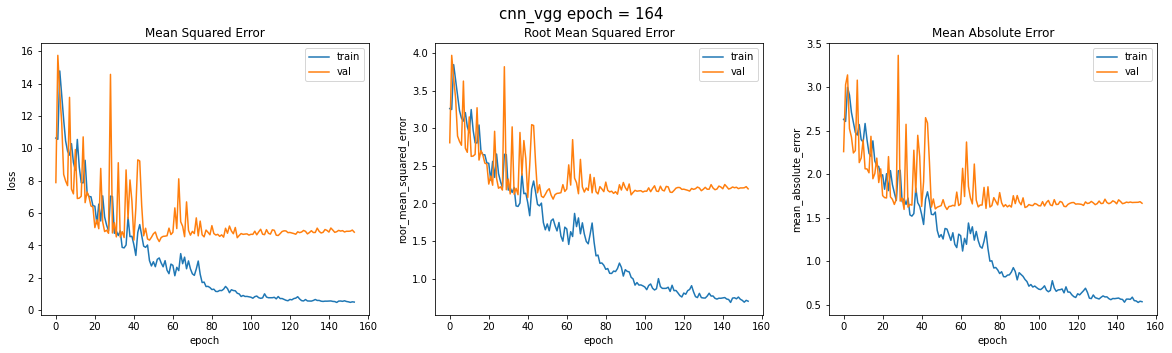

In [25]:
vis_results('cnn_vgg', history_vgg, epochs_vgg)

In [26]:
results.update({'cnn_vgg': eval_vgg[1:]})

### lstm1v0

In [27]:
eval_lstm1v0, history_lstm1v0, epochs_lstm1v0 = model_history(lstm1v0, '/tmp/lstm1v0.h5', 0.01)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 lstm (LSTM)                 (None, 512)               1198080   
                                                                 
 dense_10 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,198,593
Trainable params: 1,198,593
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 27.2894 - mean_squared_error: 27.2894 - rmse: 5.2239 - mean_absolute_error: 3.9748
Epoch 00001: val_loss improved from inf to 11.05307, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 19s 1s/step - loss: 27.2894 - mean

10/10 [==============================] - ETA: 0s - loss: 11.7446 - mean_squared_error: 11.7446 - rmse: 3.4270 - mean_absolute_error: 2.7561
Epoch 00016: val_loss improved from 10.49323 to 10.36895, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 11s 1s/step - loss: 11.7446 - mean_squared_error: 11.7446 - rmse: 3.4270 - mean_absolute_error: 2.7561 - val_loss: 10.3690 - val_mean_squared_error: 10.3690 - val_rmse: 3.2201 - val_mean_absolute_error: 2.7372 - lr: 0.0100
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 11.7573 - mean_squared_error: 11.7573 - rmse: 3.4289 - mean_absolute_error: 2.7874
Epoch 00017: val_loss improved from 10.36895 to 10.26406, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 11s 1s/step - loss: 11.7573 - mean_squared_error: 11.7573 - rmse: 3.4289 - mean_absolute_error: 2.7874 - val_loss: 10.2641 - val_mean_squared_error: 10.2641 - val_rmse: 3.2038 - val_mean_absolute_error: 2.4172 - lr: 0.010

10/10 [==============================] - ETA: 0s - loss: 9.8026 - mean_squared_error: 9.8026 - rmse: 3.1309 - mean_absolute_error: 2.4982 
Epoch 00033: val_loss did not improve from 8.07501
10/10 [==============================] - 10s 955ms/step - loss: 9.8026 - mean_squared_error: 9.8026 - rmse: 3.1309 - mean_absolute_error: 2.4982 - val_loss: 11.8071 - val_mean_squared_error: 11.8071 - val_rmse: 3.4361 - val_mean_absolute_error: 2.8789 - lr: 0.0100
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 10.4086 - mean_squared_error: 10.4086 - rmse: 3.2262 - mean_absolute_error: 2.5717
Epoch 00034: val_loss improved from 8.07501 to 7.71784, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 10s 1s/step - loss: 10.4086 - mean_squared_error: 10.4086 - rmse: 3.2262 - mean_absolute_error: 2.5717 - val_loss: 7.7178 - val_mean_squared_error: 7.7178 - val_rmse: 2.7781 - val_mean_absolute_error: 2.3076 - lr: 0.0100
Epoch 35/1000
10/10 [====================

10/10 [==============================] - ETA: 0s - loss: 8.4094 - mean_squared_error: 8.4094 - rmse: 2.8999 - mean_absolute_error: 2.2883
Epoch 00050: val_loss did not improve from 6.59236
10/10 [==============================] - 10s 1s/step - loss: 8.4094 - mean_squared_error: 8.4094 - rmse: 2.8999 - mean_absolute_error: 2.2883 - val_loss: 7.4977 - val_mean_squared_error: 7.4977 - val_rmse: 2.7382 - val_mean_absolute_error: 2.2592 - lr: 0.0100
Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 7.7857 - mean_squared_error: 7.7857 - rmse: 2.7903 - mean_absolute_error: 2.2395
Epoch 00051: val_loss improved from 6.59236 to 6.33225, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 10s 983ms/step - loss: 7.7857 - mean_squared_error: 7.7857 - rmse: 2.7903 - mean_absolute_error: 2.2395 - val_loss: 6.3323 - val_mean_squared_error: 6.3323 - val_rmse: 2.5164 - val_mean_absolute_error: 2.0246 - lr: 0.0100
Epoch 52/1000
10/10 [===========================

Epoch 68/1000
10/10 [==============================] - ETA: 0s - loss: 8.0996 - mean_squared_error: 8.0996 - rmse: 2.8460 - mean_absolute_error: 2.2310
Epoch 00068: val_loss did not improve from 5.98057
10/10 [==============================] - 10s 975ms/step - loss: 8.0996 - mean_squared_error: 8.0996 - rmse: 2.8460 - mean_absolute_error: 2.2310 - val_loss: 6.0937 - val_mean_squared_error: 6.0937 - val_rmse: 2.4685 - val_mean_absolute_error: 1.9464 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 7.7010 - mean_squared_error: 7.7010 - rmse: 2.7751 - mean_absolute_error: 2.1963
Epoch 00069: val_loss did not improve from 5.98057
10/10 [==============================] - 10s 975ms/step - loss: 7.7010 - mean_squared_error: 7.7010 - rmse: 2.7751 - mean_absolute_error: 2.1963 - val_loss: 6.2096 - val_mean_squared_error: 6.2096 - val_rmse: 2.4919 - val_mean_absolute_error: 2.0116 - lr: 0.0100
Epoch 70/1000
10/10 [==============================] - ETA: 0s - los

Epoch 86/1000
10/10 [==============================] - ETA: 0s - loss: 7.1473 - mean_squared_error: 7.1473 - rmse: 2.6734 - mean_absolute_error: 2.1235
Epoch 00086: val_loss improved from 5.80218 to 5.61431, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 11s 1s/step - loss: 7.1473 - mean_squared_error: 7.1473 - rmse: 2.6734 - mean_absolute_error: 2.1235 - val_loss: 5.6143 - val_mean_squared_error: 5.6143 - val_rmse: 2.3695 - val_mean_absolute_error: 1.8626 - lr: 0.0100
Epoch 87/1000
10/10 [==============================] - ETA: 0s - loss: 7.0063 - mean_squared_error: 7.0063 - rmse: 2.6469 - mean_absolute_error: 2.0849
Epoch 00087: val_loss did not improve from 5.61431
10/10 [==============================] - 10s 1s/step - loss: 7.0063 - mean_squared_error: 7.0063 - rmse: 2.6469 - mean_absolute_error: 2.0849 - val_loss: 5.7053 - val_mean_squared_error: 5.7053 - val_rmse: 2.3886 - val_mean_absolute_error: 1.9100 - lr: 0.0100
Epoch 88/1000
10/10 [================

Epoch 104/1000
10/10 [==============================] - ETA: 0s - loss: 7.2096 - mean_squared_error: 7.2096 - rmse: 2.6851 - mean_absolute_error: 2.1247
Epoch 00104: val_loss improved from 5.40973 to 5.40918, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 10s 967ms/step - loss: 7.2096 - mean_squared_error: 7.2096 - rmse: 2.6851 - mean_absolute_error: 2.1247 - val_loss: 5.4092 - val_mean_squared_error: 5.4092 - val_rmse: 2.3258 - val_mean_absolute_error: 1.8437 - lr: 0.0100
Epoch 105/1000
10/10 [==============================] - ETA: 0s - loss: 6.9678 - mean_squared_error: 6.9678 - rmse: 2.6397 - mean_absolute_error: 2.0986
Epoch 00105: val_loss did not improve from 5.40918
10/10 [==============================] - 9s 954ms/step - loss: 6.9678 - mean_squared_error: 6.9678 - rmse: 2.6397 - mean_absolute_error: 2.0986 - val_loss: 6.2566 - val_mean_squared_error: 6.2566 - val_rmse: 2.5013 - val_mean_absolute_error: 1.9306 - lr: 0.0100
Epoch 106/1000
10/10 [========

Epoch 122/1000
10/10 [==============================] - ETA: 0s - loss: 6.6342 - mean_squared_error: 6.6342 - rmse: 2.5757 - mean_absolute_error: 2.0240
Epoch 00122: val_loss did not improve from 5.16427
10/10 [==============================] - 11s 1s/step - loss: 6.6342 - mean_squared_error: 6.6342 - rmse: 2.5757 - mean_absolute_error: 2.0240 - val_loss: 5.1893 - val_mean_squared_error: 5.1893 - val_rmse: 2.2780 - val_mean_absolute_error: 1.7797 - lr: 0.0100
Epoch 123/1000
10/10 [==============================] - ETA: 0s - loss: 6.2070 - mean_squared_error: 6.2070 - rmse: 2.4914 - mean_absolute_error: 1.9318
Epoch 00123: val_loss improved from 5.16427 to 5.03253, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 12s 1s/step - loss: 6.2070 - mean_squared_error: 6.2070 - rmse: 2.4914 - mean_absolute_error: 1.9318 - val_loss: 5.0325 - val_mean_squared_error: 5.0325 - val_rmse: 2.2433 - val_mean_absolute_error: 1.7655 - lr: 0.0100
Epoch 124/1000
10/10 [=============

Epoch 140/1000
10/10 [==============================] - ETA: 0s - loss: 6.6864 - mean_squared_error: 6.6864 - rmse: 2.5858 - mean_absolute_error: 2.0545
Epoch 00140: val_loss did not improve from 5.03253
10/10 [==============================] - 10s 987ms/step - loss: 6.6864 - mean_squared_error: 6.6864 - rmse: 2.5858 - mean_absolute_error: 2.0545 - val_loss: 6.1174 - val_mean_squared_error: 6.1174 - val_rmse: 2.4733 - val_mean_absolute_error: 1.9082 - lr: 0.0100
Epoch 141/1000
10/10 [==============================] - ETA: 0s - loss: 6.8059 - mean_squared_error: 6.8059 - rmse: 2.6088 - mean_absolute_error: 2.0446
Epoch 00141: val_loss did not improve from 5.03253
10/10 [==============================] - 10s 1s/step - loss: 6.8059 - mean_squared_error: 6.8059 - rmse: 2.6088 - mean_absolute_error: 2.0446 - val_loss: 5.4948 - val_mean_squared_error: 5.4948 - val_rmse: 2.3441 - val_mean_absolute_error: 1.8785 - lr: 0.0100
Epoch 142/1000
10/10 [==============================] - ETA: 0s - los

Epoch 158/1000
10/10 [==============================] - ETA: 0s - loss: 6.3915 - mean_squared_error: 6.3915 - rmse: 2.5281 - mean_absolute_error: 1.9827
Epoch 00158: val_loss did not improve from 4.98805
10/10 [==============================] - 12s 1s/step - loss: 6.3915 - mean_squared_error: 6.3915 - rmse: 2.5281 - mean_absolute_error: 1.9827 - val_loss: 5.2091 - val_mean_squared_error: 5.2091 - val_rmse: 2.2823 - val_mean_absolute_error: 1.8283 - lr: 0.0050
Epoch 159/1000
10/10 [==============================] - ETA: 0s - loss: 6.3200 - mean_squared_error: 6.3200 - rmse: 2.5140 - mean_absolute_error: 1.9729
Epoch 00159: val_loss did not improve from 4.98805
10/10 [==============================] - 14s 1s/step - loss: 6.3200 - mean_squared_error: 6.3200 - rmse: 2.5140 - mean_absolute_error: 1.9729 - val_loss: 5.8163 - val_mean_squared_error: 5.8163 - val_rmse: 2.4117 - val_mean_absolute_error: 1.8625 - lr: 0.0050
Epoch 160/1000
10/10 [==============================] - ETA: 0s - loss: 

Epoch 176/1000
10/10 [==============================] - ETA: 0s - loss: 6.6903 - mean_squared_error: 6.6903 - rmse: 2.5866 - mean_absolute_error: 2.0660
Epoch 00176: val_loss did not improve from 4.79753
10/10 [==============================] - 10s 999ms/step - loss: 6.6903 - mean_squared_error: 6.6903 - rmse: 2.5866 - mean_absolute_error: 2.0660 - val_loss: 6.6504 - val_mean_squared_error: 6.6504 - val_rmse: 2.5788 - val_mean_absolute_error: 1.9795 - lr: 0.0050
Epoch 177/1000
10/10 [==============================] - ETA: 0s - loss: 7.0623 - mean_squared_error: 7.0623 - rmse: 2.6575 - mean_absolute_error: 2.0432
Epoch 00177: val_loss did not improve from 4.79753
10/10 [==============================] - 10s 1s/step - loss: 7.0623 - mean_squared_error: 7.0623 - rmse: 2.6575 - mean_absolute_error: 2.0432 - val_loss: 5.0824 - val_mean_squared_error: 5.0824 - val_rmse: 2.2544 - val_mean_absolute_error: 1.7462 - lr: 0.0050
Epoch 178/1000
10/10 [==============================] - ETA: 0s - los

Epoch 194/1000
10/10 [==============================] - ETA: 0s - loss: 6.1636 - mean_squared_error: 6.1636 - rmse: 2.4827 - mean_absolute_error: 1.9377
Epoch 00194: val_loss did not improve from 4.74167
10/10 [==============================] - 10s 986ms/step - loss: 6.1636 - mean_squared_error: 6.1636 - rmse: 2.4827 - mean_absolute_error: 1.9377 - val_loss: 6.0821 - val_mean_squared_error: 6.0821 - val_rmse: 2.4662 - val_mean_absolute_error: 2.0191 - lr: 0.0050
Epoch 195/1000
10/10 [==============================] - ETA: 0s - loss: 6.1961 - mean_squared_error: 6.1961 - rmse: 2.4892 - mean_absolute_error: 1.9528
Epoch 00195: val_loss did not improve from 4.74167
10/10 [==============================] - 10s 965ms/step - loss: 6.1961 - mean_squared_error: 6.1961 - rmse: 2.4892 - mean_absolute_error: 1.9528 - val_loss: 4.9958 - val_mean_squared_error: 4.9958 - val_rmse: 2.2351 - val_mean_absolute_error: 1.7296 - lr: 0.0050
Epoch 196/1000
10/10 [==============================] - ETA: 0s - 

Epoch 212/1000
10/10 [==============================] - ETA: 0s - loss: 6.4208 - mean_squared_error: 6.4208 - rmse: 2.5339 - mean_absolute_error: 1.9699
Epoch 00212: val_loss improved from 4.69888 to 4.66444, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 11s 1s/step - loss: 6.4208 - mean_squared_error: 6.4208 - rmse: 2.5339 - mean_absolute_error: 1.9699 - val_loss: 4.6644 - val_mean_squared_error: 4.6644 - val_rmse: 2.1597 - val_mean_absolute_error: 1.7020 - lr: 0.0050
Epoch 213/1000
10/10 [==============================] - ETA: 0s - loss: 5.7254 - mean_squared_error: 5.7254 - rmse: 2.3928 - mean_absolute_error: 1.8836
Epoch 00213: val_loss did not improve from 4.66444
10/10 [==============================] - 10s 1s/step - loss: 5.7254 - mean_squared_error: 5.7254 - rmse: 2.3928 - mean_absolute_error: 1.8836 - val_loss: 4.6735 - val_mean_squared_error: 4.6735 - val_rmse: 2.1618 - val_mean_absolute_error: 1.7049 - lr: 0.0050
Epoch 214/1000
10/10 [=============

10/10 [==============================] - ETA: 0s - loss: 5.3703 - mean_squared_error: 5.3703 - rmse: 2.3174 - mean_absolute_error: 1.7884
Epoch 00229: val_loss did not improve from 4.53239
10/10 [==============================] - 11s 1s/step - loss: 5.3703 - mean_squared_error: 5.3703 - rmse: 2.3174 - mean_absolute_error: 1.7884 - val_loss: 4.5803 - val_mean_squared_error: 4.5803 - val_rmse: 2.1402 - val_mean_absolute_error: 1.6732 - lr: 0.0050
Epoch 230/1000
10/10 [==============================] - ETA: 0s - loss: 5.5637 - mean_squared_error: 5.5637 - rmse: 2.3588 - mean_absolute_error: 1.8370
Epoch 00230: val_loss did not improve from 4.53239
10/10 [==============================] - 10s 1s/step - loss: 5.5637 - mean_squared_error: 5.5637 - rmse: 2.3588 - mean_absolute_error: 1.8370 - val_loss: 5.0811 - val_mean_squared_error: 5.0811 - val_rmse: 2.2541 - val_mean_absolute_error: 1.7875 - lr: 0.0050
Epoch 231/1000
10/10 [==============================] - ETA: 0s - loss: 5.4320 - mean_s

Epoch 247/1000
10/10 [==============================] - ETA: 0s - loss: 5.4681 - mean_squared_error: 5.4681 - rmse: 2.3384 - mean_absolute_error: 1.8217
Epoch 00247: val_loss did not improve from 4.48281
10/10 [==============================] - 9s 958ms/step - loss: 5.4681 - mean_squared_error: 5.4681 - rmse: 2.3384 - mean_absolute_error: 1.8217 - val_loss: 6.2558 - val_mean_squared_error: 6.2558 - val_rmse: 2.5012 - val_mean_absolute_error: 2.0558 - lr: 0.0050
Epoch 248/1000
10/10 [==============================] - ETA: 0s - loss: 5.9912 - mean_squared_error: 5.9912 - rmse: 2.4477 - mean_absolute_error: 1.9111
Epoch 00248: val_loss did not improve from 4.48281
10/10 [==============================] - 10s 987ms/step - loss: 5.9912 - mean_squared_error: 5.9912 - rmse: 2.4477 - mean_absolute_error: 1.9111 - val_loss: 6.7882 - val_mean_squared_error: 6.7882 - val_rmse: 2.6054 - val_mean_absolute_error: 2.1823 - lr: 0.0050
Epoch 249/1000
10/10 [==============================] - ETA: 0s - l

10/10 [==============================] - ETA: 0s - loss: 5.3362 - mean_squared_error: 5.3362 - rmse: 2.3100 - mean_absolute_error: 1.7987
Epoch 00264: val_loss did not improve from 4.32465
10/10 [==============================] - 11s 1s/step - loss: 5.3362 - mean_squared_error: 5.3362 - rmse: 2.3100 - mean_absolute_error: 1.7987 - val_loss: 4.6901 - val_mean_squared_error: 4.6901 - val_rmse: 2.1657 - val_mean_absolute_error: 1.7107 - lr: 0.0050
Epoch 265/1000
10/10 [==============================] - ETA: 0s - loss: 5.3707 - mean_squared_error: 5.3707 - rmse: 2.3175 - mean_absolute_error: 1.7861
Epoch 00265: val_loss did not improve from 4.32465
10/10 [==============================] - 10s 1s/step - loss: 5.3707 - mean_squared_error: 5.3707 - rmse: 2.3175 - mean_absolute_error: 1.7861 - val_loss: 7.6664 - val_mean_squared_error: 7.6664 - val_rmse: 2.7688 - val_mean_absolute_error: 2.3305 - lr: 0.0050
Epoch 266/1000
10/10 [==============================] - ETA: 0s - loss: 6.6612 - mean_s

Epoch 282/1000
10/10 [==============================] - ETA: 0s - loss: 5.2001 - mean_squared_error: 5.2001 - rmse: 2.2804 - mean_absolute_error: 1.7749
Epoch 00282: val_loss did not improve from 4.18999
10/10 [==============================] - 9s 899ms/step - loss: 5.2001 - mean_squared_error: 5.2001 - rmse: 2.2804 - mean_absolute_error: 1.7749 - val_loss: 4.2096 - val_mean_squared_error: 4.2096 - val_rmse: 2.0517 - val_mean_absolute_error: 1.6119 - lr: 0.0050
Epoch 283/1000
10/10 [==============================] - ETA: 0s - loss: 5.1539 - mean_squared_error: 5.1539 - rmse: 2.2702 - mean_absolute_error: 1.7707
Epoch 00283: val_loss did not improve from 4.18999
10/10 [==============================] - 9s 929ms/step - loss: 5.1539 - mean_squared_error: 5.1539 - rmse: 2.2702 - mean_absolute_error: 1.7707 - val_loss: 4.2107 - val_mean_squared_error: 4.2107 - val_rmse: 2.0520 - val_mean_absolute_error: 1.6115 - lr: 0.0050
Epoch 284/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 300/1000
10/10 [==============================] - ETA: 0s - loss: 5.6329 - mean_squared_error: 5.6329 - rmse: 2.3734 - mean_absolute_error: 1.8404
Epoch 00300: val_loss did not improve from 4.18999
10/10 [==============================] - 9s 884ms/step - loss: 5.6329 - mean_squared_error: 5.6329 - rmse: 2.3734 - mean_absolute_error: 1.8404 - val_loss: 4.2398 - val_mean_squared_error: 4.2398 - val_rmse: 2.0591 - val_mean_absolute_error: 1.6135 - lr: 0.0050
Epoch 301/1000
10/10 [==============================] - ETA: 0s - loss: 5.4990 - mean_squared_error: 5.4990 - rmse: 2.3450 - mean_absolute_error: 1.8428
Epoch 00301: val_loss did not improve from 4.18999

Epoch 00301: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
10/10 [==============================] - 9s 920ms/step - loss: 5.4990 - mean_squared_error: 5.4990 - rmse: 2.3450 - mean_absolute_error: 1.8428 - val_loss: 5.7927 - val_mean_squared_error: 5.7927 - val_rmse: 2.4068 - val_mean_absolute_error: 1.9521 

10/10 [==============================] - ETA: 0s - loss: 4.9079 - mean_squared_error: 4.9079 - rmse: 2.2154 - mean_absolute_error: 1.7117
Epoch 00317: val_loss did not improve from 4.11032
10/10 [==============================] - 9s 918ms/step - loss: 4.9079 - mean_squared_error: 4.9079 - rmse: 2.2154 - mean_absolute_error: 1.7117 - val_loss: 4.3980 - val_mean_squared_error: 4.3980 - val_rmse: 2.0971 - val_mean_absolute_error: 1.6646 - lr: 0.0025
Epoch 318/1000
10/10 [==============================] - ETA: 0s - loss: 4.9101 - mean_squared_error: 4.9101 - rmse: 2.2159 - mean_absolute_error: 1.7283
Epoch 00318: val_loss did not improve from 4.11032
10/10 [==============================] - 9s 885ms/step - loss: 4.9101 - mean_squared_error: 4.9101 - rmse: 2.2159 - mean_absolute_error: 1.7283 - val_loss: 4.3889 - val_mean_squared_error: 4.3889 - val_rmse: 2.0950 - val_mean_absolute_error: 1.6642 - lr: 0.0025
Epoch 319/1000
10/10 [==============================] - ETA: 0s - loss: 4.8696 - me

10/10 [==============================] - ETA: 0s - loss: 4.7760 - mean_squared_error: 4.7760 - rmse: 2.1854 - mean_absolute_error: 1.6749
Epoch 00334: val_loss did not improve from 4.02380
10/10 [==============================] - 9s 879ms/step - loss: 4.7760 - mean_squared_error: 4.7760 - rmse: 2.1854 - mean_absolute_error: 1.6749 - val_loss: 4.3332 - val_mean_squared_error: 4.3332 - val_rmse: 2.0816 - val_mean_absolute_error: 1.6393 - lr: 0.0025
Epoch 335/1000
10/10 [==============================] - ETA: 0s - loss: 4.7848 - mean_squared_error: 4.7848 - rmse: 2.1874 - mean_absolute_error: 1.6776
Epoch 00335: val_loss did not improve from 4.02380
10/10 [==============================] - 9s 883ms/step - loss: 4.7848 - mean_squared_error: 4.7848 - rmse: 2.1874 - mean_absolute_error: 1.6776 - val_loss: 4.8779 - val_mean_squared_error: 4.8779 - val_rmse: 2.2086 - val_mean_absolute_error: 1.7777 - lr: 0.0025
Epoch 336/1000
10/10 [==============================] - ETA: 0s - loss: 5.0911 - me

Epoch 352/1000
10/10 [==============================] - ETA: 0s - loss: 4.7710 - mean_squared_error: 4.7710 - rmse: 2.1843 - mean_absolute_error: 1.6716
Epoch 00352: val_loss did not improve from 3.97431
10/10 [==============================] - 9s 875ms/step - loss: 4.7710 - mean_squared_error: 4.7710 - rmse: 2.1843 - mean_absolute_error: 1.6716 - val_loss: 3.9772 - val_mean_squared_error: 3.9772 - val_rmse: 1.9943 - val_mean_absolute_error: 1.5876 - lr: 0.0025
Epoch 353/1000
10/10 [==============================] - ETA: 0s - loss: 4.7260 - mean_squared_error: 4.7260 - rmse: 2.1739 - mean_absolute_error: 1.6948
Epoch 00353: val_loss did not improve from 3.97431
10/10 [==============================] - 9s 885ms/step - loss: 4.7260 - mean_squared_error: 4.7260 - rmse: 2.1739 - mean_absolute_error: 1.6948 - val_loss: 4.0615 - val_mean_squared_error: 4.0615 - val_rmse: 2.0153 - val_mean_absolute_error: 1.5957 - lr: 0.0025
Epoch 354/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 370/1000
10/10 [==============================] - ETA: 0s - loss: 4.5561 - mean_squared_error: 4.5561 - rmse: 2.1345 - mean_absolute_error: 1.6517
Epoch 00370: val_loss improved from 3.90150 to 3.88936, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 10s 1s/step - loss: 4.5561 - mean_squared_error: 4.5561 - rmse: 2.1345 - mean_absolute_error: 1.6517 - val_loss: 3.8894 - val_mean_squared_error: 3.8894 - val_rmse: 1.9721 - val_mean_absolute_error: 1.5583 - lr: 0.0025
Epoch 371/1000
10/10 [==============================] - ETA: 0s - loss: 4.6161 - mean_squared_error: 4.6161 - rmse: 2.1485 - mean_absolute_error: 1.6617
Epoch 00371: val_loss did not improve from 3.88936
10/10 [==============================] - 10s 1s/step - loss: 4.6161 - mean_squared_error: 4.6161 - rmse: 2.1485 - mean_absolute_error: 1.6617 - val_loss: 3.9107 - val_mean_squared_error: 3.9107 - val_rmse: 1.9776 - val_mean_absolute_error: 1.5668 - lr: 0.0025
Epoch 372/1000
10/10 [=============

Epoch 388/1000
10/10 [==============================] - ETA: 0s - loss: 4.7208 - mean_squared_error: 4.7208 - rmse: 2.1727 - mean_absolute_error: 1.6944
Epoch 00388: val_loss did not improve from 3.88936
10/10 [==============================] - 9s 868ms/step - loss: 4.7208 - mean_squared_error: 4.7208 - rmse: 2.1727 - mean_absolute_error: 1.6944 - val_loss: 4.0072 - val_mean_squared_error: 4.0072 - val_rmse: 2.0018 - val_mean_absolute_error: 1.5967 - lr: 0.0025
Epoch 389/1000
10/10 [==============================] - ETA: 0s - loss: 4.5350 - mean_squared_error: 4.5350 - rmse: 2.1296 - mean_absolute_error: 1.6408
Epoch 00389: val_loss did not improve from 3.88936
10/10 [==============================] - 9s 856ms/step - loss: 4.5350 - mean_squared_error: 4.5350 - rmse: 2.1296 - mean_absolute_error: 1.6408 - val_loss: 4.3098 - val_mean_squared_error: 4.3098 - val_rmse: 2.0760 - val_mean_absolute_error: 1.6617 - lr: 0.0025
Epoch 390/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 4.3266 - mean_squared_error: 4.3266 - rmse: 2.0801 - mean_absolute_error: 1.6017
Epoch 00405: val_loss did not improve from 3.82724
10/10 [==============================] - 9s 900ms/step - loss: 4.3266 - mean_squared_error: 4.3266 - rmse: 2.0801 - mean_absolute_error: 1.6017 - val_loss: 4.0982 - val_mean_squared_error: 4.0982 - val_rmse: 2.0244 - val_mean_absolute_error: 1.6138 - lr: 0.0012
Epoch 406/1000
10/10 [==============================] - ETA: 0s - loss: 4.3183 - mean_squared_error: 4.3183 - rmse: 2.0781 - mean_absolute_error: 1.5991
Epoch 00406: val_loss did not improve from 3.82724
10/10 [==============================] - 9s 861ms/step - loss: 4.3183 - mean_squared_error: 4.3183 - rmse: 2.0781 - mean_absolute_error: 1.5991 - val_loss: 4.2593 - val_mean_squared_error: 4.2593 - val_rmse: 2.0638 - val_mean_absolute_error: 1.6490 - lr: 0.0012
Epoch 407/1000
10/10 [==============================] - ETA: 0s - loss: 4.5522 - me

Epoch 423/1000
10/10 [==============================] - ETA: 0s - loss: 4.2382 - mean_squared_error: 4.2382 - rmse: 2.0587 - mean_absolute_error: 1.5990
Epoch 00423: val_loss improved from 3.78829 to 3.77939, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 10s 1s/step - loss: 4.2382 - mean_squared_error: 4.2382 - rmse: 2.0587 - mean_absolute_error: 1.5990 - val_loss: 3.7794 - val_mean_squared_error: 3.7794 - val_rmse: 1.9441 - val_mean_absolute_error: 1.5308 - lr: 0.0012
Epoch 424/1000
10/10 [==============================] - ETA: 0s - loss: 4.2668 - mean_squared_error: 4.2668 - rmse: 2.0656 - mean_absolute_error: 1.5832
Epoch 00424: val_loss did not improve from 3.77939
10/10 [==============================] - 10s 1s/step - loss: 4.2668 - mean_squared_error: 4.2668 - rmse: 2.0656 - mean_absolute_error: 1.5832 - val_loss: 3.9900 - val_mean_squared_error: 3.9900 - val_rmse: 1.9975 - val_mean_absolute_error: 1.5887 - lr: 0.0012
Epoch 425/1000
10/10 [=============

Epoch 441/1000
10/10 [==============================] - ETA: 0s - loss: 4.2440 - mean_squared_error: 4.2440 - rmse: 2.0601 - mean_absolute_error: 1.6104
Epoch 00441: val_loss did not improve from 3.77939
10/10 [==============================] - 8s 859ms/step - loss: 4.2440 - mean_squared_error: 4.2440 - rmse: 2.0601 - mean_absolute_error: 1.6104 - val_loss: 3.7810 - val_mean_squared_error: 3.7810 - val_rmse: 1.9445 - val_mean_absolute_error: 1.5347 - lr: 0.0012
Epoch 442/1000
10/10 [==============================] - ETA: 0s - loss: 4.1502 - mean_squared_error: 4.1502 - rmse: 2.0372 - mean_absolute_error: 1.5786
Epoch 00442: val_loss improved from 3.77939 to 3.77503, saving model to /tmp/lstm1v0.h5
10/10 [==============================] - 9s 894ms/step - loss: 4.1502 - mean_squared_error: 4.1502 - rmse: 2.0372 - mean_absolute_error: 1.5786 - val_loss: 3.7750 - val_mean_squared_error: 3.7750 - val_rmse: 1.9429 - val_mean_absolute_error: 1.5266 - lr: 0.0012
Epoch 443/1000
10/10 [=========

10/10 [==============================] - ETA: 0s - loss: 4.2014 - mean_squared_error: 4.2014 - rmse: 2.0497 - mean_absolute_error: 1.5819
Epoch 00458: val_loss did not improve from 3.76631
10/10 [==============================] - 9s 874ms/step - loss: 4.2014 - mean_squared_error: 4.2014 - rmse: 2.0497 - mean_absolute_error: 1.5819 - val_loss: 4.1320 - val_mean_squared_error: 4.1320 - val_rmse: 2.0327 - val_mean_absolute_error: 1.6281 - lr: 0.0012
Epoch 459/1000
10/10 [==============================] - ETA: 0s - loss: 4.0823 - mean_squared_error: 4.0823 - rmse: 2.0205 - mean_absolute_error: 1.5611
Epoch 00459: val_loss did not improve from 3.76631
10/10 [==============================] - 9s 875ms/step - loss: 4.0823 - mean_squared_error: 4.0823 - rmse: 2.0205 - mean_absolute_error: 1.5611 - val_loss: 3.8073 - val_mean_squared_error: 3.8073 - val_rmse: 1.9512 - val_mean_absolute_error: 1.5418 - lr: 0.0012
Epoch 460/1000
10/10 [==============================] - ETA: 0s - loss: 4.1284 - me

Epoch 476/1000
10/10 [==============================] - ETA: 0s - loss: 4.0260 - mean_squared_error: 4.0260 - rmse: 2.0065 - mean_absolute_error: 1.5529
Epoch 00476: val_loss did not improve from 3.70594
10/10 [==============================] - 9s 942ms/step - loss: 4.0260 - mean_squared_error: 4.0260 - rmse: 2.0065 - mean_absolute_error: 1.5529 - val_loss: 3.7889 - val_mean_squared_error: 3.7889 - val_rmse: 1.9465 - val_mean_absolute_error: 1.5284 - lr: 0.0012
Epoch 477/1000
10/10 [==============================] - ETA: 0s - loss: 4.0265 - mean_squared_error: 4.0265 - rmse: 2.0066 - mean_absolute_error: 1.5573
Epoch 00477: val_loss did not improve from 3.70594
10/10 [==============================] - 8s 845ms/step - loss: 4.0265 - mean_squared_error: 4.0265 - rmse: 2.0066 - mean_absolute_error: 1.5573 - val_loss: 3.7735 - val_mean_squared_error: 3.7735 - val_rmse: 1.9425 - val_mean_absolute_error: 1.5283 - lr: 0.0012
Epoch 478/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 494/1000
10/10 [==============================] - ETA: 0s - loss: 4.1271 - mean_squared_error: 4.1271 - rmse: 2.0315 - mean_absolute_error: 1.5965
Epoch 00494: val_loss did not improve from 3.70055
10/10 [==============================] - 6s 633ms/step - loss: 4.1271 - mean_squared_error: 4.1271 - rmse: 2.0315 - mean_absolute_error: 1.5965 - val_loss: 3.7053 - val_mean_squared_error: 3.7053 - val_rmse: 1.9249 - val_mean_absolute_error: 1.5157 - lr: 0.0012
Epoch 495/1000
10/10 [==============================] - ETA: 0s - loss: 4.1754 - mean_squared_error: 4.1754 - rmse: 2.0434 - mean_absolute_error: 1.5900
Epoch 00495: val_loss did not improve from 3.70055
10/10 [==============================] - 6s 550ms/step - loss: 4.1754 - mean_squared_error: 4.1754 - rmse: 2.0434 - mean_absolute_error: 1.5900 - val_loss: 3.7135 - val_mean_squared_error: 3.7135 - val_rmse: 1.9270 - val_mean_absolute_error: 1.5123 - lr: 0.0012
Epoch 496/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 3.8909 - mean_squared_error: 3.8909 - rmse: 1.9725 - mean_absolute_error: 1.5201
Epoch 00511: val_loss did not improve from 3.69202
10/10 [==============================] - 9s 905ms/step - loss: 3.8909 - mean_squared_error: 3.8909 - rmse: 1.9725 - mean_absolute_error: 1.5201 - val_loss: 3.6956 - val_mean_squared_error: 3.6956 - val_rmse: 1.9224 - val_mean_absolute_error: 1.5221 - lr: 6.2500e-04
Epoch 512/1000
10/10 [==============================] - ETA: 0s - loss: 3.9244 - mean_squared_error: 3.9244 - rmse: 1.9810 - mean_absolute_error: 1.5328
Epoch 00512: val_loss did not improve from 3.69202
10/10 [==============================] - 9s 869ms/step - loss: 3.9244 - mean_squared_error: 3.9244 - rmse: 1.9810 - mean_absolute_error: 1.5328 - val_loss: 3.8120 - val_mean_squared_error: 3.8120 - val_rmse: 1.9524 - val_mean_absolute_error: 1.5527 - lr: 6.2500e-04
Epoch 513/1000
10/10 [==============================] - ETA: 0s - loss: 3.9

Epoch 529/1000
10/10 [==============================] - ETA: 0s - loss: 3.8660 - mean_squared_error: 3.8660 - rmse: 1.9662 - mean_absolute_error: 1.5154
Epoch 00529: val_loss did not improve from 3.69202
10/10 [==============================] - 9s 904ms/step - loss: 3.8660 - mean_squared_error: 3.8660 - rmse: 1.9662 - mean_absolute_error: 1.5154 - val_loss: 3.7697 - val_mean_squared_error: 3.7697 - val_rmse: 1.9416 - val_mean_absolute_error: 1.5367 - lr: 3.1250e-04
Epoch 530/1000
10/10 [==============================] - ETA: 0s - loss: 3.8684 - mean_squared_error: 3.8684 - rmse: 1.9668 - mean_absolute_error: 1.5245
Epoch 00530: val_loss did not improve from 3.69202
10/10 [==============================] - 9s 892ms/step - loss: 3.8684 - mean_squared_error: 3.8684 - rmse: 1.9668 - mean_absolute_error: 1.5245 - val_loss: 3.8322 - val_mean_squared_error: 3.8322 - val_rmse: 1.9576 - val_mean_absolute_error: 1.5464 - lr: 3.1250e-04
Epoch 531/1000
10/10 [==============================] - ETA:

Epoch 547/1000
10/10 [==============================] - ETA: 0s - loss: 3.8667 - mean_squared_error: 3.8667 - rmse: 1.9664 - mean_absolute_error: 1.5124
Epoch 00547: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 946ms/step - loss: 3.8667 - mean_squared_error: 3.8667 - rmse: 1.9664 - mean_absolute_error: 1.5124 - val_loss: 3.7383 - val_mean_squared_error: 3.7383 - val_rmse: 1.9335 - val_mean_absolute_error: 1.5317 - lr: 3.1250e-04
Epoch 548/1000
10/10 [==============================] - ETA: 0s - loss: 3.8957 - mean_squared_error: 3.8957 - rmse: 1.9737 - mean_absolute_error: 1.5406
Epoch 00548: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 883ms/step - loss: 3.8957 - mean_squared_error: 3.8957 - rmse: 1.9737 - mean_absolute_error: 1.5406 - val_loss: 3.8139 - val_mean_squared_error: 3.8139 - val_rmse: 1.9529 - val_mean_absolute_error: 1.5523 - lr: 3.1250e-04
Epoch 549/1000
10/10 [==============================] - ETA:

10/10 [==============================] - ETA: 0s - loss: 3.8283 - mean_squared_error: 3.8283 - rmse: 1.9566 - mean_absolute_error: 1.5106
Epoch 00564: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 910ms/step - loss: 3.8283 - mean_squared_error: 3.8283 - rmse: 1.9566 - mean_absolute_error: 1.5106 - val_loss: 3.7037 - val_mean_squared_error: 3.7037 - val_rmse: 1.9245 - val_mean_absolute_error: 1.5224 - lr: 1.5625e-04
Epoch 565/1000
10/10 [==============================] - ETA: 0s - loss: 3.8491 - mean_squared_error: 3.8491 - rmse: 1.9619 - mean_absolute_error: 1.5086
Epoch 00565: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 938ms/step - loss: 3.8491 - mean_squared_error: 3.8491 - rmse: 1.9619 - mean_absolute_error: 1.5086 - val_loss: 3.7001 - val_mean_squared_error: 3.7001 - val_rmse: 1.9236 - val_mean_absolute_error: 1.5234 - lr: 1.5625e-04
Epoch 566/1000
10/10 [==============================] - ETA: 0s - loss: 3.8

Epoch 582/1000
10/10 [==============================] - ETA: 0s - loss: 3.8155 - mean_squared_error: 3.8155 - rmse: 1.9533 - mean_absolute_error: 1.5107
Epoch 00582: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 885ms/step - loss: 3.8155 - mean_squared_error: 3.8155 - rmse: 1.9533 - mean_absolute_error: 1.5107 - val_loss: 3.7242 - val_mean_squared_error: 3.7242 - val_rmse: 1.9298 - val_mean_absolute_error: 1.5308 - lr: 7.8125e-05
Epoch 583/1000
10/10 [==============================] - ETA: 0s - loss: 3.8103 - mean_squared_error: 3.8103 - rmse: 1.9520 - mean_absolute_error: 1.5042
Epoch 00583: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 879ms/step - loss: 3.8103 - mean_squared_error: 3.8103 - rmse: 1.9520 - mean_absolute_error: 1.5042 - val_loss: 3.7128 - val_mean_squared_error: 3.7128 - val_rmse: 1.9269 - val_mean_absolute_error: 1.5272 - lr: 7.8125e-05
Epoch 584/1000
10/10 [==============================] - ETA:

Epoch 600/1000
10/10 [==============================] - ETA: 0s - loss: 3.8109 - mean_squared_error: 3.8109 - rmse: 1.9522 - mean_absolute_error: 1.5038
Epoch 00600: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 882ms/step - loss: 3.8109 - mean_squared_error: 3.8109 - rmse: 1.9522 - mean_absolute_error: 1.5038 - val_loss: 3.7427 - val_mean_squared_error: 3.7427 - val_rmse: 1.9346 - val_mean_absolute_error: 1.5333 - lr: 7.8125e-05
Epoch 601/1000
10/10 [==============================] - ETA: 0s - loss: 3.8093 - mean_squared_error: 3.8093 - rmse: 1.9517 - mean_absolute_error: 1.5038
Epoch 00601: val_loss did not improve from 3.68244

Epoch 00601: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
10/10 [==============================] - 9s 869ms/step - loss: 3.8093 - mean_squared_error: 3.8093 - rmse: 1.9517 - mean_absolute_error: 1.5038 - val_loss: 3.7606 - val_mean_squared_error: 3.7606 - val_rmse: 1.9392 - val_mean_absolute_error: 1.

10/10 [==============================] - ETA: 0s - loss: 3.8042 - mean_squared_error: 3.8042 - rmse: 1.9504 - mean_absolute_error: 1.5009
Epoch 00617: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 889ms/step - loss: 3.8042 - mean_squared_error: 3.8042 - rmse: 1.9504 - mean_absolute_error: 1.5009 - val_loss: 3.7328 - val_mean_squared_error: 3.7328 - val_rmse: 1.9320 - val_mean_absolute_error: 1.5286 - lr: 3.9062e-05
Epoch 618/1000
10/10 [==============================] - ETA: 0s - loss: 3.8022 - mean_squared_error: 3.8022 - rmse: 1.9499 - mean_absolute_error: 1.5016
Epoch 00618: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 951ms/step - loss: 3.8022 - mean_squared_error: 3.8022 - rmse: 1.9499 - mean_absolute_error: 1.5016 - val_loss: 3.7483 - val_mean_squared_error: 3.7483 - val_rmse: 1.9360 - val_mean_absolute_error: 1.5317 - lr: 3.9062e-05
Epoch 619/1000
10/10 [==============================] - ETA: 0s - loss: 3.8

10/10 [==============================] - ETA: 0s - loss: 3.8007 - mean_squared_error: 3.8007 - rmse: 1.9495 - mean_absolute_error: 1.5056
Epoch 00634: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 927ms/step - loss: 3.8007 - mean_squared_error: 3.8007 - rmse: 1.9495 - mean_absolute_error: 1.5056 - val_loss: 3.7649 - val_mean_squared_error: 3.7649 - val_rmse: 1.9403 - val_mean_absolute_error: 1.5364 - lr: 1.9531e-05
Epoch 635/1000
10/10 [==============================] - ETA: 0s - loss: 3.8010 - mean_squared_error: 3.8010 - rmse: 1.9496 - mean_absolute_error: 1.5057
Epoch 00635: val_loss did not improve from 3.68244
10/10 [==============================] - 9s 892ms/step - loss: 3.8010 - mean_squared_error: 3.8010 - rmse: 1.9496 - mean_absolute_error: 1.5057 - val_loss: 3.7696 - val_mean_squared_error: 3.7696 - val_rmse: 1.9415 - val_mean_absolute_error: 1.5376 - lr: 1.9531e-05
Epoch 636/1000
10/10 [==============================] - ETA: 0s - loss: 3.8

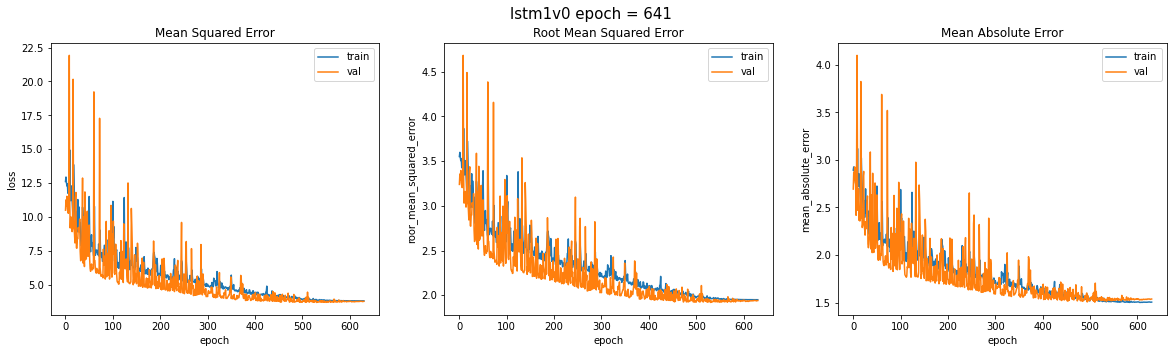

In [28]:
vis_results('lstm1v0', history_lstm1v0, epochs_lstm1v0)

In [29]:
results.update({'lstm1v0': eval_lstm1v0[1:]})

### lstm1

In [30]:
eval_lstm1, history_lstm1, epochs_lstm1 = model_history(lstm1, '/tmp/lstm1.h5', 0.01)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               69200     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 69,301
Trainable params: 69,301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
 9/10 [==========================>...] - ETA: 0s - loss: 40.3228 - mean_squared_error: 40.3228 - rmse: 6.3500 - mean_absolute_error: 5.0088
Epoch 00001: val_loss improved from inf to 13.84924, saving model to /tmp/lstm1.h5
10/10 [==============================] - 7s 245ms/step - loss: 40.1145 - mean_squar

10/10 [==============================] - ETA: 0s - loss: 13.4830 - mean_squared_error: 13.4830 - rmse: 3.6719 - mean_absolute_error: 3.0824
Epoch 00016: val_loss improved from 10.90996 to 10.90576, saving model to /tmp/lstm1.h5
10/10 [==============================] - 2s 174ms/step - loss: 13.4830 - mean_squared_error: 13.4830 - rmse: 3.6719 - mean_absolute_error: 3.0824 - val_loss: 10.9058 - val_mean_squared_error: 10.9058 - val_rmse: 3.3024 - val_mean_absolute_error: 2.6412 - lr: 0.0100
Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.3481 - mean_squared_error: 13.3481 - rmse: 3.6535 - mean_absolute_error: 2.9122
Epoch 00017: val_loss did not improve from 10.90576
10/10 [==============================] - 2s 158ms/step - loss: 13.3913 - mean_squared_error: 13.3913 - rmse: 3.6594 - mean_absolute_error: 2.9193 - val_loss: 11.1722 - val_mean_squared_error: 11.1722 - val_rmse: 3.3425 - val_mean_absolute_error: 2.7870 - lr: 0.0100
Epoch 18/1000
 9/10 [=============

Epoch 33/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.3313 - mean_squared_error: 13.3313 - rmse: 3.6512 - mean_absolute_error: 2.9096
Epoch 00033: val_loss did not improve from 9.17979
10/10 [==============================] - 1s 151ms/step - loss: 13.3262 - mean_squared_error: 13.3262 - rmse: 3.6505 - mean_absolute_error: 2.9099 - val_loss: 11.4536 - val_mean_squared_error: 11.4536 - val_rmse: 3.3843 - val_mean_absolute_error: 2.8561 - lr: 0.0100
Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.0896 - mean_squared_error: 13.0896 - rmse: 3.6179 - mean_absolute_error: 3.0036
Epoch 00034: val_loss did not improve from 9.17979
10/10 [==============================] - 2s 159ms/step - loss: 13.0362 - mean_squared_error: 13.0362 - rmse: 3.6106 - mean_absolute_error: 2.9960 - val_loss: 10.8064 - val_mean_squared_error: 10.8064 - val_rmse: 3.2873 - val_mean_absolute_error: 2.6317 - lr: 0.0100
Epoch 35/1000
 9/10 [==========================>...] - ETA

 9/10 [==========================>...] - ETA: 0s - loss: 10.7217 - mean_squared_error: 10.7217 - rmse: 3.2744 - mean_absolute_error: 2.6896
Epoch 00050: val_loss did not improve from 6.51140
10/10 [==============================] - 1s 148ms/step - loss: 10.7147 - mean_squared_error: 10.7147 - rmse: 3.2733 - mean_absolute_error: 2.6903 - val_loss: 9.0380 - val_mean_squared_error: 9.0380 - val_rmse: 3.0063 - val_mean_absolute_error: 2.2624 - lr: 0.0100
Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 9.6241 - mean_squared_error: 9.6241 - rmse: 3.1023 - mean_absolute_error: 2.4775
Epoch 00051: val_loss did not improve from 6.51140
10/10 [==============================] - 2s 157ms/step - loss: 9.6241 - mean_squared_error: 9.6241 - rmse: 3.1023 - mean_absolute_error: 2.4775 - val_loss: 6.7555 - val_mean_squared_error: 6.7555 - val_rmse: 2.5991 - val_mean_absolute_error: 2.0196 - lr: 0.0100
Epoch 52/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7934 - 

 9/10 [==========================>...] - ETA: 0s - loss: 7.5256 - mean_squared_error: 7.5256 - rmse: 2.7433 - mean_absolute_error: 2.1395
Epoch 00067: val_loss did not improve from 5.72827
10/10 [==============================] - 2s 174ms/step - loss: 7.5641 - mean_squared_error: 7.5641 - rmse: 2.7503 - mean_absolute_error: 2.1433 - val_loss: 5.8557 - val_mean_squared_error: 5.8557 - val_rmse: 2.4199 - val_mean_absolute_error: 1.9481 - lr: 0.0100
Epoch 68/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.0147 - mean_squared_error: 7.0147 - rmse: 2.6485 - mean_absolute_error: 2.0924
Epoch 00068: val_loss did not improve from 5.72827
10/10 [==============================] - 2s 160ms/step - loss: 7.0032 - mean_squared_error: 7.0032 - rmse: 2.6464 - mean_absolute_error: 2.0879 - val_loss: 11.2004 - val_mean_squared_error: 11.2004 - val_rmse: 3.3467 - val_mean_absolute_error: 2.8123 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 8.8398 - me

10/10 [==============================] - 2s 169ms/step - loss: 7.3762 - mean_squared_error: 7.3762 - rmse: 2.7159 - mean_absolute_error: 2.1233 - val_loss: 5.3561 - val_mean_squared_error: 5.3561 - val_rmse: 2.3143 - val_mean_absolute_error: 1.8322 - lr: 0.0100
Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 6.6933 - mean_squared_error: 6.6933 - rmse: 2.5871 - mean_absolute_error: 2.0516
Epoch 00085: val_loss did not improve from 5.35610
10/10 [==============================] - 2s 176ms/step - loss: 6.6933 - mean_squared_error: 6.6933 - rmse: 2.5871 - mean_absolute_error: 2.0516 - val_loss: 9.7072 - val_mean_squared_error: 9.7072 - val_rmse: 3.1156 - val_mean_absolute_error: 2.6127 - lr: 0.0100
Epoch 86/1000
 9/10 [==========================>...] - ETA: 0s - loss: 7.7683 - mean_squared_error: 7.7683 - rmse: 2.7872 - mean_absolute_error: 2.1977
Epoch 00086: val_loss did not improve from 5.35610
10/10 [==============================] - 1s 152ms/step - loss: 7.7730 

Epoch 102/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1403 - mean_squared_error: 6.1403 - rmse: 2.4780 - mean_absolute_error: 1.9464
Epoch 00102: val_loss improved from 5.27862 to 5.19381, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 136ms/step - loss: 6.1707 - mean_squared_error: 6.1707 - rmse: 2.4841 - mean_absolute_error: 1.9514 - val_loss: 5.1938 - val_mean_squared_error: 5.1938 - val_rmse: 2.2790 - val_mean_absolute_error: 1.7927 - lr: 0.0100
Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.3218 - mean_squared_error: 6.3218 - rmse: 2.5143 - mean_absolute_error: 1.9818
Epoch 00103: val_loss did not improve from 5.19381
10/10 [==============================] - 1s 149ms/step - loss: 6.3162 - mean_squared_error: 6.3162 - rmse: 2.5132 - mean_absolute_error: 1.9812 - val_loss: 6.6927 - val_mean_squared_error: 6.6927 - val_rmse: 2.5870 - val_mean_absolute_error: 2.1047 - lr: 0.0100
Epoch 104/1000
10/10 [===========

Epoch 120/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5902 - mean_squared_error: 6.5902 - rmse: 2.5671 - mean_absolute_error: 2.0247
Epoch 00120: val_loss did not improve from 5.03909
10/10 [==============================] - 1s 147ms/step - loss: 6.5956 - mean_squared_error: 6.5956 - rmse: 2.5682 - mean_absolute_error: 2.0227 - val_loss: 5.1191 - val_mean_squared_error: 5.1191 - val_rmse: 2.2625 - val_mean_absolute_error: 1.7854 - lr: 0.0100
Epoch 121/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1680 - mean_squared_error: 6.1680 - rmse: 2.4835 - mean_absolute_error: 1.9457
Epoch 00121: val_loss improved from 5.03909 to 5.02611, saving model to /tmp/lstm1.h5
10/10 [==============================] - 1s 130ms/step - loss: 6.1963 - mean_squared_error: 6.1963 - rmse: 2.4892 - mean_absolute_error: 1.9506 - val_loss: 5.0261 - val_mean_squared_error: 5.0261 - val_rmse: 2.2419 - val_mean_absolute_error: 1.7646 - lr: 0.0100
Epoch 122/1000
 9/10 [===========

 9/10 [==========================>...] - ETA: 0s - loss: 5.8603 - mean_squared_error: 5.8603 - rmse: 2.4208 - mean_absolute_error: 1.8947
Epoch 00137: val_loss did not improve from 4.82412
10/10 [==============================] - 2s 153ms/step - loss: 5.8690 - mean_squared_error: 5.8690 - rmse: 2.4226 - mean_absolute_error: 1.8995 - val_loss: 5.7568 - val_mean_squared_error: 5.7568 - val_rmse: 2.3993 - val_mean_absolute_error: 1.9282 - lr: 0.0100
Epoch 138/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.0275 - mean_squared_error: 6.0275 - rmse: 2.4551 - mean_absolute_error: 1.9091
Epoch 00138: val_loss did not improve from 4.82412
10/10 [==============================] - 1s 149ms/step - loss: 6.0577 - mean_squared_error: 6.0577 - rmse: 2.4612 - mean_absolute_error: 1.9128 - val_loss: 5.0446 - val_mean_squared_error: 5.0446 - val_rmse: 2.2460 - val_mean_absolute_error: 1.7770 - lr: 0.0100
Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.0649 - me

Epoch 155/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3661 - mean_squared_error: 5.3661 - rmse: 2.3165 - mean_absolute_error: 1.7958
Epoch 00155: val_loss did not improve from 4.55385
10/10 [==============================] - 1s 147ms/step - loss: 5.3728 - mean_squared_error: 5.3728 - rmse: 2.3179 - mean_absolute_error: 1.7999 - val_loss: 5.8326 - val_mean_squared_error: 5.8326 - val_rmse: 2.4151 - val_mean_absolute_error: 1.9892 - lr: 0.0100
Epoch 156/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5701 - mean_squared_error: 5.5701 - rmse: 2.3601 - mean_absolute_error: 1.8535
Epoch 00156: val_loss improved from 4.55385 to 4.49733, saving model to /tmp/lstm1.h5
10/10 [==============================] - 2s 158ms/step - loss: 5.6300 - mean_squared_error: 5.6300 - rmse: 2.3728 - mean_absolute_error: 1.8625 - val_loss: 4.4973 - val_mean_squared_error: 4.4973 - val_rmse: 2.1207 - val_mean_absolute_error: 1.6748 - lr: 0.0100
Epoch 157/1000
 9/10 [===========

Epoch 173/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3888 - mean_squared_error: 5.3888 - rmse: 2.3214 - mean_absolute_error: 1.8065
Epoch 00173: val_loss did not improve from 4.42533
10/10 [==============================] - 2s 153ms/step - loss: 5.3649 - mean_squared_error: 5.3649 - rmse: 2.3162 - mean_absolute_error: 1.8028 - val_loss: 4.6334 - val_mean_squared_error: 4.6334 - val_rmse: 2.1525 - val_mean_absolute_error: 1.6648 - lr: 0.0100
Epoch 174/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.4813 - mean_squared_error: 5.4813 - rmse: 2.3412 - mean_absolute_error: 1.8121
Epoch 00174: val_loss did not improve from 4.42533
10/10 [==============================] - 1s 135ms/step - loss: 5.4675 - mean_squared_error: 5.4675 - rmse: 2.3383 - mean_absolute_error: 1.8114 - val_loss: 4.5239 - val_mean_squared_error: 4.5239 - val_rmse: 2.1270 - val_mean_absolute_error: 1.6952 - lr: 0.0100
Epoch 175/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 191/1000
10/10 [==============================] - ETA: 0s - loss: 5.1438 - mean_squared_error: 5.1438 - rmse: 2.2680 - mean_absolute_error: 1.7916
Epoch 00191: val_loss did not improve from 4.03194
10/10 [==============================] - 1s 152ms/step - loss: 5.1438 - mean_squared_error: 5.1438 - rmse: 2.2680 - mean_absolute_error: 1.7916 - val_loss: 4.1714 - val_mean_squared_error: 4.1714 - val_rmse: 2.0424 - val_mean_absolute_error: 1.6256 - lr: 0.0100
Epoch 192/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1348 - mean_squared_error: 5.1348 - rmse: 2.2660 - mean_absolute_error: 1.7514
Epoch 00192: val_loss did not improve from 4.03194
10/10 [==============================] - 2s 160ms/step - loss: 5.1321 - mean_squared_error: 5.1321 - rmse: 2.2654 - mean_absolute_error: 1.7487 - val_loss: 9.6063 - val_mean_squared_error: 9.6063 - val_rmse: 3.0994 - val_mean_absolute_error: 2.6490 - lr: 0.0100
Epoch 193/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 209/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.5413 - mean_squared_error: 5.5413 - rmse: 2.3540 - mean_absolute_error: 1.8605
Epoch 00209: val_loss did not improve from 4.00691
10/10 [==============================] - 2s 154ms/step - loss: 5.5220 - mean_squared_error: 5.5220 - rmse: 2.3499 - mean_absolute_error: 1.8572 - val_loss: 5.1485 - val_mean_squared_error: 5.1485 - val_rmse: 2.2690 - val_mean_absolute_error: 1.7351 - lr: 0.0100
Epoch 210/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.1976 - mean_squared_error: 6.1976 - rmse: 2.4895 - mean_absolute_error: 1.9435
Epoch 00210: val_loss did not improve from 4.00691
10/10 [==============================] - 2s 157ms/step - loss: 6.1807 - mean_squared_error: 6.1807 - rmse: 2.4861 - mean_absolute_error: 1.9418 - val_loss: 4.2800 - val_mean_squared_error: 4.2800 - val_rmse: 2.0688 - val_mean_absolute_error: 1.6356 - lr: 0.0100
Epoch 211/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 227/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.1589 - mean_squared_error: 5.1589 - rmse: 2.2713 - mean_absolute_error: 1.7726
Epoch 00227: val_loss did not improve from 3.86119
10/10 [==============================] - 2s 167ms/step - loss: 5.1556 - mean_squared_error: 5.1556 - rmse: 2.2706 - mean_absolute_error: 1.7726 - val_loss: 5.2987 - val_mean_squared_error: 5.2987 - val_rmse: 2.3019 - val_mean_absolute_error: 1.9228 - lr: 0.0100
Epoch 228/1000
10/10 [==============================] - ETA: 0s - loss: 4.5803 - mean_squared_error: 4.5803 - rmse: 2.1402 - mean_absolute_error: 1.6668
Epoch 00228: val_loss did not improve from 3.86119
10/10 [==============================] - 2s 167ms/step - loss: 4.5803 - mean_squared_error: 4.5803 - rmse: 2.1402 - mean_absolute_error: 1.6668 - val_loss: 4.2083 - val_mean_squared_error: 4.2083 - val_rmse: 2.0514 - val_mean_absolute_error: 1.6697 - lr: 0.0100
Epoch 229/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 245/1000
10/10 [==============================] - ETA: 0s - loss: 4.4235 - mean_squared_error: 4.4235 - rmse: 2.1032 - mean_absolute_error: 1.6354
Epoch 00245: val_loss did not improve from 3.74424
10/10 [==============================] - 2s 159ms/step - loss: 4.4235 - mean_squared_error: 4.4235 - rmse: 2.1032 - mean_absolute_error: 1.6354 - val_loss: 4.5782 - val_mean_squared_error: 4.5782 - val_rmse: 2.1397 - val_mean_absolute_error: 1.6665 - lr: 0.0100
Epoch 246/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6360 - mean_squared_error: 4.6360 - rmse: 2.1531 - mean_absolute_error: 1.6760
Epoch 00246: val_loss did not improve from 3.74424
10/10 [==============================] - 2s 167ms/step - loss: 4.6177 - mean_squared_error: 4.6177 - rmse: 2.1489 - mean_absolute_error: 1.6718 - val_loss: 4.4343 - val_mean_squared_error: 4.4343 - val_rmse: 2.1058 - val_mean_absolute_error: 1.6963 - lr: 0.0100
Epoch 247/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 263/1000
10/10 [==============================] - ETA: 0s - loss: 4.2905 - mean_squared_error: 4.2905 - rmse: 2.0714 - mean_absolute_error: 1.6021
Epoch 00263: val_loss did not improve from 3.64903
10/10 [==============================] - 2s 161ms/step - loss: 4.2905 - mean_squared_error: 4.2905 - rmse: 2.0714 - mean_absolute_error: 1.6021 - val_loss: 4.2041 - val_mean_squared_error: 4.2041 - val_rmse: 2.0504 - val_mean_absolute_error: 1.6076 - lr: 0.0100
Epoch 264/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.3933 - mean_squared_error: 4.3933 - rmse: 2.0960 - mean_absolute_error: 1.6225
Epoch 00264: val_loss did not improve from 3.64903
10/10 [==============================] - 2s 161ms/step - loss: 4.3934 - mean_squared_error: 4.3934 - rmse: 2.0961 - mean_absolute_error: 1.6245 - val_loss: 3.7201 - val_mean_squared_error: 3.7201 - val_rmse: 1.9287 - val_mean_absolute_error: 1.5318 - lr: 0.0100
Epoch 265/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 281/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.9749 - mean_squared_error: 4.9749 - rmse: 2.2304 - mean_absolute_error: 1.7079
Epoch 00281: val_loss did not improve from 3.59839
10/10 [==============================] - 2s 166ms/step - loss: 4.9835 - mean_squared_error: 4.9835 - rmse: 2.2324 - mean_absolute_error: 1.7098 - val_loss: 4.1174 - val_mean_squared_error: 4.1174 - val_rmse: 2.0291 - val_mean_absolute_error: 1.6615 - lr: 0.0100
Epoch 282/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.6686 - mean_squared_error: 4.6686 - rmse: 2.1607 - mean_absolute_error: 1.6807
Epoch 00282: val_loss did not improve from 3.59839
10/10 [==============================] - 2s 165ms/step - loss: 4.6760 - mean_squared_error: 4.6760 - rmse: 2.1624 - mean_absolute_error: 1.6829 - val_loss: 4.8727 - val_mean_squared_error: 4.8727 - val_rmse: 2.2074 - val_mean_absolute_error: 1.8320 - lr: 0.0100
Epoch 283/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 299/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.3356 - mean_squared_error: 5.3356 - rmse: 2.3099 - mean_absolute_error: 1.8302
Epoch 00299: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 168ms/step - loss: 5.3339 - mean_squared_error: 5.3339 - rmse: 2.3095 - mean_absolute_error: 1.8302 - val_loss: 4.6805 - val_mean_squared_error: 4.6805 - val_rmse: 2.1634 - val_mean_absolute_error: 1.6714 - lr: 0.0100
Epoch 300/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.5058 - mean_squared_error: 6.5058 - rmse: 2.5507 - mean_absolute_error: 2.0008
Epoch 00300: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 169ms/step - loss: 6.5016 - mean_squared_error: 6.5016 - rmse: 2.5498 - mean_absolute_error: 2.0034 - val_loss: 4.0506 - val_mean_squared_error: 4.0506 - val_rmse: 2.0126 - val_mean_absolute_error: 1.6100 - lr: 0.0100
Epoch 301/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 317/1000
10/10 [==============================] - ETA: 0s - loss: 4.1462 - mean_squared_error: 4.1462 - rmse: 2.0362 - mean_absolute_error: 1.5756
Epoch 00317: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 160ms/step - loss: 4.1462 - mean_squared_error: 4.1462 - rmse: 2.0362 - mean_absolute_error: 1.5756 - val_loss: 4.4152 - val_mean_squared_error: 4.4152 - val_rmse: 2.1012 - val_mean_absolute_error: 1.6738 - lr: 0.0050
Epoch 318/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.2111 - mean_squared_error: 4.2111 - rmse: 2.0521 - mean_absolute_error: 1.6021
Epoch 00318: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 164ms/step - loss: 4.1899 - mean_squared_error: 4.1899 - rmse: 2.0469 - mean_absolute_error: 1.5981 - val_loss: 3.9615 - val_mean_squared_error: 3.9615 - val_rmse: 1.9904 - val_mean_absolute_error: 1.5762 - lr: 0.0050
Epoch 319/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 335/1000
10/10 [==============================] - ETA: 0s - loss: 3.6891 - mean_squared_error: 3.6891 - rmse: 1.9207 - mean_absolute_error: 1.4665
Epoch 00335: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 162ms/step - loss: 3.6891 - mean_squared_error: 3.6891 - rmse: 1.9207 - mean_absolute_error: 1.4665 - val_loss: 4.2339 - val_mean_squared_error: 4.2339 - val_rmse: 2.0577 - val_mean_absolute_error: 1.6253 - lr: 0.0025
Epoch 336/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.8063 - mean_squared_error: 3.8063 - rmse: 1.9510 - mean_absolute_error: 1.5044
Epoch 00336: val_loss did not improve from 3.59223
10/10 [==============================] - 2s 154ms/step - loss: 3.8163 - mean_squared_error: 3.8163 - rmse: 1.9535 - mean_absolute_error: 1.5082 - val_loss: 3.9557 - val_mean_squared_error: 3.9557 - val_rmse: 1.9889 - val_mean_absolute_error: 1.5631 - lr: 0.0025
Epoch 337/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 353/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6268 - mean_squared_error: 3.6268 - rmse: 1.9044 - mean_absolute_error: 1.4760
Epoch 00353: val_loss did not improve from 3.59189
10/10 [==============================] - 2s 166ms/step - loss: 3.6202 - mean_squared_error: 3.6202 - rmse: 1.9027 - mean_absolute_error: 1.4760 - val_loss: 3.6912 - val_mean_squared_error: 3.6912 - val_rmse: 1.9212 - val_mean_absolute_error: 1.5117 - lr: 0.0025
Epoch 354/1000
10/10 [==============================] - ETA: 0s - loss: 3.5862 - mean_squared_error: 3.5862 - rmse: 1.8937 - mean_absolute_error: 1.4623
Epoch 00354: val_loss did not improve from 3.59189
10/10 [==============================] - 2s 165ms/step - loss: 3.5862 - mean_squared_error: 3.5862 - rmse: 1.8937 - mean_absolute_error: 1.4623 - val_loss: 3.6597 - val_mean_squared_error: 3.6597 - val_rmse: 1.9130 - val_mean_absolute_error: 1.4987 - lr: 0.0025
Epoch 355/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 371/1000
10/10 [==============================] - ETA: 0s - loss: 3.5496 - mean_squared_error: 3.5496 - rmse: 1.8840 - mean_absolute_error: 1.4537
Epoch 00371: val_loss did not improve from 3.57565
10/10 [==============================] - 2s 160ms/step - loss: 3.5496 - mean_squared_error: 3.5496 - rmse: 1.8840 - mean_absolute_error: 1.4537 - val_loss: 3.7058 - val_mean_squared_error: 3.7058 - val_rmse: 1.9250 - val_mean_absolute_error: 1.5256 - lr: 0.0012
Epoch 372/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.5978 - mean_squared_error: 3.5978 - rmse: 1.8968 - mean_absolute_error: 1.4771
Epoch 00372: val_loss improved from 3.57565 to 3.54386, saving model to /tmp/lstm1.h5
10/10 [==============================] - 2s 165ms/step - loss: 3.5827 - mean_squared_error: 3.5827 - rmse: 1.8928 - mean_absolute_error: 1.4745 - val_loss: 3.5439 - val_mean_squared_error: 3.5439 - val_rmse: 1.8825 - val_mean_absolute_error: 1.4862 - lr: 0.0012
Epoch 373/1000
 9/10 [===========

Epoch 389/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.5080 - mean_squared_error: 3.5080 - rmse: 1.8730 - mean_absolute_error: 1.4428
Epoch 00389: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 161ms/step - loss: 3.5063 - mean_squared_error: 3.5063 - rmse: 1.8725 - mean_absolute_error: 1.4434 - val_loss: 3.5688 - val_mean_squared_error: 3.5688 - val_rmse: 1.8891 - val_mean_absolute_error: 1.4968 - lr: 0.0012
Epoch 390/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.5351 - mean_squared_error: 3.5351 - rmse: 1.8802 - mean_absolute_error: 1.4393
Epoch 00390: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 151ms/step - loss: 3.5324 - mean_squared_error: 3.5324 - rmse: 1.8795 - mean_absolute_error: 1.4398 - val_loss: 3.6674 - val_mean_squared_error: 3.6674 - val_rmse: 1.9150 - val_mean_absolute_error: 1.5129 - lr: 0.0012
Epoch 391/1000
 9/10 [==========================>...] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 3.4831 - mean_squared_error: 3.4831 - rmse: 1.8663 - mean_absolute_error: 1.4391
Epoch 00406: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 164ms/step - loss: 3.4691 - mean_squared_error: 3.4691 - rmse: 1.8626 - mean_absolute_error: 1.4363 - val_loss: 3.6808 - val_mean_squared_error: 3.6808 - val_rmse: 1.9185 - val_mean_absolute_error: 1.5122 - lr: 6.2500e-04
Epoch 407/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4866 - mean_squared_error: 3.4866 - rmse: 1.8673 - mean_absolute_error: 1.4366
Epoch 00407: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 169ms/step - loss: 3.4729 - mean_squared_error: 3.4729 - rmse: 1.8636 - mean_absolute_error: 1.4330 - val_loss: 3.7042 - val_mean_squared_error: 3.7042 - val_rmse: 1.9246 - val_mean_absolute_error: 1.5152 - lr: 6.2500e-04
Epoch 408/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4

 9/10 [==========================>...] - ETA: 0s - loss: 3.4690 - mean_squared_error: 3.4690 - rmse: 1.8625 - mean_absolute_error: 1.4358
Epoch 00423: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 160ms/step - loss: 3.4707 - mean_squared_error: 3.4707 - rmse: 1.8630 - mean_absolute_error: 1.4349 - val_loss: 3.6652 - val_mean_squared_error: 3.6652 - val_rmse: 1.9145 - val_mean_absolute_error: 1.5103 - lr: 3.1250e-04
Epoch 424/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4694 - mean_squared_error: 3.4694 - rmse: 1.8626 - mean_absolute_error: 1.4290
Epoch 00424: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 160ms/step - loss: 3.4614 - mean_squared_error: 3.4614 - rmse: 1.8605 - mean_absolute_error: 1.4276 - val_loss: 3.6721 - val_mean_squared_error: 3.6721 - val_rmse: 1.9163 - val_mean_absolute_error: 1.5079 - lr: 3.1250e-04
Epoch 425/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4

 9/10 [==========================>...] - ETA: 0s - loss: 3.4670 - mean_squared_error: 3.4670 - rmse: 1.8620 - mean_absolute_error: 1.4310
Epoch 00440: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 163ms/step - loss: 3.4527 - mean_squared_error: 3.4527 - rmse: 1.8581 - mean_absolute_error: 1.4270 - val_loss: 3.6765 - val_mean_squared_error: 3.6765 - val_rmse: 1.9174 - val_mean_absolute_error: 1.5114 - lr: 1.5625e-04
Epoch 441/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4626 - mean_squared_error: 3.4626 - rmse: 1.8608 - mean_absolute_error: 1.4265
Epoch 00441: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 161ms/step - loss: 3.4608 - mean_squared_error: 3.4608 - rmse: 1.8603 - mean_absolute_error: 1.4269 - val_loss: 3.6758 - val_mean_squared_error: 3.6758 - val_rmse: 1.9172 - val_mean_absolute_error: 1.5118 - lr: 1.5625e-04
Epoch 442/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4

 9/10 [==========================>...] - ETA: 0s - loss: 3.4545 - mean_squared_error: 3.4545 - rmse: 1.8586 - mean_absolute_error: 1.4273
Epoch 00457: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 171ms/step - loss: 3.4497 - mean_squared_error: 3.4497 - rmse: 1.8573 - mean_absolute_error: 1.4270 - val_loss: 3.6552 - val_mean_squared_error: 3.6552 - val_rmse: 1.9119 - val_mean_absolute_error: 1.5083 - lr: 7.8125e-05
Epoch 458/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4247 - mean_squared_error: 3.4247 - rmse: 1.8506 - mean_absolute_error: 1.4217
Epoch 00458: val_loss did not improve from 3.54386
10/10 [==============================] - 2s 156ms/step - loss: 3.4478 - mean_squared_error: 3.4478 - rmse: 1.8568 - mean_absolute_error: 1.4263 - val_loss: 3.6663 - val_mean_squared_error: 3.6663 - val_rmse: 1.9148 - val_mean_absolute_error: 1.5099 - lr: 7.8125e-05
Epoch 459/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.4

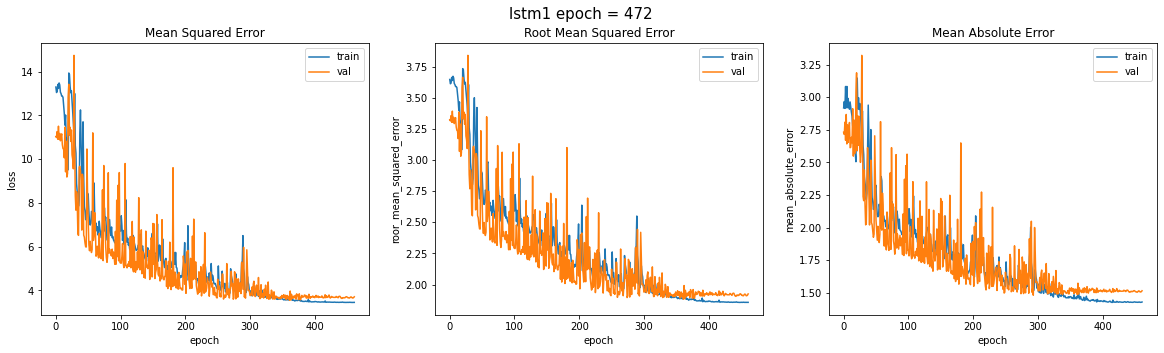

In [31]:
vis_results('lstm1', history_lstm1, epochs_lstm1)

In [32]:
results.update({'lstm1': eval_lstm1[1:]})

### lstm2

In [33]:
eval_lstm2, history_lstm2, epochs_lstm2 = model_history(lstm2, '/tmp/lstm2.h5', 0.01)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          69200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 149,701
Trainable params: 149,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 33.3225 - mean_squared_error: 33.3225 - rmse: 5.7726 - mean_absolute_error: 4.4973
Epoch 00001: val_loss improved f

Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 13.2829 - mean_squared_error: 13.2829 - rmse: 3.6446 - mean_absolute_error: 2.9221
Epoch 00016: val_loss did not improve from 10.97983
10/10 [==============================] - 3s 332ms/step - loss: 13.2829 - mean_squared_error: 13.2829 - rmse: 3.6446 - mean_absolute_error: 2.9221 - val_loss: 11.1214 - val_mean_squared_error: 11.1214 - val_rmse: 3.3349 - val_mean_absolute_error: 2.7544 - lr: 0.0100
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 13.1170 - mean_squared_error: 13.1170 - rmse: 3.6217 - mean_absolute_error: 2.9854
Epoch 00017: val_loss did not improve from 10.97983
10/10 [==============================] - 3s 313ms/step - loss: 13.1170 - mean_squared_error: 13.1170 - rmse: 3.6217 - mean_absolute_error: 2.9854 - val_loss: 11.0689 - val_mean_squared_error: 11.0689 - val_rmse: 3.3270 - val_mean_absolute_error: 2.7342 - lr: 0.0100
Epoch 18/1000
10/10 [==============================] - E

10/10 [==============================] - ETA: 0s - loss: 13.1729 - mean_squared_error: 13.1729 - rmse: 3.6295 - mean_absolute_error: 2.9281
Epoch 00033: val_loss did not improve from 10.97524
10/10 [==============================] - 3s 329ms/step - loss: 13.1729 - mean_squared_error: 13.1729 - rmse: 3.6295 - mean_absolute_error: 2.9281 - val_loss: 11.0211 - val_mean_squared_error: 11.0211 - val_rmse: 3.3198 - val_mean_absolute_error: 2.7114 - lr: 0.0100
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 13.0649 - mean_squared_error: 13.0649 - rmse: 3.6145 - mean_absolute_error: 2.9602
Epoch 00034: val_loss did not improve from 10.97524
10/10 [==============================] - 3s 322ms/step - loss: 13.0649 - mean_squared_error: 13.0649 - rmse: 3.6145 - mean_absolute_error: 2.9602 - val_loss: 11.3262 - val_mean_squared_error: 11.3262 - val_rmse: 3.3654 - val_mean_absolute_error: 2.8159 - lr: 0.0100
Epoch 35/1000
10/10 [==============================] - ETA: 0s - loss:

Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 13.1523 - mean_squared_error: 13.1523 - rmse: 3.6266 - mean_absolute_error: 2.9464
Epoch 00051: val_loss did not improve from 10.95533
10/10 [==============================] - 3s 325ms/step - loss: 13.1523 - mean_squared_error: 13.1523 - rmse: 3.6266 - mean_absolute_error: 2.9464 - val_loss: 11.2215 - val_mean_squared_error: 11.2215 - val_rmse: 3.3498 - val_mean_absolute_error: 2.7921 - lr: 0.0100
Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss: 13.0332 - mean_squared_error: 13.0332 - rmse: 3.6101 - mean_absolute_error: 2.9428
Epoch 00052: val_loss did not improve from 10.95533
10/10 [==============================] - 3s 337ms/step - loss: 13.0332 - mean_squared_error: 13.0332 - rmse: 3.6101 - mean_absolute_error: 2.9428 - val_loss: 10.9905 - val_mean_squared_error: 10.9905 - val_rmse: 3.3152 - val_mean_absolute_error: 2.7218 - lr: 0.0100
Epoch 53/1000
10/10 [==============================] - E

10/10 [==============================] - ETA: 0s - loss: 11.5356 - mean_squared_error: 11.5356 - rmse: 3.3964 - mean_absolute_error: 2.7773
Epoch 00068: val_loss did not improve from 8.33726
10/10 [==============================] - 3s 329ms/step - loss: 11.5356 - mean_squared_error: 11.5356 - rmse: 3.3964 - mean_absolute_error: 2.7773 - val_loss: 9.3014 - val_mean_squared_error: 9.3014 - val_rmse: 3.0498 - val_mean_absolute_error: 2.4860 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 10.5079 - mean_squared_error: 10.5079 - rmse: 3.2416 - mean_absolute_error: 2.6402
Epoch 00069: val_loss improved from 8.33726 to 8.13796, saving model to /tmp/lstm2.h5
10/10 [==============================] - 3s 298ms/step - loss: 10.5079 - mean_squared_error: 10.5079 - rmse: 3.2416 - mean_absolute_error: 2.6402 - val_loss: 8.1380 - val_mean_squared_error: 8.1380 - val_rmse: 2.8527 - val_mean_absolute_error: 2.3127 - lr: 0.0100
Epoch 70/1000
10/10 [====================

Epoch 85/1000
10/10 [==============================] - ETA: 0s - loss: 9.1221 - mean_squared_error: 9.1221 - rmse: 3.0203 - mean_absolute_error: 2.3926
Epoch 00085: val_loss did not improve from 6.53709
10/10 [==============================] - 3s 305ms/step - loss: 9.1221 - mean_squared_error: 9.1221 - rmse: 3.0203 - mean_absolute_error: 2.3926 - val_loss: 9.9271 - val_mean_squared_error: 9.9271 - val_rmse: 3.1507 - val_mean_absolute_error: 2.6773 - lr: 0.0100
Epoch 86/1000
10/10 [==============================] - ETA: 0s - loss: 8.7249 - mean_squared_error: 8.7249 - rmse: 2.9538 - mean_absolute_error: 2.3690
Epoch 00086: val_loss improved from 6.53709 to 6.33526, saving model to /tmp/lstm2.h5
10/10 [==============================] - 3s 350ms/step - loss: 8.7249 - mean_squared_error: 8.7249 - rmse: 2.9538 - mean_absolute_error: 2.3690 - val_loss: 6.3353 - val_mean_squared_error: 6.3353 - val_rmse: 2.5170 - val_mean_absolute_error: 1.9982 - lr: 0.0100
Epoch 87/1000
10/10 [==============

10/10 [==============================] - ETA: 0s - loss: 7.3279 - mean_squared_error: 7.3279 - rmse: 2.7070 - mean_absolute_error: 2.1649
Epoch 00102: val_loss did not improve from 5.85652
10/10 [==============================] - 3s 318ms/step - loss: 7.3279 - mean_squared_error: 7.3279 - rmse: 2.7070 - mean_absolute_error: 2.1649 - val_loss: 6.5005 - val_mean_squared_error: 6.5005 - val_rmse: 2.5496 - val_mean_absolute_error: 2.0206 - lr: 0.0100
Epoch 103/1000
10/10 [==============================] - ETA: 0s - loss: 7.1037 - mean_squared_error: 7.1037 - rmse: 2.6653 - mean_absolute_error: 2.1010
Epoch 00103: val_loss improved from 5.85652 to 5.47905, saving model to /tmp/lstm2.h5
10/10 [==============================] - 3s 345ms/step - loss: 7.1037 - mean_squared_error: 7.1037 - rmse: 2.6653 - mean_absolute_error: 2.1010 - val_loss: 5.4791 - val_mean_squared_error: 5.4791 - val_rmse: 2.3407 - val_mean_absolute_error: 1.8588 - lr: 0.0100
Epoch 104/1000
10/10 [==========================

Epoch 120/1000
10/10 [==============================] - ETA: 0s - loss: 6.5748 - mean_squared_error: 6.5748 - rmse: 2.5641 - mean_absolute_error: 1.9907
Epoch 00120: val_loss did not improve from 5.27958
10/10 [==============================] - 3s 322ms/step - loss: 6.5748 - mean_squared_error: 6.5748 - rmse: 2.5641 - mean_absolute_error: 1.9907 - val_loss: 7.8698 - val_mean_squared_error: 7.8698 - val_rmse: 2.8053 - val_mean_absolute_error: 2.3266 - lr: 0.0100
Epoch 121/1000
10/10 [==============================] - ETA: 0s - loss: 7.1923 - mean_squared_error: 7.1923 - rmse: 2.6819 - mean_absolute_error: 2.0999
Epoch 00121: val_loss did not improve from 5.27958
10/10 [==============================] - 3s 336ms/step - loss: 7.1923 - mean_squared_error: 7.1923 - rmse: 2.6819 - mean_absolute_error: 2.0999 - val_loss: 5.5747 - val_mean_squared_error: 5.5747 - val_rmse: 2.3611 - val_mean_absolute_error: 1.8306 - lr: 0.0100
Epoch 122/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 6.2396 - mean_squared_error: 6.2396 - rmse: 2.4979 - mean_absolute_error: 1.9549
Epoch 00138: val_loss did not improve from 5.04993
10/10 [==============================] - 3s 333ms/step - loss: 6.2396 - mean_squared_error: 6.2396 - rmse: 2.4979 - mean_absolute_error: 1.9549 - val_loss: 5.0970 - val_mean_squared_error: 5.0970 - val_rmse: 2.2576 - val_mean_absolute_error: 1.7629 - lr: 0.0100
Epoch 139/1000
10/10 [==============================] - ETA: 0s - loss: 6.4154 - mean_squared_error: 6.4154 - rmse: 2.5329 - mean_absolute_error: 1.9858
Epoch 00139: val_loss did not improve from 5.04993
10/10 [==============================] - 3s 341ms/step - loss: 6.4154 - mean_squared_error: 6.4154 - rmse: 2.5329 - mean_absolute_error: 1.9858 - val_loss: 6.0566 - val_mean_squared_error: 6.0566 - val_rmse: 2.4610 - val_mean_absolute_error: 1.9984 - lr: 0.0100
Epoch 140/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 6.1671 - mean_squared_error: 6.1671 - rmse: 2.4834 - mean_absolute_error: 1.9829
Epoch 00155: val_loss did not improve from 4.78211
10/10 [==============================] - 3s 304ms/step - loss: 6.1671 - mean_squared_error: 6.1671 - rmse: 2.4834 - mean_absolute_error: 1.9829 - val_loss: 4.8371 - val_mean_squared_error: 4.8371 - val_rmse: 2.1993 - val_mean_absolute_error: 1.7195 - lr: 0.0100
Epoch 156/1000
10/10 [==============================] - ETA: 0s - loss: 6.3744 - mean_squared_error: 6.3744 - rmse: 2.5248 - mean_absolute_error: 1.9772
Epoch 00156: val_loss did not improve from 4.78211
10/10 [==============================] - 3s 317ms/step - loss: 6.3744 - mean_squared_error: 6.3744 - rmse: 2.5248 - mean_absolute_error: 1.9772 - val_loss: 5.1934 - val_mean_squared_error: 5.1934 - val_rmse: 2.2789 - val_mean_absolute_error: 1.8235 - lr: 0.0100
Epoch 157/1000
10/10 [==============================] - ETA: 0s - loss: 5.8753 - me

Epoch 173/1000
10/10 [==============================] - ETA: 0s - loss: 5.7504 - mean_squared_error: 5.7504 - rmse: 2.3980 - mean_absolute_error: 1.8732
Epoch 00173: val_loss did not improve from 4.69648
10/10 [==============================] - 3s 329ms/step - loss: 5.7504 - mean_squared_error: 5.7504 - rmse: 2.3980 - mean_absolute_error: 1.8732 - val_loss: 4.8205 - val_mean_squared_error: 4.8205 - val_rmse: 2.1956 - val_mean_absolute_error: 1.7049 - lr: 0.0100
Epoch 174/1000
10/10 [==============================] - ETA: 0s - loss: 6.1915 - mean_squared_error: 6.1915 - rmse: 2.4883 - mean_absolute_error: 1.9293
Epoch 00174: val_loss did not improve from 4.69648
10/10 [==============================] - 3s 304ms/step - loss: 6.1915 - mean_squared_error: 6.1915 - rmse: 2.4883 - mean_absolute_error: 1.9293 - val_loss: 7.4755 - val_mean_squared_error: 7.4755 - val_rmse: 2.7341 - val_mean_absolute_error: 2.3051 - lr: 0.0100
Epoch 175/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 191/1000
10/10 [==============================] - ETA: 0s - loss: 7.0063 - mean_squared_error: 7.0063 - rmse: 2.6469 - mean_absolute_error: 2.0684
Epoch 00191: val_loss did not improve from 4.64481
10/10 [==============================] - 3s 337ms/step - loss: 7.0063 - mean_squared_error: 7.0063 - rmse: 2.6469 - mean_absolute_error: 2.0684 - val_loss: 5.4646 - val_mean_squared_error: 5.4646 - val_rmse: 2.3377 - val_mean_absolute_error: 1.8834 - lr: 0.0100
Epoch 192/1000
10/10 [==============================] - ETA: 0s - loss: 6.0339 - mean_squared_error: 6.0339 - rmse: 2.4564 - mean_absolute_error: 1.9241
Epoch 00192: val_loss did not improve from 4.64481
10/10 [==============================] - 3s 309ms/step - loss: 6.0339 - mean_squared_error: 6.0339 - rmse: 2.4564 - mean_absolute_error: 1.9241 - val_loss: 5.3969 - val_mean_squared_error: 5.3969 - val_rmse: 2.3231 - val_mean_absolute_error: 1.7782 - lr: 0.0100
Epoch 193/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 209/1000
10/10 [==============================] - ETA: 0s - loss: 5.2813 - mean_squared_error: 5.2813 - rmse: 2.2981 - mean_absolute_error: 1.7861
Epoch 00209: val_loss did not improve from 4.64481
10/10 [==============================] - 3s 319ms/step - loss: 5.2813 - mean_squared_error: 5.2813 - rmse: 2.2981 - mean_absolute_error: 1.7861 - val_loss: 4.8540 - val_mean_squared_error: 4.8540 - val_rmse: 2.2032 - val_mean_absolute_error: 1.7269 - lr: 0.0050
Epoch 210/1000
10/10 [==============================] - ETA: 0s - loss: 5.2731 - mean_squared_error: 5.2731 - rmse: 2.2963 - mean_absolute_error: 1.7972
Epoch 00210: val_loss did not improve from 4.64481
10/10 [==============================] - 3s 309ms/step - loss: 5.2731 - mean_squared_error: 5.2731 - rmse: 2.2963 - mean_absolute_error: 1.7972 - val_loss: 4.7314 - val_mean_squared_error: 4.7314 - val_rmse: 2.1752 - val_mean_absolute_error: 1.7149 - lr: 0.0050
Epoch 211/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 227/1000
10/10 [==============================] - ETA: 0s - loss: 5.4326 - mean_squared_error: 5.4326 - rmse: 2.3308 - mean_absolute_error: 1.8383
Epoch 00227: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 316ms/step - loss: 5.4326 - mean_squared_error: 5.4326 - rmse: 2.3308 - mean_absolute_error: 1.8383 - val_loss: 4.7000 - val_mean_squared_error: 4.7000 - val_rmse: 2.1679 - val_mean_absolute_error: 1.6846 - lr: 0.0050
Epoch 228/1000
10/10 [==============================] - ETA: 0s - loss: 5.2990 - mean_squared_error: 5.2990 - rmse: 2.3020 - mean_absolute_error: 1.7904
Epoch 00228: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 293ms/step - loss: 5.2990 - mean_squared_error: 5.2990 - rmse: 2.3020 - mean_absolute_error: 1.7904 - val_loss: 4.5440 - val_mean_squared_error: 4.5440 - val_rmse: 2.1317 - val_mean_absolute_error: 1.6624 - lr: 0.0050
Epoch 229/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 245/1000
10/10 [==============================] - ETA: 0s - loss: 5.2018 - mean_squared_error: 5.2018 - rmse: 2.2807 - mean_absolute_error: 1.7858
Epoch 00245: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 333ms/step - loss: 5.2018 - mean_squared_error: 5.2018 - rmse: 2.2807 - mean_absolute_error: 1.7858 - val_loss: 4.8036 - val_mean_squared_error: 4.8036 - val_rmse: 2.1917 - val_mean_absolute_error: 1.7200 - lr: 0.0025
Epoch 246/1000
10/10 [==============================] - ETA: 0s - loss: 5.2290 - mean_squared_error: 5.2290 - rmse: 2.2867 - mean_absolute_error: 1.7899
Epoch 00246: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 314ms/step - loss: 5.2290 - mean_squared_error: 5.2290 - rmse: 2.2867 - mean_absolute_error: 1.7899 - val_loss: 4.6713 - val_mean_squared_error: 4.6713 - val_rmse: 2.1613 - val_mean_absolute_error: 1.6951 - lr: 0.0025
Epoch 247/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 263/1000
10/10 [==============================] - ETA: 0s - loss: 4.9434 - mean_squared_error: 4.9434 - rmse: 2.2234 - mean_absolute_error: 1.7209
Epoch 00263: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 301ms/step - loss: 4.9434 - mean_squared_error: 4.9434 - rmse: 2.2234 - mean_absolute_error: 1.7209 - val_loss: 4.7833 - val_mean_squared_error: 4.7833 - val_rmse: 2.1871 - val_mean_absolute_error: 1.7090 - lr: 0.0012
Epoch 264/1000
10/10 [==============================] - ETA: 0s - loss: 4.9017 - mean_squared_error: 4.9017 - rmse: 2.2140 - mean_absolute_error: 1.7363
Epoch 00264: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 316ms/step - loss: 4.9017 - mean_squared_error: 4.9017 - rmse: 2.2140 - mean_absolute_error: 1.7363 - val_loss: 4.6005 - val_mean_squared_error: 4.6005 - val_rmse: 2.1449 - val_mean_absolute_error: 1.6598 - lr: 0.0012
Epoch 265/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 281/1000
10/10 [==============================] - ETA: 0s - loss: 4.8126 - mean_squared_error: 4.8126 - rmse: 2.1938 - mean_absolute_error: 1.7054
Epoch 00281: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 312ms/step - loss: 4.8126 - mean_squared_error: 4.8126 - rmse: 2.1938 - mean_absolute_error: 1.7054 - val_loss: 4.7113 - val_mean_squared_error: 4.7113 - val_rmse: 2.1706 - val_mean_absolute_error: 1.7001 - lr: 6.2500e-04
Epoch 282/1000
10/10 [==============================] - ETA: 0s - loss: 4.8081 - mean_squared_error: 4.8081 - rmse: 2.1927 - mean_absolute_error: 1.7094
Epoch 00282: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 297ms/step - loss: 4.8081 - mean_squared_error: 4.8081 - rmse: 2.1927 - mean_absolute_error: 1.7094 - val_loss: 4.6350 - val_mean_squared_error: 4.6350 - val_rmse: 2.1529 - val_mean_absolute_error: 1.6871 - lr: 6.2500e-04
Epoch 283/1000
10/10 [==============================] - ETA:

10/10 [==============================] - ETA: 0s - loss: 4.8061 - mean_squared_error: 4.8061 - rmse: 2.1923 - mean_absolute_error: 1.7216
Epoch 00298: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 317ms/step - loss: 4.8061 - mean_squared_error: 4.8061 - rmse: 2.1923 - mean_absolute_error: 1.7216 - val_loss: 4.6184 - val_mean_squared_error: 4.6184 - val_rmse: 2.1490 - val_mean_absolute_error: 1.6850 - lr: 3.1250e-04
Epoch 299/1000
10/10 [==============================] - ETA: 0s - loss: 4.7356 - mean_squared_error: 4.7356 - rmse: 2.1761 - mean_absolute_error: 1.6902
Epoch 00299: val_loss did not improve from 4.46021
10/10 [==============================] - 3s 314ms/step - loss: 4.7356 - mean_squared_error: 4.7356 - rmse: 2.1761 - mean_absolute_error: 1.6902 - val_loss: 4.5026 - val_mean_squared_error: 4.5026 - val_rmse: 2.1219 - val_mean_absolute_error: 1.6569 - lr: 3.1250e-04
Epoch 300/1000
10/10 [==============================] - ETA: 0s - loss: 4.7

Epoch 316/1000
10/10 [==============================] - ETA: 0s - loss: 4.6899 - mean_squared_error: 4.6899 - rmse: 2.1656 - mean_absolute_error: 1.6888
Epoch 00316: val_loss did not improve from 4.46021

Epoch 00316: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
12/12 [==============================] - 0s 38ms/step - loss: 6.4195 - mean_squared_error: 6.4195 - rmse: 2.5337 - mean_absolute_error: 1.8759


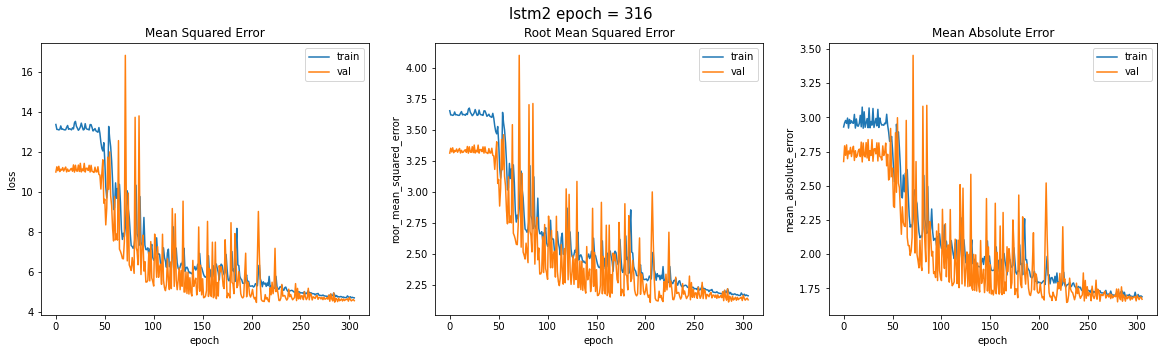

In [34]:
vis_results('lstm2', history_lstm2, epochs_lstm2)

In [35]:
results.update({'lstm2': eval_lstm2[1:]})

### blstm1

In [36]:
eval_blstm1, history_blstm1, epochs_blstm1 = model_history(blstm1, '/tmp/blstm1.h5', 0.01)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              138400    
 l)                                                              
                                                                 
 dense_13 (Dense)            (None, 1)                 201       
                                                                 
Total params: 138,601
Trainable params: 138,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - ETA: 0s - loss: 30.7176 - mean_squared_error: 30.7176 - rmse: 5.5423 - mean_absolute_error: 4.3728
Epoch 00001: val_loss improved from inf to 10.88776, saving model to /tmp/blstm1.h5
10/10 [=======

Epoch 16/1000
 9/10 [==========================>...] - ETA: 0s - loss: 11.1694 - mean_squared_error: 11.1694 - rmse: 3.3421 - mean_absolute_error: 2.7102
Epoch 00016: val_loss did not improve from 9.20678
10/10 [==============================] - 2s 183ms/step - loss: 11.1509 - mean_squared_error: 11.1509 - rmse: 3.3393 - mean_absolute_error: 2.7097 - val_loss: 11.5406 - val_mean_squared_error: 11.5406 - val_rmse: 3.3971 - val_mean_absolute_error: 2.4784 - lr: 0.0100
Epoch 17/1000
 9/10 [==========================>...] - ETA: 0s - loss: 13.9453 - mean_squared_error: 13.9453 - rmse: 3.7343 - mean_absolute_error: 3.0036
Epoch 00017: val_loss did not improve from 9.20678
10/10 [==============================] - 2s 177ms/step - loss: 13.8963 - mean_squared_error: 13.8963 - rmse: 3.7278 - mean_absolute_error: 2.9995 - val_loss: 9.7426 - val_mean_squared_error: 9.7426 - val_rmse: 3.1213 - val_mean_absolute_error: 2.5301 - lr: 0.0100
Epoch 18/1000
10/10 [==============================] - ETA: 

 9/10 [==========================>...] - ETA: 0s - loss: 8.5199 - mean_squared_error: 8.5199 - rmse: 2.9189 - mean_absolute_error: 2.3127
Epoch 00033: val_loss improved from 7.49672 to 7.08787, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 170ms/step - loss: 8.5141 - mean_squared_error: 8.5141 - rmse: 2.9179 - mean_absolute_error: 2.3123 - val_loss: 7.0879 - val_mean_squared_error: 7.0879 - val_rmse: 2.6623 - val_mean_absolute_error: 2.1898 - lr: 0.0100
Epoch 34/1000
 9/10 [==========================>...] - ETA: 0s - loss: 8.5835 - mean_squared_error: 8.5835 - rmse: 2.9298 - mean_absolute_error: 2.3426
Epoch 00034: val_loss did not improve from 7.08787
10/10 [==============================] - 2s 177ms/step - loss: 8.6092 - mean_squared_error: 8.6092 - rmse: 2.9341 - mean_absolute_error: 2.3447 - val_loss: 8.2345 - val_mean_squared_error: 8.2345 - val_rmse: 2.8696 - val_mean_absolute_error: 2.4479 - lr: 0.0100
Epoch 35/1000
 9/10 [==========================>

Epoch 51/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.9603 - mean_squared_error: 6.9603 - rmse: 2.6382 - mean_absolute_error: 2.1091
Epoch 00051: val_loss improved from 6.72502 to 5.78206, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 191ms/step - loss: 6.9513 - mean_squared_error: 6.9513 - rmse: 2.6365 - mean_absolute_error: 2.1081 - val_loss: 5.7821 - val_mean_squared_error: 5.7821 - val_rmse: 2.4046 - val_mean_absolute_error: 1.9898 - lr: 0.0100
Epoch 52/1000
 9/10 [==========================>...] - ETA: 0s - loss: 6.8152 - mean_squared_error: 6.8152 - rmse: 2.6106 - mean_absolute_error: 2.0349
Epoch 00052: val_loss improved from 5.78206 to 5.43055, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 177ms/step - loss: 6.7822 - mean_squared_error: 6.7822 - rmse: 2.6043 - mean_absolute_error: 2.0295 - val_loss: 5.4306 - val_mean_squared_error: 5.4306 - val_rmse: 2.3304 - val_mean_absolute_error: 1.9067 - lr: 0.010

 9/10 [==========================>...] - ETA: 0s - loss: 5.5337 - mean_squared_error: 5.5337 - rmse: 2.3524 - mean_absolute_error: 1.8586
Epoch 00068: val_loss did not improve from 4.67518
10/10 [==============================] - 2s 181ms/step - loss: 5.5249 - mean_squared_error: 5.5249 - rmse: 2.3505 - mean_absolute_error: 1.8568 - val_loss: 4.6865 - val_mean_squared_error: 4.6865 - val_rmse: 2.1648 - val_mean_absolute_error: 1.6608 - lr: 0.0100
Epoch 69/1000
 9/10 [==========================>...] - ETA: 0s - loss: 5.2230 - mean_squared_error: 5.2230 - rmse: 2.2854 - mean_absolute_error: 1.7759
Epoch 00069: val_loss improved from 4.67518 to 4.54993, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 189ms/step - loss: 5.2299 - mean_squared_error: 5.2299 - rmse: 2.2869 - mean_absolute_error: 1.7771 - val_loss: 4.5499 - val_mean_squared_error: 4.5499 - val_rmse: 2.1331 - val_mean_absolute_error: 1.6676 - lr: 0.0100
Epoch 70/1000
10/10 [===========================

 9/10 [==========================>...] - ETA: 0s - loss: 5.0082 - mean_squared_error: 5.0082 - rmse: 2.2379 - mean_absolute_error: 1.7126
Epoch 00085: val_loss improved from 4.03876 to 3.91053, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 183ms/step - loss: 4.9936 - mean_squared_error: 4.9936 - rmse: 2.2346 - mean_absolute_error: 1.7107 - val_loss: 3.9105 - val_mean_squared_error: 3.9105 - val_rmse: 1.9775 - val_mean_absolute_error: 1.5920 - lr: 0.0100
Epoch 86/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.5273 - mean_squared_error: 4.5273 - rmse: 2.1278 - mean_absolute_error: 1.6187
Epoch 00086: val_loss did not improve from 3.91053
10/10 [==============================] - 2s 176ms/step - loss: 4.5514 - mean_squared_error: 4.5514 - rmse: 2.1334 - mean_absolute_error: 1.6219 - val_loss: 3.9960 - val_mean_squared_error: 3.9960 - val_rmse: 1.9990 - val_mean_absolute_error: 1.6157 - lr: 0.0100
Epoch 87/1000
 9/10 [==========================>

Epoch 103/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.0306 - mean_squared_error: 4.0306 - rmse: 2.0076 - mean_absolute_error: 1.5449
Epoch 00103: val_loss did not improve from 3.71268
10/10 [==============================] - 2s 175ms/step - loss: 4.0316 - mean_squared_error: 4.0316 - rmse: 2.0079 - mean_absolute_error: 1.5472 - val_loss: 3.9205 - val_mean_squared_error: 3.9205 - val_rmse: 1.9800 - val_mean_absolute_error: 1.5302 - lr: 0.0100
Epoch 104/1000
 9/10 [==========================>...] - ETA: 0s - loss: 4.4318 - mean_squared_error: 4.4318 - rmse: 2.1052 - mean_absolute_error: 1.6389
Epoch 00104: val_loss did not improve from 3.71268
10/10 [==============================] - 2s 180ms/step - loss: 4.4129 - mean_squared_error: 4.4129 - rmse: 2.1007 - mean_absolute_error: 1.6346 - val_loss: 3.7400 - val_mean_squared_error: 3.7400 - val_rmse: 1.9339 - val_mean_absolute_error: 1.5668 - lr: 0.0100
Epoch 105/1000
 9/10 [==========================>...] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 3.8803 - mean_squared_error: 3.8803 - rmse: 1.9698 - mean_absolute_error: 1.5253
Epoch 00120: val_loss did not improve from 3.57882
10/10 [==============================] - 2s 179ms/step - loss: 3.8803 - mean_squared_error: 3.8803 - rmse: 1.9698 - mean_absolute_error: 1.5253 - val_loss: 3.5960 - val_mean_squared_error: 3.5960 - val_rmse: 1.8963 - val_mean_absolute_error: 1.4853 - lr: 0.0050
Epoch 121/1000
10/10 [==============================] - ETA: 0s - loss: 3.6269 - mean_squared_error: 3.6269 - rmse: 1.9044 - mean_absolute_error: 1.4777
Epoch 00121: val_loss improved from 3.57882 to 3.57811, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 162ms/step - loss: 3.6269 - mean_squared_error: 3.6269 - rmse: 1.9044 - mean_absolute_error: 1.4777 - val_loss: 3.5781 - val_mean_squared_error: 3.5781 - val_rmse: 1.8916 - val_mean_absolute_error: 1.5129 - lr: 0.0050
Epoch 122/1000
 9/10 [=========================

 9/10 [==========================>...] - ETA: 0s - loss: 3.5279 - mean_squared_error: 3.5279 - rmse: 1.8783 - mean_absolute_error: 1.4663
Epoch 00137: val_loss did not improve from 3.43466
10/10 [==============================] - 2s 178ms/step - loss: 3.5162 - mean_squared_error: 3.5162 - rmse: 1.8752 - mean_absolute_error: 1.4636 - val_loss: 3.7277 - val_mean_squared_error: 3.7277 - val_rmse: 1.9307 - val_mean_absolute_error: 1.4972 - lr: 0.0050
Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 3.5454 - mean_squared_error: 3.5454 - rmse: 1.8829 - mean_absolute_error: 1.4599
Epoch 00138: val_loss did not improve from 3.43466
10/10 [==============================] - 2s 194ms/step - loss: 3.5454 - mean_squared_error: 3.5454 - rmse: 1.8829 - mean_absolute_error: 1.4599 - val_loss: 3.4542 - val_mean_squared_error: 3.4542 - val_rmse: 1.8585 - val_mean_absolute_error: 1.4703 - lr: 0.0050
Epoch 139/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.6034 - me

Epoch 155/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.2855 - mean_squared_error: 3.2855 - rmse: 1.8126 - mean_absolute_error: 1.4115
Epoch 00155: val_loss did not improve from 3.43466
10/10 [==============================] - 2s 192ms/step - loss: 3.2749 - mean_squared_error: 3.2749 - rmse: 1.8097 - mean_absolute_error: 1.4096 - val_loss: 3.4785 - val_mean_squared_error: 3.4785 - val_rmse: 1.8651 - val_mean_absolute_error: 1.4657 - lr: 0.0025
Epoch 156/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.3839 - mean_squared_error: 3.3839 - rmse: 1.8395 - mean_absolute_error: 1.4314
Epoch 00156: val_loss did not improve from 3.43466
10/10 [==============================] - 2s 173ms/step - loss: 3.3827 - mean_squared_error: 3.3827 - rmse: 1.8392 - mean_absolute_error: 1.4340 - val_loss: 3.5818 - val_mean_squared_error: 3.5818 - val_rmse: 1.8926 - val_mean_absolute_error: 1.4996 - lr: 0.0025
Epoch 157/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 173/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.2675 - mean_squared_error: 3.2675 - rmse: 1.8076 - mean_absolute_error: 1.4107
Epoch 00173: val_loss improved from 3.42413 to 3.40810, saving model to /tmp/blstm1.h5
10/10 [==============================] - 2s 181ms/step - loss: 3.2669 - mean_squared_error: 3.2669 - rmse: 1.8074 - mean_absolute_error: 1.4095 - val_loss: 3.4081 - val_mean_squared_error: 3.4081 - val_rmse: 1.8461 - val_mean_absolute_error: 1.4593 - lr: 0.0025
Epoch 174/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.2083 - mean_squared_error: 3.2083 - rmse: 1.7912 - mean_absolute_error: 1.3778
Epoch 00174: val_loss did not improve from 3.40810
10/10 [==============================] - 2s 178ms/step - loss: 3.2165 - mean_squared_error: 3.2165 - rmse: 1.7935 - mean_absolute_error: 1.3795 - val_loss: 4.1004 - val_mean_squared_error: 4.1004 - val_rmse: 2.0249 - val_mean_absolute_error: 1.6553 - lr: 0.0025
Epoch 175/1000
 9/10 [==========

Epoch 191/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.1994 - mean_squared_error: 3.1994 - rmse: 1.7887 - mean_absolute_error: 1.3781
Epoch 00191: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 185ms/step - loss: 3.1785 - mean_squared_error: 3.1785 - rmse: 1.7828 - mean_absolute_error: 1.3725 - val_loss: 4.0977 - val_mean_squared_error: 4.0977 - val_rmse: 2.0243 - val_mean_absolute_error: 1.6531 - lr: 0.0025
Epoch 192/1000
 9/10 [==========================>...] - ETA: 0s - loss: 3.2802 - mean_squared_error: 3.2802 - rmse: 1.8111 - mean_absolute_error: 1.4143
Epoch 00192: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 187ms/step - loss: 3.2792 - mean_squared_error: 3.2792 - rmse: 1.8108 - mean_absolute_error: 1.4135 - val_loss: 3.5733 - val_mean_squared_error: 3.5733 - val_rmse: 1.8903 - val_mean_absolute_error: 1.5192 - lr: 0.0025
Epoch 193/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 209/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9914 - mean_squared_error: 2.9914 - rmse: 1.7296 - mean_absolute_error: 1.3368
Epoch 00209: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 171ms/step - loss: 2.9893 - mean_squared_error: 2.9893 - rmse: 1.7290 - mean_absolute_error: 1.3373 - val_loss: 3.5165 - val_mean_squared_error: 3.5165 - val_rmse: 1.8752 - val_mean_absolute_error: 1.5001 - lr: 0.0012
Epoch 210/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.9685 - mean_squared_error: 2.9685 - rmse: 1.7229 - mean_absolute_error: 1.3308
Epoch 00210: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 174ms/step - loss: 2.9565 - mean_squared_error: 2.9565 - rmse: 1.7194 - mean_absolute_error: 1.3292 - val_loss: 3.4565 - val_mean_squared_error: 3.4565 - val_rmse: 1.8592 - val_mean_absolute_error: 1.4721 - lr: 0.0012
Epoch 211/1000
 9/10 [==========================>...] - ETA: 0s - lo

Epoch 227/1000
10/10 [==============================] - ETA: 0s - loss: 2.9268 - mean_squared_error: 2.9268 - rmse: 1.7108 - mean_absolute_error: 1.3178
Epoch 00227: val_loss did not improve from 3.35480

Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
10/10 [==============================] - 2s 191ms/step - loss: 2.9268 - mean_squared_error: 2.9268 - rmse: 1.7108 - mean_absolute_error: 1.3178 - val_loss: 3.5954 - val_mean_squared_error: 3.5954 - val_rmse: 1.8961 - val_mean_absolute_error: 1.5177 - lr: 0.0012
Epoch 228/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8661 - mean_squared_error: 2.8661 - rmse: 1.6930 - mean_absolute_error: 1.3130
Epoch 00228: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 187ms/step - loss: 2.8910 - mean_squared_error: 2.8910 - rmse: 1.7003 - mean_absolute_error: 1.3165 - val_loss: 3.3995 - val_mean_squared_error: 3.3995 - val_rmse: 1.8438 - val_mean_absolute_error: 1.4573 

 9/10 [==========================>...] - ETA: 0s - loss: 2.8810 - mean_squared_error: 2.8810 - rmse: 1.6974 - mean_absolute_error: 1.3188
Epoch 00244: val_loss did not improve from 3.35480
10/10 [==============================] - 1s 108ms/step - loss: 2.8822 - mean_squared_error: 2.8822 - rmse: 1.6977 - mean_absolute_error: 1.3205 - val_loss: 3.3844 - val_mean_squared_error: 3.3844 - val_rmse: 1.8397 - val_mean_absolute_error: 1.4596 - lr: 6.2500e-04
Epoch 245/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8499 - mean_squared_error: 2.8499 - rmse: 1.6882 - mean_absolute_error: 1.2883
Epoch 00245: val_loss did not improve from 3.35480
10/10 [==============================] - 1s 116ms/step - loss: 2.8658 - mean_squared_error: 2.8658 - rmse: 1.6929 - mean_absolute_error: 1.2934 - val_loss: 3.5889 - val_mean_squared_error: 3.5889 - val_rmse: 1.8944 - val_mean_absolute_error: 1.5117 - lr: 6.2500e-04
Epoch 246/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8

 9/10 [==========================>...] - ETA: 0s - loss: 2.8003 - mean_squared_error: 2.8003 - rmse: 1.6734 - mean_absolute_error: 1.2836
Epoch 00261: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 182ms/step - loss: 2.7995 - mean_squared_error: 2.7995 - rmse: 1.6732 - mean_absolute_error: 1.2838 - val_loss: 3.5054 - val_mean_squared_error: 3.5054 - val_rmse: 1.8723 - val_mean_absolute_error: 1.4786 - lr: 3.1250e-04
Epoch 262/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7815 - mean_squared_error: 2.7815 - rmse: 1.6678 - mean_absolute_error: 1.2797
Epoch 00262: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 162ms/step - loss: 2.7981 - mean_squared_error: 2.7981 - rmse: 1.6728 - mean_absolute_error: 1.2839 - val_loss: 3.4652 - val_mean_squared_error: 3.4652 - val_rmse: 1.8615 - val_mean_absolute_error: 1.4692 - lr: 3.1250e-04
Epoch 263/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8

 9/10 [==========================>...] - ETA: 0s - loss: 2.7760 - mean_squared_error: 2.7760 - rmse: 1.6661 - mean_absolute_error: 1.2796
Epoch 00278: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 170ms/step - loss: 2.7817 - mean_squared_error: 2.7817 - rmse: 1.6678 - mean_absolute_error: 1.2804 - val_loss: 3.4696 - val_mean_squared_error: 3.4696 - val_rmse: 1.8627 - val_mean_absolute_error: 1.4688 - lr: 1.5625e-04
Epoch 279/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8006 - mean_squared_error: 2.8006 - rmse: 1.6735 - mean_absolute_error: 1.2767
Epoch 00279: val_loss did not improve from 3.35480
10/10 [==============================] - 2s 176ms/step - loss: 2.7988 - mean_squared_error: 2.7988 - rmse: 1.6730 - mean_absolute_error: 1.2777 - val_loss: 3.4723 - val_mean_squared_error: 3.4723 - val_rmse: 1.8634 - val_mean_absolute_error: 1.4693 - lr: 1.5625e-04
Epoch 280/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.7

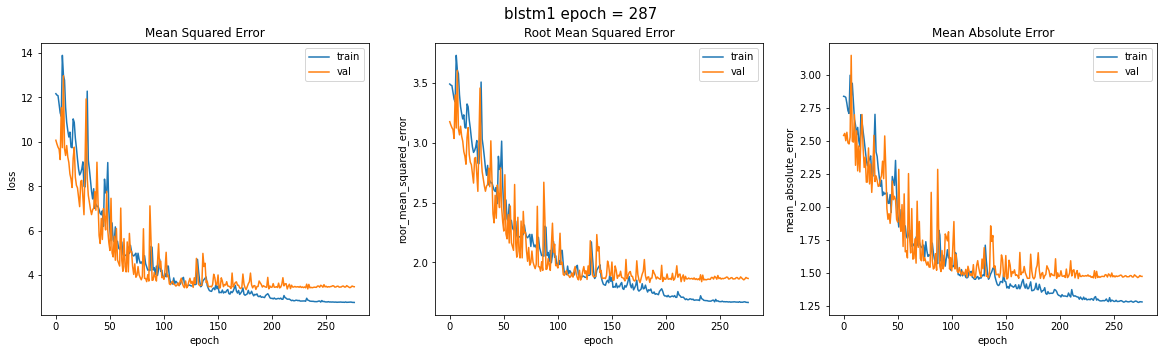

In [37]:
vis_results('blstm1', history_blstm1, epochs_blstm1)

In [38]:
results.update({'blstm1': eval_blstm1[1:]})

### blstm2

In [39]:
eval_blstm2, history_blstm2, epochs_blstm2 = model_history(blstm2, '/tmp/blstm2.h5', 0.01)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100, 72)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 200)         138400    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 201       
                                                                 
Total params: 379,401
Trainable params: 379,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] -

Epoch 16/1000
10/10 [==============================] - ETA: 0s - loss: 10.4009 - mean_squared_error: 10.4009 - rmse: 3.2250 - mean_absolute_error: 2.6104
Epoch 00016: val_loss did not improve from 9.36828
10/10 [==============================] - 4s 391ms/step - loss: 10.4009 - mean_squared_error: 10.4009 - rmse: 3.2250 - mean_absolute_error: 2.6104 - val_loss: 16.9551 - val_mean_squared_error: 16.9551 - val_rmse: 4.1177 - val_mean_absolute_error: 3.5835 - lr: 0.0100
Epoch 17/1000
10/10 [==============================] - ETA: 0s - loss: 11.5566 - mean_squared_error: 11.5566 - rmse: 3.3995 - mean_absolute_error: 2.7649
Epoch 00017: val_loss improved from 9.36828 to 8.47526, saving model to /tmp/blstm2.h5
10/10 [==============================] - 4s 398ms/step - loss: 11.5566 - mean_squared_error: 11.5566 - rmse: 3.3995 - mean_absolute_error: 2.7649 - val_loss: 8.4753 - val_mean_squared_error: 8.4753 - val_rmse: 2.9112 - val_mean_absolute_error: 2.4087 - lr: 0.0100
Epoch 18/1000
10/10 [===

10/10 [==============================] - ETA: 0s - loss: 9.1949 - mean_squared_error: 9.1949 - rmse: 3.0323 - mean_absolute_error: 2.4171
Epoch 00033: val_loss did not improve from 7.29823
10/10 [==============================] - 4s 385ms/step - loss: 9.1949 - mean_squared_error: 9.1949 - rmse: 3.0323 - mean_absolute_error: 2.4171 - val_loss: 8.5774 - val_mean_squared_error: 8.5774 - val_rmse: 2.9287 - val_mean_absolute_error: 2.5285 - lr: 0.0100
Epoch 34/1000
10/10 [==============================] - ETA: 0s - loss: 8.2506 - mean_squared_error: 8.2506 - rmse: 2.8724 - mean_absolute_error: 2.2860
Epoch 00034: val_loss did not improve from 7.29823
10/10 [==============================] - 4s 385ms/step - loss: 8.2506 - mean_squared_error: 8.2506 - rmse: 2.8724 - mean_absolute_error: 2.2860 - val_loss: 8.4083 - val_mean_squared_error: 8.4083 - val_rmse: 2.8997 - val_mean_absolute_error: 2.4740 - lr: 0.0100
Epoch 35/1000
10/10 [==============================] - ETA: 0s - loss: 8.2979 - mean

Epoch 51/1000
10/10 [==============================] - ETA: 0s - loss: 7.2149 - mean_squared_error: 7.2149 - rmse: 2.6861 - mean_absolute_error: 2.1231
Epoch 00051: val_loss did not improve from 6.64614
10/10 [==============================] - 4s 381ms/step - loss: 7.2149 - mean_squared_error: 7.2149 - rmse: 2.6861 - mean_absolute_error: 2.1231 - val_loss: 7.7209 - val_mean_squared_error: 7.7209 - val_rmse: 2.7786 - val_mean_absolute_error: 2.1230 - lr: 0.0100
Epoch 52/1000
10/10 [==============================] - ETA: 0s - loss: 8.6334 - mean_squared_error: 8.6334 - rmse: 2.9383 - mean_absolute_error: 2.3184
Epoch 00052: val_loss did not improve from 6.64614
10/10 [==============================] - 4s 381ms/step - loss: 8.6334 - mean_squared_error: 8.6334 - rmse: 2.9383 - mean_absolute_error: 2.3184 - val_loss: 8.6888 - val_mean_squared_error: 8.6888 - val_rmse: 2.9477 - val_mean_absolute_error: 2.4623 - lr: 0.0100
Epoch 53/1000
10/10 [==============================] - ETA: 0s - loss:

10/10 [==============================] - ETA: 0s - loss: 7.8425 - mean_squared_error: 7.8425 - rmse: 2.8004 - mean_absolute_error: 2.1932
Epoch 00068: val_loss did not improve from 5.62126
10/10 [==============================] - 4s 395ms/step - loss: 7.8425 - mean_squared_error: 7.8425 - rmse: 2.8004 - mean_absolute_error: 2.1932 - val_loss: 6.7076 - val_mean_squared_error: 6.7076 - val_rmse: 2.5899 - val_mean_absolute_error: 1.9718 - lr: 0.0100
Epoch 69/1000
10/10 [==============================] - ETA: 0s - loss: 7.0907 - mean_squared_error: 7.0907 - rmse: 2.6628 - mean_absolute_error: 2.0886
Epoch 00069: val_loss did not improve from 5.62126
10/10 [==============================] - 4s 380ms/step - loss: 7.0907 - mean_squared_error: 7.0907 - rmse: 2.6628 - mean_absolute_error: 2.0886 - val_loss: 6.4707 - val_mean_squared_error: 6.4707 - val_rmse: 2.5438 - val_mean_absolute_error: 2.1350 - lr: 0.0100
Epoch 70/1000
10/10 [==============================] - ETA: 0s - loss: 7.6496 - mean

10/10 [==============================] - ETA: 0s - loss: 5.4512 - mean_squared_error: 5.4512 - rmse: 2.3348 - mean_absolute_error: 1.8005
Epoch 00085: val_loss did not improve from 4.63595
10/10 [==============================] - 4s 379ms/step - loss: 5.4512 - mean_squared_error: 5.4512 - rmse: 2.3348 - mean_absolute_error: 1.8005 - val_loss: 6.1190 - val_mean_squared_error: 6.1190 - val_rmse: 2.4737 - val_mean_absolute_error: 2.0685 - lr: 0.0100
Epoch 86/1000
10/10 [==============================] - ETA: 0s - loss: 5.4249 - mean_squared_error: 5.4249 - rmse: 2.3292 - mean_absolute_error: 1.8196
Epoch 00086: val_loss did not improve from 4.63595
10/10 [==============================] - 4s 394ms/step - loss: 5.4249 - mean_squared_error: 5.4249 - rmse: 2.3292 - mean_absolute_error: 1.8196 - val_loss: 4.6528 - val_mean_squared_error: 4.6528 - val_rmse: 2.1570 - val_mean_absolute_error: 1.6541 - lr: 0.0100
Epoch 87/1000
10/10 [==============================] - ETA: 0s - loss: 5.1118 - mean

10/10 [==============================] - ETA: 0s - loss: 4.6470 - mean_squared_error: 4.6470 - rmse: 2.1557 - mean_absolute_error: 1.6501
Epoch 00102: val_loss did not improve from 3.90245
10/10 [==============================] - 4s 386ms/step - loss: 4.6470 - mean_squared_error: 4.6470 - rmse: 2.1557 - mean_absolute_error: 1.6501 - val_loss: 4.0329 - val_mean_squared_error: 4.0329 - val_rmse: 2.0082 - val_mean_absolute_error: 1.6320 - lr: 0.0100
Epoch 103/1000
10/10 [==============================] - ETA: 0s - loss: 4.3801 - mean_squared_error: 4.3801 - rmse: 2.0929 - mean_absolute_error: 1.6083
Epoch 00103: val_loss did not improve from 3.90245
10/10 [==============================] - 4s 383ms/step - loss: 4.3801 - mean_squared_error: 4.3801 - rmse: 2.0929 - mean_absolute_error: 1.6083 - val_loss: 4.0929 - val_mean_squared_error: 4.0929 - val_rmse: 2.0231 - val_mean_absolute_error: 1.5723 - lr: 0.0100
Epoch 104/1000
10/10 [==============================] - ETA: 0s - loss: 4.5008 - me

Epoch 120/1000
10/10 [==============================] - ETA: 0s - loss: 4.6253 - mean_squared_error: 4.6253 - rmse: 2.1506 - mean_absolute_error: 1.6529
Epoch 00120: val_loss did not improve from 3.77746
10/10 [==============================] - 4s 392ms/step - loss: 4.6253 - mean_squared_error: 4.6253 - rmse: 2.1506 - mean_absolute_error: 1.6529 - val_loss: 4.3422 - val_mean_squared_error: 4.3422 - val_rmse: 2.0838 - val_mean_absolute_error: 1.7103 - lr: 0.0100
Epoch 121/1000
10/10 [==============================] - ETA: 0s - loss: 4.2313 - mean_squared_error: 4.2313 - rmse: 2.0570 - mean_absolute_error: 1.5679
Epoch 00121: val_loss did not improve from 3.77746
10/10 [==============================] - 4s 398ms/step - loss: 4.2313 - mean_squared_error: 4.2313 - rmse: 2.0570 - mean_absolute_error: 1.5679 - val_loss: 5.0881 - val_mean_squared_error: 5.0881 - val_rmse: 2.2557 - val_mean_absolute_error: 1.6919 - lr: 0.0100
Epoch 122/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 138/1000
10/10 [==============================] - ETA: 0s - loss: 4.2535 - mean_squared_error: 4.2535 - rmse: 2.0624 - mean_absolute_error: 1.6074
Epoch 00138: val_loss did not improve from 3.68499
10/10 [==============================] - 4s 399ms/step - loss: 4.2535 - mean_squared_error: 4.2535 - rmse: 2.0624 - mean_absolute_error: 1.6074 - val_loss: 3.8587 - val_mean_squared_error: 3.8587 - val_rmse: 1.9643 - val_mean_absolute_error: 1.5024 - lr: 0.0100
Epoch 139/1000
10/10 [==============================] - ETA: 0s - loss: 4.2381 - mean_squared_error: 4.2381 - rmse: 2.0587 - mean_absolute_error: 1.5764
Epoch 00139: val_loss did not improve from 3.68499
10/10 [==============================] - 4s 393ms/step - loss: 4.2381 - mean_squared_error: 4.2381 - rmse: 2.0587 - mean_absolute_error: 1.5764 - val_loss: 4.3592 - val_mean_squared_error: 4.3592 - val_rmse: 2.0879 - val_mean_absolute_error: 1.7254 - lr: 0.0100
Epoch 140/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 3.8101 - mean_squared_error: 3.8101 - rmse: 1.9520 - mean_absolute_error: 1.4939
Epoch 00155: val_loss did not improve from 3.42857
10/10 [==============================] - 4s 412ms/step - loss: 3.8101 - mean_squared_error: 3.8101 - rmse: 1.9520 - mean_absolute_error: 1.4939 - val_loss: 3.8567 - val_mean_squared_error: 3.8567 - val_rmse: 1.9639 - val_mean_absolute_error: 1.5995 - lr: 0.0100
Epoch 156/1000
10/10 [==============================] - ETA: 0s - loss: 3.8483 - mean_squared_error: 3.8483 - rmse: 1.9617 - mean_absolute_error: 1.5081
Epoch 00156: val_loss did not improve from 3.42857
10/10 [==============================] - 4s 398ms/step - loss: 3.8483 - mean_squared_error: 3.8483 - rmse: 1.9617 - mean_absolute_error: 1.5081 - val_loss: 3.4922 - val_mean_squared_error: 3.4922 - val_rmse: 1.8688 - val_mean_absolute_error: 1.4922 - lr: 0.0100
Epoch 157/1000
10/10 [==============================] - ETA: 0s - loss: 3.5970 - me

Epoch 173/1000
10/10 [==============================] - ETA: 0s - loss: 3.4642 - mean_squared_error: 3.4642 - rmse: 1.8612 - mean_absolute_error: 1.4150
Epoch 00173: val_loss did not improve from 3.32073
10/10 [==============================] - 4s 389ms/step - loss: 3.4642 - mean_squared_error: 3.4642 - rmse: 1.8612 - mean_absolute_error: 1.4150 - val_loss: 3.5012 - val_mean_squared_error: 3.5012 - val_rmse: 1.8711 - val_mean_absolute_error: 1.5071 - lr: 0.0100
Epoch 174/1000
10/10 [==============================] - ETA: 0s - loss: 3.2847 - mean_squared_error: 3.2847 - rmse: 1.8124 - mean_absolute_error: 1.4027
Epoch 00174: val_loss did not improve from 3.32073
10/10 [==============================] - 4s 380ms/step - loss: 3.2847 - mean_squared_error: 3.2847 - rmse: 1.8124 - mean_absolute_error: 1.4027 - val_loss: 3.3226 - val_mean_squared_error: 3.3226 - val_rmse: 1.8228 - val_mean_absolute_error: 1.4465 - lr: 0.0100
Epoch 175/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 191/1000
10/10 [==============================] - ETA: 0s - loss: 4.3235 - mean_squared_error: 4.3235 - rmse: 2.0793 - mean_absolute_error: 1.6202
Epoch 00191: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 398ms/step - loss: 4.3235 - mean_squared_error: 4.3235 - rmse: 2.0793 - mean_absolute_error: 1.6202 - val_loss: 3.4790 - val_mean_squared_error: 3.4790 - val_rmse: 1.8652 - val_mean_absolute_error: 1.5184 - lr: 0.0100
Epoch 192/1000
10/10 [==============================] - ETA: 0s - loss: 3.3625 - mean_squared_error: 3.3625 - rmse: 1.8337 - mean_absolute_error: 1.4260
Epoch 00192: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 405ms/step - loss: 3.3625 - mean_squared_error: 3.3625 - rmse: 1.8337 - mean_absolute_error: 1.4260 - val_loss: 4.6022 - val_mean_squared_error: 4.6022 - val_rmse: 2.1453 - val_mean_absolute_error: 1.7742 - lr: 0.0100
Epoch 193/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 209/1000
10/10 [==============================] - ETA: 0s - loss: 3.3962 - mean_squared_error: 3.3962 - rmse: 1.8429 - mean_absolute_error: 1.4293
Epoch 00209: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 429ms/step - loss: 3.3962 - mean_squared_error: 3.3962 - rmse: 1.8429 - mean_absolute_error: 1.4293 - val_loss: 4.5974 - val_mean_squared_error: 4.5974 - val_rmse: 2.1441 - val_mean_absolute_error: 1.7888 - lr: 0.0050
Epoch 210/1000
10/10 [==============================] - ETA: 0s - loss: 3.2041 - mean_squared_error: 3.2041 - rmse: 1.7900 - mean_absolute_error: 1.3871
Epoch 00210: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 397ms/step - loss: 3.2041 - mean_squared_error: 3.2041 - rmse: 1.7900 - mean_absolute_error: 1.3871 - val_loss: 3.9241 - val_mean_squared_error: 3.9241 - val_rmse: 1.9809 - val_mean_absolute_error: 1.6206 - lr: 0.0050
Epoch 211/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 227/1000
10/10 [==============================] - ETA: 0s - loss: 2.7256 - mean_squared_error: 2.7256 - rmse: 1.6510 - mean_absolute_error: 1.2814
Epoch 00227: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 396ms/step - loss: 2.7256 - mean_squared_error: 2.7256 - rmse: 1.6510 - mean_absolute_error: 1.2814 - val_loss: 3.3882 - val_mean_squared_error: 3.3882 - val_rmse: 1.8407 - val_mean_absolute_error: 1.4369 - lr: 0.0025
Epoch 228/1000
10/10 [==============================] - ETA: 0s - loss: 2.6960 - mean_squared_error: 2.6960 - rmse: 1.6419 - mean_absolute_error: 1.2698
Epoch 00228: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 391ms/step - loss: 2.6960 - mean_squared_error: 2.6960 - rmse: 1.6419 - mean_absolute_error: 1.2698 - val_loss: 3.5016 - val_mean_squared_error: 3.5016 - val_rmse: 1.8712 - val_mean_absolute_error: 1.4601 - lr: 0.0025
Epoch 229/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 245/1000
10/10 [==============================] - ETA: 0s - loss: 2.5081 - mean_squared_error: 2.5081 - rmse: 1.5837 - mean_absolute_error: 1.2183
Epoch 00245: val_loss did not improve from 3.29426

Epoch 00245: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
10/10 [==============================] - 4s 387ms/step - loss: 2.5081 - mean_squared_error: 2.5081 - rmse: 1.5837 - mean_absolute_error: 1.2183 - val_loss: 3.5704 - val_mean_squared_error: 3.5704 - val_rmse: 1.8895 - val_mean_absolute_error: 1.5074 - lr: 0.0025
Epoch 246/1000
10/10 [==============================] - ETA: 0s - loss: 2.4518 - mean_squared_error: 2.4518 - rmse: 1.5658 - mean_absolute_error: 1.2070
Epoch 00246: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 401ms/step - loss: 2.4518 - mean_squared_error: 2.4518 - rmse: 1.5658 - mean_absolute_error: 1.2070 - val_loss: 3.6511 - val_mean_squared_error: 3.6511 - val_rmse: 1.9108 - val_mean_absolute_error: 1.5256 

Epoch 263/1000
10/10 [==============================] - ETA: 0s - loss: 2.3863 - mean_squared_error: 2.3863 - rmse: 1.5448 - mean_absolute_error: 1.1822
Epoch 00263: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 412ms/step - loss: 2.3863 - mean_squared_error: 2.3863 - rmse: 1.5448 - mean_absolute_error: 1.1822 - val_loss: 3.5309 - val_mean_squared_error: 3.5309 - val_rmse: 1.8791 - val_mean_absolute_error: 1.4774 - lr: 0.0012
Epoch 264/1000
10/10 [==============================] - ETA: 0s - loss: 2.3795 - mean_squared_error: 2.3795 - rmse: 1.5426 - mean_absolute_error: 1.1878
Epoch 00264: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 406ms/step - loss: 2.3795 - mean_squared_error: 2.3795 - rmse: 1.5426 - mean_absolute_error: 1.1878 - val_loss: 3.5641 - val_mean_squared_error: 3.5641 - val_rmse: 1.8879 - val_mean_absolute_error: 1.4935 - lr: 0.0012
Epoch 265/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 2.3625 - mean_squared_error: 2.3625 - rmse: 1.5370 - mean_absolute_error: 1.1692
Epoch 00280: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 396ms/step - loss: 2.3625 - mean_squared_error: 2.3625 - rmse: 1.5370 - mean_absolute_error: 1.1692 - val_loss: 3.7239 - val_mean_squared_error: 3.7239 - val_rmse: 1.9297 - val_mean_absolute_error: 1.5239 - lr: 6.2500e-04
Epoch 281/1000
10/10 [==============================] - ETA: 0s - loss: 2.3661 - mean_squared_error: 2.3661 - rmse: 1.5382 - mean_absolute_error: 1.1916
Epoch 00281: val_loss did not improve from 3.29426
10/10 [==============================] - 4s 391ms/step - loss: 2.3661 - mean_squared_error: 2.3661 - rmse: 1.5382 - mean_absolute_error: 1.1916 - val_loss: 3.6140 - val_mean_squared_error: 3.6140 - val_rmse: 1.9011 - val_mean_absolute_error: 1.4833 - lr: 6.2500e-04
Epoch 282/1000
10/10 [==============================] - ETA: 0s - loss: 2.3

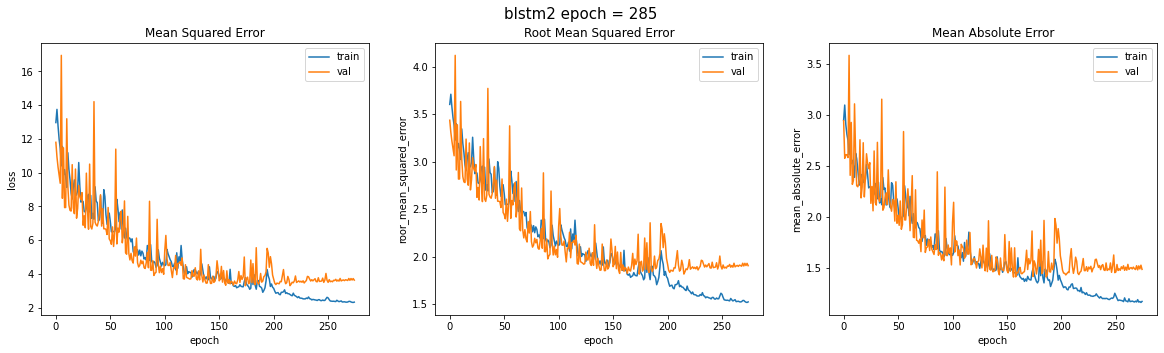

In [40]:
vis_results('blstm2', history_blstm2, epochs_blstm2)

In [41]:
results.update({'blstm2': eval_blstm2[1:]})

### lstm_fcn

In [42]:
eval_fcn, history_fcn, epochs_fcn = model_history(lstm_fcn, '/tmp/lstm_fcn.h5', 0.01)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_14 (Conv1D)             (None, 100, 128)     73856       ['input_9[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 100, 128)    512         ['conv1d_14[0][0]']              
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 100, 128)     0           ['batch_normalization[0][0]

Epoch 9/1000
10/10 [==============================] - ETA: 0s - loss: 6.8281 - mean_squared_error: 6.8281 - rmse: 2.6131 - mean_absolute_error: 2.0392
Epoch 00009: val_loss improved from 371.50754 to 39.07764, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 3s 298ms/step - loss: 6.8281 - mean_squared_error: 6.8281 - rmse: 2.6131 - mean_absolute_error: 2.0392 - val_loss: 39.0776 - val_mean_squared_error: 39.0776 - val_rmse: 6.2512 - val_mean_absolute_error: 5.6468 - lr: 0.0100
Epoch 10/1000
10/10 [==============================] - ETA: 0s - loss: 5.5249 - mean_squared_error: 5.5249 - rmse: 2.3505 - mean_absolute_error: 1.8458
Epoch 00010: val_loss improved from 39.07764 to 13.53976, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 3s 313ms/step - loss: 5.5249 - mean_squared_error: 5.5249 - rmse: 2.3505 - mean_absolute_error: 1.8458 - val_loss: 13.5398 - val_mean_squared_error: 13.5398 - val_rmse: 3.6796 - val_mean_absolute_error: 2.7511

10/10 [==============================] - ETA: 0s - loss: 4.2243 - mean_squared_error: 4.2243 - rmse: 2.0553 - mean_absolute_error: 1.6314
Epoch 00026: val_loss improved from 8.53353 to 7.39113, saving model to /tmp/lstm_fcn.h5
10/10 [==============================] - 3s 302ms/step - loss: 4.2243 - mean_squared_error: 4.2243 - rmse: 2.0553 - mean_absolute_error: 1.6314 - val_loss: 7.3911 - val_mean_squared_error: 7.3911 - val_rmse: 2.7187 - val_mean_absolute_error: 2.2035 - lr: 0.0100
Epoch 27/1000
10/10 [==============================] - ETA: 0s - loss: 3.7634 - mean_squared_error: 3.7634 - rmse: 1.9400 - mean_absolute_error: 1.5290
Epoch 00027: val_loss did not improve from 7.39113
10/10 [==============================] - 3s 292ms/step - loss: 3.7634 - mean_squared_error: 3.7634 - rmse: 1.9400 - mean_absolute_error: 1.5290 - val_loss: 21.4863 - val_mean_squared_error: 21.4863 - val_rmse: 4.6353 - val_mean_absolute_error: 3.5866 - lr: 0.0100
Epoch 28/1000
10/10 [=======================

Epoch 44/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.6756 - mean_squared_error: 2.6756 - rmse: 1.6357 - mean_absolute_error: 1.2947
Epoch 00044: val_loss did not improve from 7.39113
10/10 [==============================] - 2s 209ms/step - loss: 2.7107 - mean_squared_error: 2.7107 - rmse: 1.6464 - mean_absolute_error: 1.3014 - val_loss: 164.0356 - val_mean_squared_error: 164.0356 - val_rmse: 12.8076 - val_mean_absolute_error: 12.0155 - lr: 0.0100
Epoch 45/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.8641 - mean_squared_error: 2.8641 - rmse: 1.6924 - mean_absolute_error: 1.3169
Epoch 00045: val_loss did not improve from 7.39113
10/10 [==============================] - 2s 180ms/step - loss: 2.8770 - mean_squared_error: 2.8770 - rmse: 1.6962 - mean_absolute_error: 1.3207 - val_loss: 15.1084 - val_mean_squared_error: 15.1084 - val_rmse: 3.8870 - val_mean_absolute_error: 2.8635 - lr: 0.0100
Epoch 46/1000
 9/10 [==========================>...] - ETA: 0s

 9/10 [==========================>...] - ETA: 0s - loss: 1.7355 - mean_squared_error: 1.7355 - rmse: 1.3174 - mean_absolute_error: 1.0375
Epoch 00061: val_loss did not improve from 4.50119
10/10 [==============================] - 2s 180ms/step - loss: 1.7314 - mean_squared_error: 1.7314 - rmse: 1.3158 - mean_absolute_error: 1.0359 - val_loss: 36.4340 - val_mean_squared_error: 36.4340 - val_rmse: 6.0361 - val_mean_absolute_error: 5.3755 - lr: 0.0050
Epoch 62/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.7187 - mean_squared_error: 1.7187 - rmse: 1.3110 - mean_absolute_error: 1.0230
Epoch 00062: val_loss did not improve from 4.50119
10/10 [==============================] - 2s 181ms/step - loss: 1.8371 - mean_squared_error: 1.8371 - rmse: 1.3554 - mean_absolute_error: 1.0450 - val_loss: 8.7211 - val_mean_squared_error: 8.7211 - val_rmse: 2.9531 - val_mean_absolute_error: 2.3974 - lr: 0.0050
Epoch 63/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.8678 - me

Epoch 79/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.4457 - mean_squared_error: 1.4457 - rmse: 1.2024 - mean_absolute_error: 0.9298
Epoch 00079: val_loss did not improve from 4.16778
10/10 [==============================] - 2s 183ms/step - loss: 1.4706 - mean_squared_error: 1.4706 - rmse: 1.2127 - mean_absolute_error: 0.9385 - val_loss: 7.5551 - val_mean_squared_error: 7.5551 - val_rmse: 2.7487 - val_mean_absolute_error: 2.1561 - lr: 0.0050
Epoch 80/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.9453 - mean_squared_error: 0.9453 - rmse: 0.9722 - mean_absolute_error: 0.7433
Epoch 00080: val_loss did not improve from 4.16778
10/10 [==============================] - 2s 183ms/step - loss: 0.9650 - mean_squared_error: 0.9650 - rmse: 0.9823 - mean_absolute_error: 0.7506 - val_loss: 8.4882 - val_mean_squared_error: 8.4882 - val_rmse: 2.9134 - val_mean_absolute_error: 2.3270 - lr: 0.0050
Epoch 81/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 97/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.5507 - mean_squared_error: 0.5507 - rmse: 0.7421 - mean_absolute_error: 0.5790
Epoch 00097: val_loss did not improve from 4.03701
10/10 [==============================] - 3s 283ms/step - loss: 0.5615 - mean_squared_error: 0.5615 - rmse: 0.7493 - mean_absolute_error: 0.5832 - val_loss: 6.3010 - val_mean_squared_error: 6.3010 - val_rmse: 2.5102 - val_mean_absolute_error: 2.0194 - lr: 0.0025
Epoch 98/1000
10/10 [==============================] - ETA: 0s - loss: 0.5783 - mean_squared_error: 0.5783 - rmse: 0.7604 - mean_absolute_error: 0.5995
Epoch 00098: val_loss did not improve from 4.03701
10/10 [==============================] - 3s 283ms/step - loss: 0.5783 - mean_squared_error: 0.5783 - rmse: 0.7604 - mean_absolute_error: 0.5995 - val_loss: 5.0470 - val_mean_squared_error: 5.0470 - val_rmse: 2.2466 - val_mean_absolute_error: 1.7765 - lr: 0.0025
Epoch 99/1000
10/10 [==============================] - ETA: 0s - loss:

Epoch 115/1000
10/10 [==============================] - ETA: 0s - loss: 0.4241 - mean_squared_error: 0.4241 - rmse: 0.6513 - mean_absolute_error: 0.5035
Epoch 00115: val_loss did not improve from 3.87149
10/10 [==============================] - 3s 292ms/step - loss: 0.4241 - mean_squared_error: 0.4241 - rmse: 0.6513 - mean_absolute_error: 0.5035 - val_loss: 5.3936 - val_mean_squared_error: 5.3936 - val_rmse: 2.3224 - val_mean_absolute_error: 1.8206 - lr: 0.0012
Epoch 116/1000
10/10 [==============================] - ETA: 0s - loss: 0.4479 - mean_squared_error: 0.4479 - rmse: 0.6693 - mean_absolute_error: 0.5256
Epoch 00116: val_loss did not improve from 3.87149
10/10 [==============================] - 3s 291ms/step - loss: 0.4479 - mean_squared_error: 0.4479 - rmse: 0.6693 - mean_absolute_error: 0.5256 - val_loss: 4.1231 - val_mean_squared_error: 4.1231 - val_rmse: 2.0305 - val_mean_absolute_error: 1.5910 - lr: 0.0012
Epoch 117/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 133/1000
10/10 [==============================] - ETA: 0s - loss: 0.3847 - mean_squared_error: 0.3847 - rmse: 0.6203 - mean_absolute_error: 0.4845
Epoch 00133: val_loss did not improve from 3.87149
10/10 [==============================] - 3s 289ms/step - loss: 0.3847 - mean_squared_error: 0.3847 - rmse: 0.6203 - mean_absolute_error: 0.4845 - val_loss: 5.6451 - val_mean_squared_error: 5.6451 - val_rmse: 2.3759 - val_mean_absolute_error: 1.8544 - lr: 6.2500e-04
Epoch 134/1000
10/10 [==============================] - ETA: 0s - loss: 0.3768 - mean_squared_error: 0.3768 - rmse: 0.6138 - mean_absolute_error: 0.4806
Epoch 00134: val_loss did not improve from 3.87149
10/10 [==============================] - 3s 284ms/step - loss: 0.3768 - mean_squared_error: 0.3768 - rmse: 0.6138 - mean_absolute_error: 0.4806 - val_loss: 4.2734 - val_mean_squared_error: 4.2734 - val_rmse: 2.0672 - val_mean_absolute_error: 1.6308 - lr: 6.2500e-04
Epoch 135/1000
10/10 [==============================] - ETA:

Epoch 151/1000
10/10 [==============================] - ETA: 0s - loss: 0.3057 - mean_squared_error: 0.3057 - rmse: 0.5529 - mean_absolute_error: 0.4260
Epoch 00151: val_loss did not improve from 3.79074
10/10 [==============================] - 3s 284ms/step - loss: 0.3057 - mean_squared_error: 0.3057 - rmse: 0.5529 - mean_absolute_error: 0.4260 - val_loss: 10.8367 - val_mean_squared_error: 10.8367 - val_rmse: 3.2919 - val_mean_absolute_error: 2.6959 - lr: 6.2500e-04
Epoch 152/1000
10/10 [==============================] - ETA: 0s - loss: 0.4726 - mean_squared_error: 0.4726 - rmse: 0.6875 - mean_absolute_error: 0.5309
Epoch 00152: val_loss did not improve from 3.79074
10/10 [==============================] - 3s 293ms/step - loss: 0.4726 - mean_squared_error: 0.4726 - rmse: 0.6875 - mean_absolute_error: 0.5309 - val_loss: 6.6696 - val_mean_squared_error: 6.6696 - val_rmse: 2.5826 - val_mean_absolute_error: 2.0167 - lr: 6.2500e-04
Epoch 153/1000
10/10 [==============================] - ET

Epoch 169/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3600 - mean_squared_error: 0.3600 - rmse: 0.6000 - mean_absolute_error: 0.4733
Epoch 00169: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 279ms/step - loss: 0.3804 - mean_squared_error: 0.3804 - rmse: 0.6167 - mean_absolute_error: 0.4796 - val_loss: 4.0829 - val_mean_squared_error: 4.0829 - val_rmse: 2.0206 - val_mean_absolute_error: 1.5974 - lr: 6.2500e-04
Epoch 170/1000
10/10 [==============================] - ETA: 0s - loss: 0.3111 - mean_squared_error: 0.3111 - rmse: 0.5577 - mean_absolute_error: 0.4307
Epoch 00170: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 296ms/step - loss: 0.3111 - mean_squared_error: 0.3111 - rmse: 0.5577 - mean_absolute_error: 0.4307 - val_loss: 4.0237 - val_mean_squared_error: 4.0237 - val_rmse: 2.0059 - val_mean_absolute_error: 1.5670 - lr: 6.2500e-04
Epoch 171/1000
 9/10 [==========================>...] - ETA:

10/10 [==============================] - ETA: 0s - loss: 0.2748 - mean_squared_error: 0.2748 - rmse: 0.5242 - mean_absolute_error: 0.4008
Epoch 00186: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 295ms/step - loss: 0.2748 - mean_squared_error: 0.2748 - rmse: 0.5242 - mean_absolute_error: 0.4008 - val_loss: 4.2455 - val_mean_squared_error: 4.2455 - val_rmse: 2.0605 - val_mean_absolute_error: 1.6237 - lr: 3.1250e-04
Epoch 187/1000
10/10 [==============================] - ETA: 0s - loss: 0.2925 - mean_squared_error: 0.2925 - rmse: 0.5408 - mean_absolute_error: 0.3983
Epoch 00187: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 298ms/step - loss: 0.2925 - mean_squared_error: 0.2925 - rmse: 0.5408 - mean_absolute_error: 0.3983 - val_loss: 4.4909 - val_mean_squared_error: 4.4909 - val_rmse: 2.1192 - val_mean_absolute_error: 1.6819 - lr: 3.1250e-04
Epoch 188/1000
10/10 [==============================] - ETA: 0s - loss: 0.3

10/10 [==============================] - ETA: 0s - loss: 0.2569 - mean_squared_error: 0.2569 - rmse: 0.5069 - mean_absolute_error: 0.3940
Epoch 00203: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 295ms/step - loss: 0.2569 - mean_squared_error: 0.2569 - rmse: 0.5069 - mean_absolute_error: 0.3940 - val_loss: 4.6696 - val_mean_squared_error: 4.6696 - val_rmse: 2.1609 - val_mean_absolute_error: 1.6729 - lr: 1.5625e-04
Epoch 204/1000
10/10 [==============================] - ETA: 0s - loss: 0.2546 - mean_squared_error: 0.2546 - rmse: 0.5046 - mean_absolute_error: 0.4008
Epoch 00204: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 294ms/step - loss: 0.2546 - mean_squared_error: 0.2546 - rmse: 0.5046 - mean_absolute_error: 0.4008 - val_loss: 4.3560 - val_mean_squared_error: 4.3560 - val_rmse: 2.0871 - val_mean_absolute_error: 1.6154 - lr: 1.5625e-04
Epoch 205/1000
10/10 [==============================] - ETA: 0s - loss: 0.2

Epoch 221/1000
10/10 [==============================] - ETA: 0s - loss: 0.2873 - mean_squared_error: 0.2873 - rmse: 0.5360 - mean_absolute_error: 0.4115
Epoch 00221: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 282ms/step - loss: 0.2873 - mean_squared_error: 0.2873 - rmse: 0.5360 - mean_absolute_error: 0.4115 - val_loss: 4.1336 - val_mean_squared_error: 4.1336 - val_rmse: 2.0331 - val_mean_absolute_error: 1.5724 - lr: 1.5625e-04
Epoch 222/1000
10/10 [==============================] - ETA: 0s - loss: 0.1794 - mean_squared_error: 0.1794 - rmse: 0.4236 - mean_absolute_error: 0.3320
Epoch 00222: val_loss did not improve from 3.70449

Epoch 00222: ReduceLROnPlateau reducing learning rate to 7.812499825377017e-05.
10/10 [==============================] - 3s 282ms/step - loss: 0.1794 - mean_squared_error: 0.1794 - rmse: 0.4236 - mean_absolute_error: 0.3320 - val_loss: 4.3437 - val_mean_squared_error: 4.3437 - val_rmse: 2.0842 - val_mean_absolute_error: 1.6

10/10 [==============================] - ETA: 0s - loss: 0.1774 - mean_squared_error: 0.1774 - rmse: 0.4212 - mean_absolute_error: 0.3322
Epoch 00238: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 281ms/step - loss: 0.1774 - mean_squared_error: 0.1774 - rmse: 0.4212 - mean_absolute_error: 0.3322 - val_loss: 4.5555 - val_mean_squared_error: 4.5555 - val_rmse: 2.1344 - val_mean_absolute_error: 1.6322 - lr: 7.8125e-05
Epoch 239/1000
10/10 [==============================] - ETA: 0s - loss: 0.2979 - mean_squared_error: 0.2979 - rmse: 0.5458 - mean_absolute_error: 0.4314
Epoch 00239: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 291ms/step - loss: 0.2979 - mean_squared_error: 0.2979 - rmse: 0.5458 - mean_absolute_error: 0.4314 - val_loss: 4.2290 - val_mean_squared_error: 4.2290 - val_rmse: 2.0565 - val_mean_absolute_error: 1.5779 - lr: 7.8125e-05
Epoch 240/1000
10/10 [==============================] - ETA: 0s - loss: 0.3

 9/10 [==========================>...] - ETA: 0s - loss: 0.2807 - mean_squared_error: 0.2807 - rmse: 0.5298 - mean_absolute_error: 0.4192
Epoch 00255: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 307ms/step - loss: 0.2898 - mean_squared_error: 0.2898 - rmse: 0.5383 - mean_absolute_error: 0.4247 - val_loss: 4.1399 - val_mean_squared_error: 4.1399 - val_rmse: 2.0347 - val_mean_absolute_error: 1.5724 - lr: 3.9062e-05
Epoch 256/1000
10/10 [==============================] - ETA: 0s - loss: 0.1791 - mean_squared_error: 0.1791 - rmse: 0.4232 - mean_absolute_error: 0.3238
Epoch 00256: val_loss did not improve from 3.70449
10/10 [==============================] - 3s 292ms/step - loss: 0.1791 - mean_squared_error: 0.1791 - rmse: 0.4232 - mean_absolute_error: 0.3238 - val_loss: 4.1034 - val_mean_squared_error: 4.1034 - val_rmse: 2.0257 - val_mean_absolute_error: 1.5681 - lr: 3.9062e-05
Epoch 257/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1

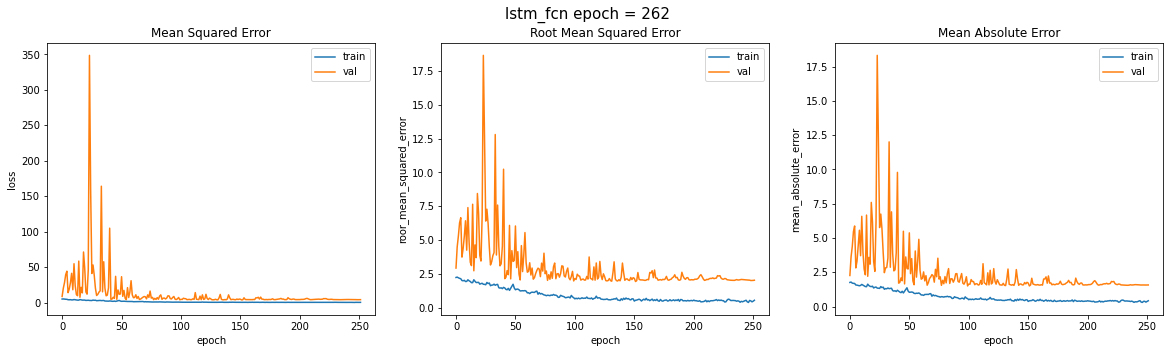

In [43]:
# plotting starting from epoch=5
vis_results('lstm_fcn', history_fcn, epochs_fcn)

In [44]:
results.update({'lstm_fcn': eval_fcn[1:]})

### cnn_resnet

In [45]:
eval_resnet, history_resnet, epochs_resnet = model_history(cnn_resnet, '/tmp/resnet.h5', 0.01)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 100, 72)]    0           []                               
                                                                                                  
 conv1d_17 (Conv1D)             (None, 100, 64)      36928       ['input_10[0][0]']               
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 100, 64)     256         ['conv1d_17[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_3 (Activation)      (None, 100, 64)      0           ['batch_normalization_3[0][

Epoch 1/1000
 9/10 [==========================>...] - ETA: 0s - loss: 62.2799 - mean_squared_error: 62.2799 - rmse: 7.8918 - mean_absolute_error: 6.4127
Epoch 00001: val_loss improved from inf to 2316819456.00000, saving model to /tmp/resnet.h5
10/10 [==============================] - 11s 514ms/step - loss: 61.8424 - mean_squared_error: 61.8424 - rmse: 7.8640 - mean_absolute_error: 6.3795 - val_loss: 2316819456.0000 - val_mean_squared_error: 2316819456.0000 - val_rmse: 48133.3516 - val_mean_absolute_error: 47997.0156 - lr: 0.0100
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 11.5817 - mean_squared_error: 11.5817 - rmse: 3.4032 - mean_absolute_error: 2.7675
Epoch 00002: val_loss improved from 2316819456.00000 to 894712256.00000, saving model to /tmp/resnet.h5
10/10 [==============================] - 4s 444ms/step - loss: 11.5817 - mean_squared_error: 11.5817 - rmse: 3.4032 - mean_absolute_error: 2.7675 - val_loss: 894712256.0000 - val_mean_squared_error: 89471225

Epoch 18/1000
10/10 [==============================] - ETA: 0s - loss: 3.8230 - mean_squared_error: 3.8230 - rmse: 1.9552 - mean_absolute_error: 1.5210
Epoch 00018: val_loss did not improve from 10.19893
10/10 [==============================] - 4s 441ms/step - loss: 3.8230 - mean_squared_error: 3.8230 - rmse: 1.9552 - mean_absolute_error: 1.5210 - val_loss: 55.8777 - val_mean_squared_error: 55.8777 - val_rmse: 7.4751 - val_mean_absolute_error: 6.7831 - lr: 0.0100
Epoch 19/1000
10/10 [==============================] - ETA: 0s - loss: 3.7213 - mean_squared_error: 3.7213 - rmse: 1.9291 - mean_absolute_error: 1.5111
Epoch 00019: val_loss did not improve from 10.19893
10/10 [==============================] - 4s 427ms/step - loss: 3.7213 - mean_squared_error: 3.7213 - rmse: 1.9291 - mean_absolute_error: 1.5111 - val_loss: 12.1481 - val_mean_squared_error: 12.1481 - val_rmse: 3.4854 - val_mean_absolute_error: 2.8266 - lr: 0.0100
Epoch 20/1000
10/10 [==============================] - ETA: 0s -

Epoch 36/1000
 9/10 [==========================>...] - ETA: 0s - loss: 2.2725 - mean_squared_error: 2.2725 - rmse: 1.5075 - mean_absolute_error: 1.1970
Epoch 00036: val_loss did not improve from 7.12561
10/10 [==============================] - 4s 429ms/step - loss: 2.3154 - mean_squared_error: 2.3154 - rmse: 1.5216 - mean_absolute_error: 1.2078 - val_loss: 14.9515 - val_mean_squared_error: 14.9515 - val_rmse: 3.8667 - val_mean_absolute_error: 2.9775 - lr: 0.0050
Epoch 37/1000
10/10 [==============================] - ETA: 0s - loss: 2.3714 - mean_squared_error: 2.3714 - rmse: 1.5399 - mean_absolute_error: 1.1927
Epoch 00037: val_loss did not improve from 7.12561
10/10 [==============================] - 4s 429ms/step - loss: 2.3714 - mean_squared_error: 2.3714 - rmse: 1.5399 - mean_absolute_error: 1.1927 - val_loss: 8.6130 - val_mean_squared_error: 8.6130 - val_rmse: 2.9348 - val_mean_absolute_error: 2.2818 - lr: 0.0050
Epoch 38/1000
10/10 [==============================] - ETA: 0s - los

Epoch 54/1000
10/10 [==============================] - ETA: 0s - loss: 1.8762 - mean_squared_error: 1.8762 - rmse: 1.3697 - mean_absolute_error: 1.0609
Epoch 00054: val_loss did not improve from 6.01325
10/10 [==============================] - 4s 436ms/step - loss: 1.8762 - mean_squared_error: 1.8762 - rmse: 1.3697 - mean_absolute_error: 1.0609 - val_loss: 6.8232 - val_mean_squared_error: 6.8232 - val_rmse: 2.6121 - val_mean_absolute_error: 1.9750 - lr: 0.0050
Epoch 55/1000
10/10 [==============================] - ETA: 0s - loss: 1.7723 - mean_squared_error: 1.7723 - rmse: 1.3313 - mean_absolute_error: 1.0403
Epoch 00055: val_loss did not improve from 6.01325
10/10 [==============================] - 4s 435ms/step - loss: 1.7723 - mean_squared_error: 1.7723 - rmse: 1.3313 - mean_absolute_error: 1.0403 - val_loss: 10.6872 - val_mean_squared_error: 10.6872 - val_rmse: 3.2691 - val_mean_absolute_error: 2.7795 - lr: 0.0050
Epoch 56/1000
10/10 [==============================] - ETA: 0s - los

Epoch 72/1000
10/10 [==============================] - ETA: 0s - loss: 1.2848 - mean_squared_error: 1.2848 - rmse: 1.1335 - mean_absolute_error: 0.8704
Epoch 00072: val_loss did not improve from 5.43781
10/10 [==============================] - 4s 443ms/step - loss: 1.2848 - mean_squared_error: 1.2848 - rmse: 1.1335 - mean_absolute_error: 0.8704 - val_loss: 18.5042 - val_mean_squared_error: 18.5042 - val_rmse: 4.3017 - val_mean_absolute_error: 3.6410 - lr: 0.0050
Epoch 73/1000
 9/10 [==========================>...] - ETA: 0s - loss: 1.5342 - mean_squared_error: 1.5342 - rmse: 1.2386 - mean_absolute_error: 0.9548
Epoch 00073: val_loss did not improve from 5.43781
10/10 [==============================] - 5s 453ms/step - loss: 1.5558 - mean_squared_error: 1.5558 - rmse: 1.2473 - mean_absolute_error: 0.9616 - val_loss: 7.5398 - val_mean_squared_error: 7.5398 - val_rmse: 2.7459 - val_mean_absolute_error: 2.1215 - lr: 0.0050
Epoch 74/1000
10/10 [==============================] - ETA: 0s - los

Epoch 90/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.9036 - mean_squared_error: 0.9036 - rmse: 0.9506 - mean_absolute_error: 0.7378
Epoch 00090: val_loss did not improve from 5.06874
10/10 [==============================] - 5s 452ms/step - loss: 0.9533 - mean_squared_error: 0.9533 - rmse: 0.9764 - mean_absolute_error: 0.7507 - val_loss: 9.5205 - val_mean_squared_error: 9.5205 - val_rmse: 3.0855 - val_mean_absolute_error: 2.5199 - lr: 0.0050
Epoch 91/1000
10/10 [==============================] - ETA: 0s - loss: 1.3948 - mean_squared_error: 1.3948 - rmse: 1.1810 - mean_absolute_error: 0.9288
Epoch 00091: val_loss did not improve from 5.06874
10/10 [==============================] - 4s 430ms/step - loss: 1.3948 - mean_squared_error: 1.3948 - rmse: 1.1810 - mean_absolute_error: 0.9288 - val_loss: 7.4804 - val_mean_squared_error: 7.4804 - val_rmse: 2.7350 - val_mean_absolute_error: 2.0853 - lr: 0.0050
Epoch 92/1000
 9/10 [==========================>...] - ETA: 0s - loss:

Epoch 108/1000
10/10 [==============================] - ETA: 0s - loss: 0.8882 - mean_squared_error: 0.8882 - rmse: 0.9424 - mean_absolute_error: 0.7369
Epoch 00108: val_loss did not improve from 4.90199
10/10 [==============================] - 4s 423ms/step - loss: 0.8882 - mean_squared_error: 0.8882 - rmse: 0.9424 - mean_absolute_error: 0.7369 - val_loss: 5.5026 - val_mean_squared_error: 5.5026 - val_rmse: 2.3458 - val_mean_absolute_error: 1.8961 - lr: 0.0050
Epoch 109/1000
10/10 [==============================] - ETA: 0s - loss: 0.6446 - mean_squared_error: 0.6446 - rmse: 0.8028 - mean_absolute_error: 0.6327
Epoch 00109: val_loss did not improve from 4.90199
10/10 [==============================] - 4s 419ms/step - loss: 0.6446 - mean_squared_error: 0.6446 - rmse: 0.8028 - mean_absolute_error: 0.6327 - val_loss: 30.7778 - val_mean_squared_error: 30.7778 - val_rmse: 5.5478 - val_mean_absolute_error: 4.8211 - lr: 0.0050
Epoch 110/1000
 9/10 [==========================>...] - ETA: 0s - 

Epoch 126/1000
10/10 [==============================] - ETA: 0s - loss: 0.7568 - mean_squared_error: 0.7568 - rmse: 0.8699 - mean_absolute_error: 0.6757
Epoch 00126: val_loss improved from 4.90199 to 4.41423, saving model to /tmp/resnet.h5
10/10 [==============================] - 5s 530ms/step - loss: 0.7568 - mean_squared_error: 0.7568 - rmse: 0.8699 - mean_absolute_error: 0.6757 - val_loss: 4.4142 - val_mean_squared_error: 4.4142 - val_rmse: 2.1010 - val_mean_absolute_error: 1.6217 - lr: 0.0025
Epoch 127/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.5778 - mean_squared_error: 0.5778 - rmse: 0.7601 - mean_absolute_error: 0.6006
Epoch 00127: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 441ms/step - loss: 0.6045 - mean_squared_error: 0.6045 - rmse: 0.7775 - mean_absolute_error: 0.6106 - val_loss: 4.9425 - val_mean_squared_error: 4.9425 - val_rmse: 2.2232 - val_mean_absolute_error: 1.7244 - lr: 0.0025
Epoch 128/1000
 9/10 [==========

Epoch 144/1000
10/10 [==============================] - ETA: 0s - loss: 0.7708 - mean_squared_error: 0.7708 - rmse: 0.8780 - mean_absolute_error: 0.7019
Epoch 00144: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 434ms/step - loss: 0.7708 - mean_squared_error: 0.7708 - rmse: 0.8780 - mean_absolute_error: 0.7019 - val_loss: 6.9447 - val_mean_squared_error: 6.9447 - val_rmse: 2.6353 - val_mean_absolute_error: 2.0488 - lr: 0.0025
Epoch 145/1000
10/10 [==============================] - ETA: 0s - loss: 0.4375 - mean_squared_error: 0.4375 - rmse: 0.6614 - mean_absolute_error: 0.5205
Epoch 00145: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 420ms/step - loss: 0.4375 - mean_squared_error: 0.4375 - rmse: 0.6614 - mean_absolute_error: 0.5205 - val_loss: 5.1370 - val_mean_squared_error: 5.1370 - val_rmse: 2.2665 - val_mean_absolute_error: 1.8385 - lr: 0.0025
Epoch 146/1000
10/10 [==============================] - ETA: 0s - lo

Epoch 162/1000
10/10 [==============================] - ETA: 0s - loss: 0.3347 - mean_squared_error: 0.3347 - rmse: 0.5785 - mean_absolute_error: 0.4592
Epoch 00162: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 413ms/step - loss: 0.3347 - mean_squared_error: 0.3347 - rmse: 0.5785 - mean_absolute_error: 0.4592 - val_loss: 4.9783 - val_mean_squared_error: 4.9783 - val_rmse: 2.2312 - val_mean_absolute_error: 1.7700 - lr: 0.0012
Epoch 163/1000
10/10 [==============================] - ETA: 0s - loss: 0.2844 - mean_squared_error: 0.2844 - rmse: 0.5333 - mean_absolute_error: 0.4132
Epoch 00163: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 441ms/step - loss: 0.2844 - mean_squared_error: 0.2844 - rmse: 0.5333 - mean_absolute_error: 0.4132 - val_loss: 5.7214 - val_mean_squared_error: 5.7214 - val_rmse: 2.3919 - val_mean_absolute_error: 1.8719 - lr: 0.0012
Epoch 164/1000
10/10 [==============================] - ETA: 0s - lo

10/10 [==============================] - ETA: 0s - loss: 0.2586 - mean_squared_error: 0.2586 - rmse: 0.5085 - mean_absolute_error: 0.3933
Epoch 00179: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 426ms/step - loss: 0.2586 - mean_squared_error: 0.2586 - rmse: 0.5085 - mean_absolute_error: 0.3933 - val_loss: 4.9096 - val_mean_squared_error: 4.9096 - val_rmse: 2.2158 - val_mean_absolute_error: 1.7092 - lr: 6.2500e-04
Epoch 180/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.3275 - mean_squared_error: 0.3275 - rmse: 0.5722 - mean_absolute_error: 0.4197
Epoch 00180: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 435ms/step - loss: 0.3336 - mean_squared_error: 0.3336 - rmse: 0.5776 - mean_absolute_error: 0.4224 - val_loss: 4.8505 - val_mean_squared_error: 4.8505 - val_rmse: 2.2024 - val_mean_absolute_error: 1.7107 - lr: 6.2500e-04
Epoch 181/1000
10/10 [==============================] - ETA: 0s - loss: 0.2

10/10 [==============================] - ETA: 0s - loss: 0.2180 - mean_squared_error: 0.2180 - rmse: 0.4669 - mean_absolute_error: 0.3536
Epoch 00196: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 434ms/step - loss: 0.2180 - mean_squared_error: 0.2180 - rmse: 0.4669 - mean_absolute_error: 0.3536 - val_loss: 5.5489 - val_mean_squared_error: 5.5489 - val_rmse: 2.3556 - val_mean_absolute_error: 1.8724 - lr: 3.1250e-04
Epoch 197/1000
10/10 [==============================] - ETA: 0s - loss: 0.1444 - mean_squared_error: 0.1444 - rmse: 0.3800 - mean_absolute_error: 0.2960
Epoch 00197: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 436ms/step - loss: 0.1444 - mean_squared_error: 0.1444 - rmse: 0.3800 - mean_absolute_error: 0.2960 - val_loss: 5.3052 - val_mean_squared_error: 5.3052 - val_rmse: 2.3033 - val_mean_absolute_error: 1.8214 - lr: 3.1250e-04
Epoch 198/1000
10/10 [==============================] - ETA: 0s - loss: 0.2

 9/10 [==========================>...] - ETA: 0s - loss: 0.3326 - mean_squared_error: 0.3326 - rmse: 0.5767 - mean_absolute_error: 0.4535
Epoch 00213: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 425ms/step - loss: 0.3514 - mean_squared_error: 0.3514 - rmse: 0.5928 - mean_absolute_error: 0.4614 - val_loss: 4.8046 - val_mean_squared_error: 4.8046 - val_rmse: 2.1919 - val_mean_absolute_error: 1.7218 - lr: 1.5625e-04
Epoch 214/1000
10/10 [==============================] - ETA: 0s - loss: 0.1579 - mean_squared_error: 0.1579 - rmse: 0.3974 - mean_absolute_error: 0.3173
Epoch 00214: val_loss did not improve from 4.41423
10/10 [==============================] - 4s 436ms/step - loss: 0.1579 - mean_squared_error: 0.1579 - rmse: 0.3974 - mean_absolute_error: 0.3173 - val_loss: 4.9598 - val_mean_squared_error: 4.9598 - val_rmse: 2.2271 - val_mean_absolute_error: 1.7517 - lr: 1.5625e-04
Epoch 215/1000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1

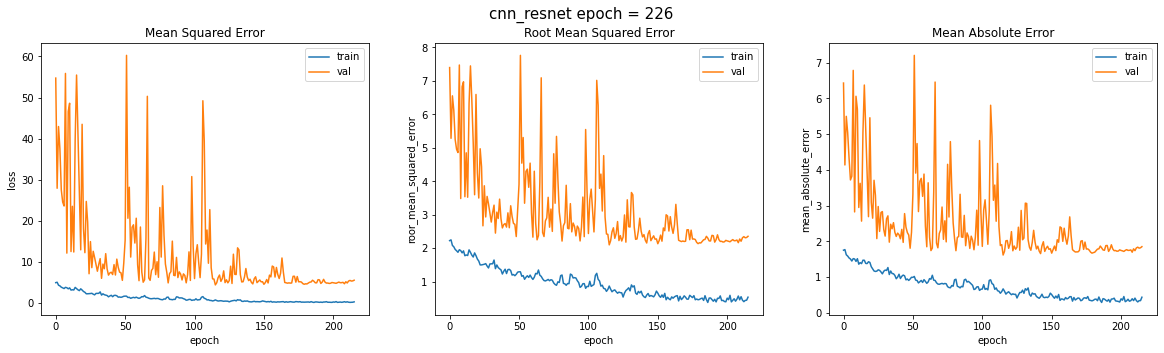

In [46]:
# plotting starting from epoch=10
vis_results('cnn_resnet', history_resnet, epochs_resnet)

In [47]:
results.update({'cnn_resnet': eval_resnet[1:]})

In [48]:
results

{'cnn_lenet': [8.002669334411621, 2.8288989067077637, 1.9728044271469116],
 'mlp4': [5.9863080978393555, 2.446693181991577, 1.8992811441421509],
 'cnn_vgg': [5.624680995941162, 2.371640920639038, 1.8451180458068848],
 'lstm1v0': [5.240535259246826, 2.2892215251922607, 1.7374200820922852],
 'lstm1': [5.077854156494141, 2.2534093856811523, 1.7151856422424316],
 'lstm2': [6.419451713562012, 2.533663749694824, 1.8759117126464844],
 'blstm1': [4.6808762550354, 2.1635332107543945, 1.6266433000564575],
 'blstm2': [5.178459644317627, 2.275622844696045, 1.74307119846344],
 'lstm_fcn': [4.988656997680664, 2.233530282974243, 1.7113491296768188],
 'cnn_resnet': [6.063419342041016, 2.4624011516571045, 1.8719780445098877]}